In [148]:
import numpy as np
import pandas as pd
pd.set_option('use_inf_as_na', True) # Treat infinite values as na
import matplotlib.pyplot as plt
import seaborn as sns

import xgboost as xgb
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import TimeSeriesSplit, GridSearchCV
import math

In [2]:
df_auction_data = pd.read_csv('./data/auction_data.csv', sep=';', skiprows=[1], index_col=[0])
df_forecast_inputs = pd.read_csv('./data/forecast_inputs.csv', sep=';', skiprows=[1], index_col=[0])
df_system_prices = pd.read_csv('./data/system_prices.csv', sep=';', skiprows=[1], index_col=[0])

In [3]:
df_auction_data.head()

price_first_auction  price_second_auction  \
Date (WET)                                                      
[01/01/2021 00:00]                 68.0                 65.73   
[01/01/2021 01:00]                 62.7                 64.96   
[01/01/2021 02:00]                 56.0                 60.47   
[01/01/2021 03:00]                 50.1                 52.50   
[01/01/2021 04:00]                 50.0                 48.98   

                    traded_volume_first_auction  traded_volume_second_auction  \
Date (WET)                                                                      
[01/01/2021 00:00]                       2923.7                        5102.4   
[01/01/2021 01:00]                       2825.0                        4771.5   
[01/01/2021 02:00]                       2611.4                        4176.2   
[01/01/2021 03:00]                       2669.3                        3755.9   
[01/01/2021 04:00]                       2741.4                        4047.5   

                    price_forecast_first_auction  
Date (WET)                                        
[01/01/2021 00:00]                         54.19  
[01/01/2021 01:00]                         53.42  
[01/01/2021 02:00]                         50.13  
[01/01/2021 03:00]                         50.28  
[01/01/2021 04:00]                         47.19

In [4]:
df_auction_data.index = [date.strip('[]') for date in df_auction_data.index]
df_auction_data.index = pd.to_datetime(df_auction_data.index, format='%d/%m/%Y %H:%M')
#remove duplicate '31/10/2021 01:00' entry
df_auction_data = df_auction_data[~df_auction_data.index.duplicated(keep='first')]

In [5]:
df_auction_data.head()

price_first_auction  price_second_auction  \
2021-01-01 00:00:00                 68.0                 65.73   
2021-01-01 01:00:00                 62.7                 64.96   
2021-01-01 02:00:00                 56.0                 60.47   
2021-01-01 03:00:00                 50.1                 52.50   
2021-01-01 04:00:00                 50.0                 48.98   

                     traded_volume_first_auction  \
2021-01-01 00:00:00                       2923.7   
2021-01-01 01:00:00                       2825.0   
2021-01-01 02:00:00                       2611.4   
2021-01-01 03:00:00                       2669.3   
2021-01-01 04:00:00                       2741.4   

                     traded_volume_second_auction  \
2021-01-01 00:00:00                        5102.4   
2021-01-01 01:00:00                        4771.5   
2021-01-01 02:00:00                        4176.2   
2021-01-01 03:00:00                        3755.9   
2021-01-01 04:00:00                        4047.5   

                     price_forecast_first_auction  
2021-01-01 00:00:00                         54.19  
2021-01-01 01:00:00                         53.42  
2021-01-01 02:00:00                         50.13  
2021-01-01 03:00:00                         50.28  
2021-01-01 04:00:00                         47.19

# Data cleaning

I've already noticed a duplicate timestep above, below I also handle some other data issues in the given forecast inputs.

In [6]:
df_forecast_inputs.index = [date.strip('[]') for date in df_forecast_inputs.index]
df_forecast_inputs.index = pd.to_datetime(df_forecast_inputs.index, format='%d/%m/%Y %H:%M')

# convert 'demand_plus_system_margin' column to numeric value
df_forecast_inputs['demand_plus_system_margin'] = pd.to_numeric(df_forecast_inputs['demand_plus_system_margin'], errors='coerce')

# clean 'Please' value in column and convert 'long_term_solar' column to numeric value
df_forecast_inputs.loc[df_forecast_inputs['long_term_solar'] == 'Please', 'long_term_solar'] = 0
df_forecast_inputs['long_term_solar'] = pd.to_numeric(df_forecast_inputs['long_term_solar'])

# clean 'Clean' value in column and convert 'margin_over_demand' column to numeric value
df_forecast_inputs.loc[df_forecast_inputs['margin_over_demand'] == 'Clean', 'margin_over_demand'] = round(df_forecast_inputs[df_forecast_inputs['margin_over_demand'] == 'Clean']['margin'] / df_forecast_inputs[df_forecast_inputs['margin_over_demand'] == 'Clean']['demand'] * 100).astype(int)
df_forecast_inputs['margin_over_demand'] = pd.to_numeric(df_forecast_inputs['margin_over_demand'])

# clean 'The' value, remove duplicate '31/10/2021 01:00' entry, add missing values in 'previous_day_ahead_price' column and convert to numeric value
df_forecast_inputs = df_forecast_inputs[~df_forecast_inputs.index.duplicated(keep='first')]
for i in df_forecast_inputs.loc[(df_forecast_inputs['previous_day_ahead_price'].isna()) | (df_forecast_inputs['previous_day_ahead_price'] == 'The')]['previous_day_ahead_price'].index:
    i_prev_day = i - pd.DateOffset(days=1)
    try:
        df_forecast_inputs.loc[i, 'previous_day_ahead_price'] = float(df_auction_data.loc[i_prev_day]['price_first_auction'])
    except: # missing index [28/03/2021 01:00] so will assign missing value with the next hour's value
        df_forecast_inputs.loc[i, 'previous_day_ahead_price'] = float(df_auction_data.loc[i_prev_day + pd.DateOffset(hours=1)]['price_first_auction'])
df_forecast_inputs['previous_day_ahead_price'] = pd.to_numeric(df_forecast_inputs['previous_day_ahead_price'])

In [7]:
df_forecast_inputs.head()

demand_plus_system_margin   demand  \
2021-01-01 00:00:00                   56513.64  30182.0   
2021-01-01 01:00:00                   56506.94  29269.0   
2021-01-01 02:00:00                   56502.20  27245.0   
2021-01-01 03:00:00                   56487.24  25545.5   
2021-01-01 04:00:00                   56373.63  24180.0   

                     within_day_availability    margin  within_day_margin  \
2021-01-01 00:00:00                 40389.06 -26331.64          -15268.70   
2021-01-01 01:00:00                 40389.06 -27237.94          -16191.00   
2021-01-01 02:00:00                 40389.06 -29257.20          -18226.26   
2021-01-01 03:00:00                 40389.06 -30941.74          -19935.30   
2021-01-01 04:00:00                 40389.06 -32193.63          -21212.69   

                     long_term_wind  long_term_solar  \
2021-01-01 00:00:00        -3674.64              0.0   
2021-01-01 01:00:00        -3667.94              0.0   
2021-01-01 02:00:00        -3663.20              0.0   
2021-01-01 03:00:00        -3648.24              0.0   
2021-01-01 04:00:00        -3534.63              0.0   

                     long_term_wind_over_demand  long_term_wind_over_margin  \
2021-01-01 00:00:00                         -12                         -14   
2021-01-01 01:00:00                         -13                         -14   
2021-01-01 02:00:00                         -14                         -13   
2021-01-01 03:00:00                         -15                         -12   
2021-01-01 04:00:00                         -15                         -11   

                     long_term_solar_over_demand  long_term_solar_over_margin  \
2021-01-01 00:00:00                          0.0                          0.0   
2021-01-01 01:00:00                          0.0                          0.0   
2021-01-01 02:00:00                          0.0                          0.0   
2021-01-01 03:00:00                          0.0                          0.0   
2021-01-01 04:00:00                          0.0                          0.0   

                     margin_over_demand  snsp_forecast  stack_price  \
2021-01-01 00:00:00                 -87          29.95        67.79   
2021-01-01 01:00:00                 -93          31.05        67.79   
2021-01-01 02:00:00                -108          32.80        67.73   
2021-01-01 03:00:00                -121          34.95        67.61   
2021-01-01 04:00:00                -134          36.70        66.48   

                     within_day_potential_stack_price  \
2021-01-01 00:00:00                             68.88   
2021-01-01 01:00:00                             68.45   
2021-01-01 02:00:00                             67.79   
2021-01-01 03:00:00                             67.73   
2021-01-01 04:00:00                             67.67   

                     previous_day_ahead_price  \
2021-01-01 00:00:00                     65.02   
2021-01-01 01:00:00                     62.00   
2021-01-01 02:00:00                     54.16   
2021-01-01 03:00:00                     51.94   
2021-01-01 04:00:00                     49.17   

                     previous_continuous_half_hour_vwap  inertia_forecast  
2021-01-01 00:00:00                               59.69            214.67  
2021-01-01 01:00:00                               51.86            205.47  
2021-01-01 02:00:00                               46.29            191.12  
2021-01-01 03:00:00                               54.22            176.23  
2021-01-01 04:00:00                               57.26            163.59

In [8]:
df_system_prices.index = [date.strip('[]') for date in df_system_prices.index]
df_system_prices.index = pd.to_datetime(df_system_prices.index, format='%d/%m/%Y %H:%M')
#remove duplicate '31/10/2021 01:00' entry
df_system_prices = df_system_prices[~df_system_prices.index.duplicated(keep='first')]

In [9]:
df_system_prices.head()

forecast_system_price_low  forecast_system_price_high  \
2021-01-01 00:00:00                      48.33                       44.89   
2021-01-01 01:00:00                      54.35                       53.26   
2021-01-01 02:00:00                      32.66                       65.86   
2021-01-01 03:00:00                      41.55                       63.43   
2021-01-01 04:00:00                      26.62                       66.91   

                     system_price  
2021-01-01 00:00:00         73.15  
2021-01-01 01:00:00         71.95  
2021-01-01 02:00:00         54.56  
2021-01-01 03:00:00         70.73  
2021-01-01 04:00:00         54.98

# Train / Test split

In [10]:
df_auction_data_train = df_auction_data.loc[df_auction_data.index < '2022-03-01']
df_auction_data_test = df_auction_data.loc[df_auction_data.index >= '2022-03-01']

df_forecast_inputs_train = df_forecast_inputs.loc[df_forecast_inputs.index < '2022-03-01']
df_forecast_inputs_test = df_forecast_inputs.loc[df_forecast_inputs.index >= '2022-03-01']

df_system_prices_train = df_system_prices.loc[df_system_prices.index < '2022-03-01']
df_system_prices_test = df_system_prices.loc[df_system_prices.index >= '2022-03-01']

In [11]:
df_auction_data_train.head()

price_first_auction  price_second_auction  \
2021-01-01 00:00:00                 68.0                 65.73   
2021-01-01 01:00:00                 62.7                 64.96   
2021-01-01 02:00:00                 56.0                 60.47   
2021-01-01 03:00:00                 50.1                 52.50   
2021-01-01 04:00:00                 50.0                 48.98   

                     traded_volume_first_auction  \
2021-01-01 00:00:00                       2923.7   
2021-01-01 01:00:00                       2825.0   
2021-01-01 02:00:00                       2611.4   
2021-01-01 03:00:00                       2669.3   
2021-01-01 04:00:00                       2741.4   

                     traded_volume_second_auction  \
2021-01-01 00:00:00                        5102.4   
2021-01-01 01:00:00                        4771.5   
2021-01-01 02:00:00                        4176.2   
2021-01-01 03:00:00                        3755.9   
2021-01-01 04:00:00                        4047.5   

                     price_forecast_first_auction  
2021-01-01 00:00:00                         54.19  
2021-01-01 01:00:00                         53.42  
2021-01-01 02:00:00                         50.13  
2021-01-01 03:00:00                         50.28  
2021-01-01 04:00:00                         47.19

## EDA

In [12]:
df_auction_data_train.describe()

price_first_auction  price_second_auction  traded_volume_first_auction  \
count         10175.000000          10175.000000                 10175.000000   
mean            125.681352            125.508363                  3827.005229   
std              98.796190            102.158820                  1161.509006   
min             -24.900000            -50.000000                   991.800000   
25%              65.450000             66.065000                  2927.350000   
50%              98.000000             97.910000                  3663.300000   
75%             167.000000            165.675000                  4547.600000   
max            1860.000000           2500.010000                  8459.600000   

       traded_volume_second_auction  price_forecast_first_auction  
count                  10173.000000                  10127.000000  
mean                    8900.579967                    124.857105  
std                     2771.597762                     87.508544  
min                     3329.200000                   -275.030000  
25%                     6910.600000                     65.945000  
50%                     8319.800000                     99.380000  
75%                    10524.000000                    164.005000  
max                    18419.100000                   1578.620000

<AxesSubplot:>

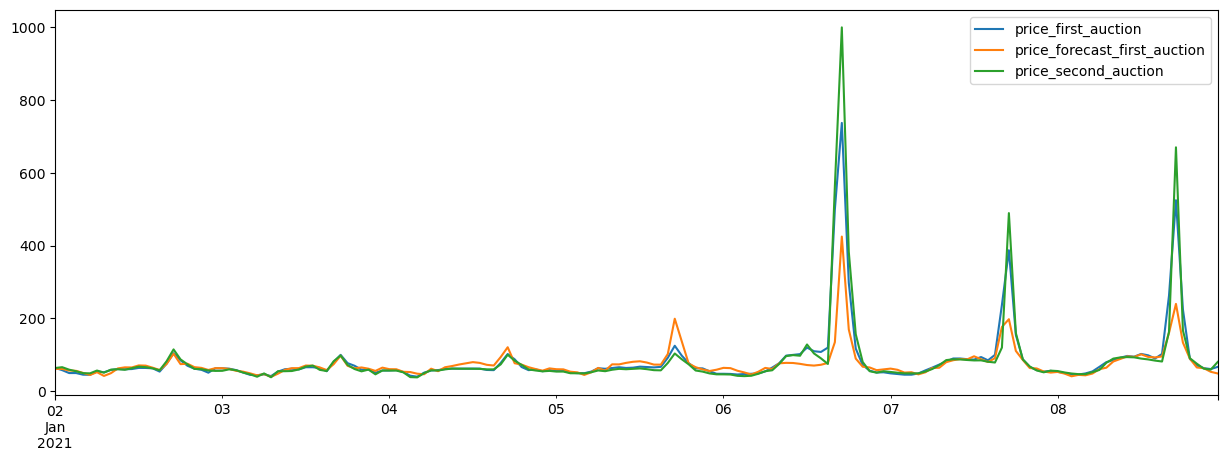

In [108]:
df_auction_data_train[['price_first_auction', 'price_forecast_first_auction', 'price_second_auction']].loc['2021-01-01':'2021-01-08'].plot(figsize=(15, 5))

In [14]:
df_forecast_inputs_train.head()

demand_plus_system_margin   demand  \
2021-01-01 00:00:00                   56513.64  30182.0   
2021-01-01 01:00:00                   56506.94  29269.0   
2021-01-01 02:00:00                   56502.20  27245.0   
2021-01-01 03:00:00                   56487.24  25545.5   
2021-01-01 04:00:00                   56373.63  24180.0   

                     within_day_availability    margin  within_day_margin  \
2021-01-01 00:00:00                 40389.06 -26331.64          -15268.70   
2021-01-01 01:00:00                 40389.06 -27237.94          -16191.00   
2021-01-01 02:00:00                 40389.06 -29257.20          -18226.26   
2021-01-01 03:00:00                 40389.06 -30941.74          -19935.30   
2021-01-01 04:00:00                 40389.06 -32193.63          -21212.69   

                     long_term_wind  long_term_solar  \
2021-01-01 00:00:00        -3674.64              0.0   
2021-01-01 01:00:00        -3667.94              0.0   
2021-01-01 02:00:00        -3663.20              0.0   
2021-01-01 03:00:00        -3648.24              0.0   
2021-01-01 04:00:00        -3534.63              0.0   

                     long_term_wind_over_demand  long_term_wind_over_margin  \
2021-01-01 00:00:00                         -12                         -14   
2021-01-01 01:00:00                         -13                         -14   
2021-01-01 02:00:00                         -14                         -13   
2021-01-01 03:00:00                         -15                         -12   
2021-01-01 04:00:00                         -15                         -11   

                     long_term_solar_over_demand  long_term_solar_over_margin  \
2021-01-01 00:00:00                          0.0                          0.0   
2021-01-01 01:00:00                          0.0                          0.0   
2021-01-01 02:00:00                          0.0                          0.0   
2021-01-01 03:00:00                          0.0                          0.0   
2021-01-01 04:00:00                          0.0                          0.0   

                     margin_over_demand  snsp_forecast  stack_price  \
2021-01-01 00:00:00                 -87          29.95        67.79   
2021-01-01 01:00:00                 -93          31.05        67.79   
2021-01-01 02:00:00                -108          32.80        67.73   
2021-01-01 03:00:00                -121          34.95        67.61   
2021-01-01 04:00:00                -134          36.70        66.48   

                     within_day_potential_stack_price  \
2021-01-01 00:00:00                             68.88   
2021-01-01 01:00:00                             68.45   
2021-01-01 02:00:00                             67.79   
2021-01-01 03:00:00                             67.73   
2021-01-01 04:00:00                             67.67   

                     previous_day_ahead_price  \
2021-01-01 00:00:00                     65.02   
2021-01-01 01:00:00                     62.00   
2021-01-01 02:00:00                     54.16   
2021-01-01 03:00:00                     51.94   
2021-01-01 04:00:00                     49.17   

                     previous_continuous_half_hour_vwap  inertia_forecast  
2021-01-01 00:00:00                               59.69            214.67  
2021-01-01 01:00:00                               51.86            205.47  
2021-01-01 02:00:00                               46.29            191.12  
2021-01-01 03:00:00                               54.22            176.23  
2021-01-01 04:00:00                               57.26            163.59

<AxesSubplot:>

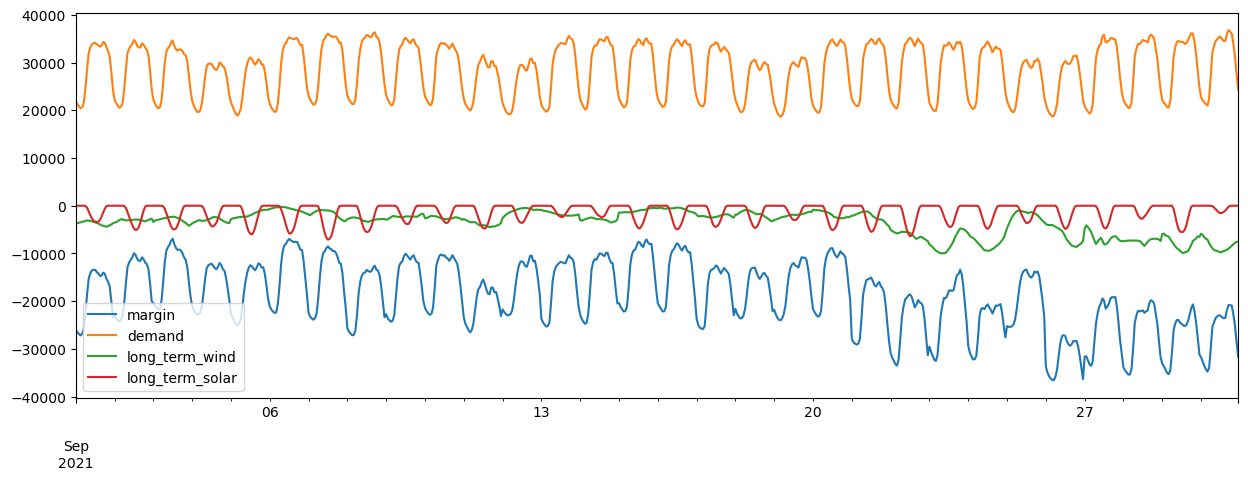

In [15]:
df_forecast_inputs_train[['margin', 'demand', 'long_term_wind', 'long_term_solar']].loc['2021-09'].plot(figsize=(15, 5))

<AxesSubplot:>

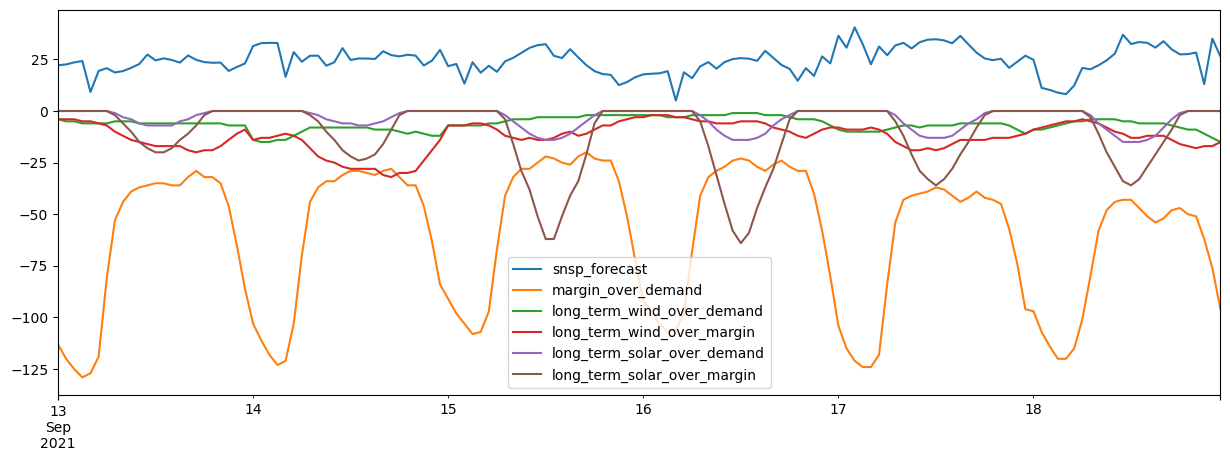

In [16]:
df_forecast_inputs_train[['snsp_forecast', 'margin_over_demand', 'long_term_wind_over_demand', 'long_term_wind_over_margin', 'long_term_solar_over_demand', 'long_term_solar_over_margin']].loc['2021-09-13':'2021-09-18'].plot(figsize=(15, 5))

In [18]:
df_forecast_inputs_train.describe()

demand_plus_system_margin        demand  within_day_availability  \
count               10174.000000  10175.000000             10175.000000   
mean                56228.852865  31722.878471             32831.989081   
std                  9143.181609   6764.480972              3397.853519   
min                 39862.460000  17907.000000             25178.610000   
25%                 48042.835000  26351.250000             29793.895000   
50%                 55386.510000  31984.000000             33213.200000   
75%                 63586.327500  36602.750000             35485.520000   
max                 77821.840000  50112.000000             40772.440000   

             margin  within_day_margin  long_term_wind  long_term_solar  \
count  10174.000000       10175.000000    10175.000000     10127.000000   
mean  -24504.971891       -9588.967081    -5598.399165     -1211.845759   
std     9515.483706        6825.720607     3655.858789      1872.133513   
min   -54323.310000      -33471.590000   -14560.920000     -8921.000000   
25%   -31263.172500      -14036.870000    -8583.495000     -1926.250000   
50%   -23706.730000       -9194.490000    -4963.140000       -21.000000   
75%   -17063.427500       -4388.365000    -2391.580000         0.000000   
max    -3754.660000        9201.850000      -48.950000         0.000000   

       long_term_wind_over_demand  long_term_wind_over_margin  \
count                10175.000000                10175.000000   
mean                   -18.214251                  -22.258968   
std                     12.053754                   11.217284   
min                    -60.000000                  -84.000000   
25%                    -27.000000                  -30.000000   
50%                    -16.000000                  -22.000000   
75%                     -8.000000                  -13.000000   
max                      0.000000                    0.000000   

       long_term_solar_over_demand  long_term_solar_over_margin  \
count                 10127.000000                 10127.000000   
mean                     -3.703071                    -7.992890   
std                       5.662736                    14.381657   
min                     -30.000000                  -102.000000   
25%                      -6.000000                   -10.000000   
50%                       0.000000                     0.000000   
75%                       0.000000                     0.000000   
max                       0.000000                     0.000000   

       margin_over_demand  snsp_forecast   stack_price  \
count        10175.000000   10127.000000  10175.000000   
mean           -84.320590      37.276039    122.970456   
std             43.797069      14.293644     57.750611   
min           -279.000000       1.100000      9.800000   
25%           -114.000000      26.950000     75.585000   
50%            -75.000000      35.800000    103.620000   
75%            -49.000000      46.600000    167.545000   
max             -8.000000      92.550000    532.200000   

       within_day_potential_stack_price  previous_day_ahead_price  \
count                      10175.000000              10175.000000   
mean                         131.699273                125.332129   
std                           68.474348                 98.754196   
min                            9.800000                -24.900000   
25%                           78.045000                 65.010000   
50%                          109.090000                 97.900000   
75%                          175.480000                166.350000   
max                          689.890000               1860.000000   

       previous_continuous_half_hour_vwap  inertia_forecast  
count                        10147.000000      10175.000000  
mean                           118.755677        216.533776  
std                            105.041895         64.714959  
min                            -75.670000         30.200000  
25%       

In [19]:
df_forecast_inputs_train.head()

demand_plus_system_margin   demand  \
2021-01-01 00:00:00                   56513.64  30182.0   
2021-01-01 01:00:00                   56506.94  29269.0   
2021-01-01 02:00:00                   56502.20  27245.0   
2021-01-01 03:00:00                   56487.24  25545.5   
2021-01-01 04:00:00                   56373.63  24180.0   

                     within_day_availability    margin  within_day_margin  \
2021-01-01 00:00:00                 40389.06 -26331.64          -15268.70   
2021-01-01 01:00:00                 40389.06 -27237.94          -16191.00   
2021-01-01 02:00:00                 40389.06 -29257.20          -18226.26   
2021-01-01 03:00:00                 40389.06 -30941.74          -19935.30   
2021-01-01 04:00:00                 40389.06 -32193.63          -21212.69   

                     long_term_wind  long_term_solar  \
2021-01-01 00:00:00        -3674.64              0.0   
2021-01-01 01:00:00        -3667.94              0.0   
2021-01-01 02:00:00        -3663.20              0.0   
2021-01-01 03:00:00        -3648.24              0.0   
2021-01-01 04:00:00        -3534.63              0.0   

                     long_term_wind_over_demand  long_term_wind_over_margin  \
2021-01-01 00:00:00                         -12                         -14   
2021-01-01 01:00:00                         -13                         -14   
2021-01-01 02:00:00                         -14                         -13   
2021-01-01 03:00:00                         -15                         -12   
2021-01-01 04:00:00                         -15                         -11   

                     long_term_solar_over_demand  long_term_solar_over_margin  \
2021-01-01 00:00:00                          0.0                          0.0   
2021-01-01 01:00:00                          0.0                          0.0   
2021-01-01 02:00:00                          0.0                          0.0   
2021-01-01 03:00:00                          0.0                          0.0   
2021-01-01 04:00:00                          0.0                          0.0   

                     margin_over_demand  snsp_forecast  stack_price  \
2021-01-01 00:00:00                 -87          29.95        67.79   
2021-01-01 01:00:00                 -93          31.05        67.79   
2021-01-01 02:00:00                -108          32.80        67.73   
2021-01-01 03:00:00                -121          34.95        67.61   
2021-01-01 04:00:00                -134          36.70        66.48   

                     within_day_potential_stack_price  \
2021-01-01 00:00:00                             68.88   
2021-01-01 01:00:00                             68.45   
2021-01-01 02:00:00                             67.79   
2021-01-01 03:00:00                             67.73   
2021-01-01 04:00:00                             67.67   

                     previous_day_ahead_price  \
2021-01-01 00:00:00                     65.02   
2021-01-01 01:00:00                     62.00   
2021-01-01 02:00:00                     54.16   
2021-01-01 03:00:00                     51.94   
2021-01-01 04:00:00                     49.17   

                     previous_continuous_half_hour_vwap  inertia_forecast  
2021-01-01 00:00:00                               59.69            214.67  
2021-01-01 01:00:00                               51.86            205.47  
2021-01-01 02:00:00                               46.29            191.12  
2021-01-01 03:00:00                               54.22            176.23  
2021-01-01 04:00:00                               57.26            163.59

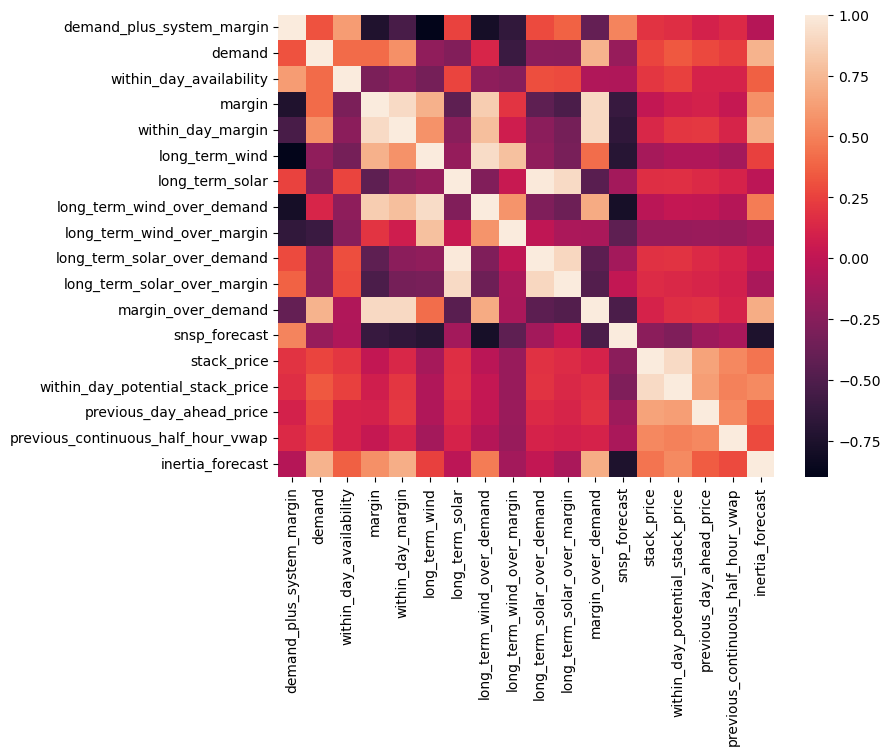

In [20]:
plt.figure(figsize = (8, 6))
sns.heatmap(df_forecast_inputs_train.corr());

A lot of the inputs are derived from eachother and hence show a positive correlation. Margin and availability shows a negative correlation but that is because of how margin and energy generation is signified with negtive values in contrast to demand which is shown with positive values

In [267]:
df_system_prices_train.loc['2021-01-01'].head()

forecast_system_price_low  forecast_system_price_high  \
2021-01-01 00:00:00                      48.33                       44.89   
2021-01-01 01:00:00                      54.35                       53.26   
2021-01-01 02:00:00                      32.66                       65.86   
2021-01-01 03:00:00                      41.55                       63.43   
2021-01-01 04:00:00                      26.62                       66.91   

                     system_price  forecast_system_price_mid  
2021-01-01 00:00:00         73.15                     46.610  
2021-01-01 01:00:00         71.95                     53.805  
2021-01-01 02:00:00         54.56                     49.260  
2021-01-01 03:00:00         70.73                     52.490  
2021-01-01 04:00:00         54.98                     46.765

In [22]:
df_system_prices_train.describe()

forecast_system_price_low  forecast_system_price_high  system_price
count               10127.000000                10127.000000  10139.000000
mean                   61.437701                  146.510825    122.509333
std                   120.348330                   86.416654    146.678788
min                  -300.000000                 -300.000000    -76.070000
25%                    32.250000                   83.785000     62.500000
50%                    52.250000                  121.070000     96.650000
75%                    80.145000                  202.670000    155.500000
max                  2500.000000                 2109.320000   4037.800000

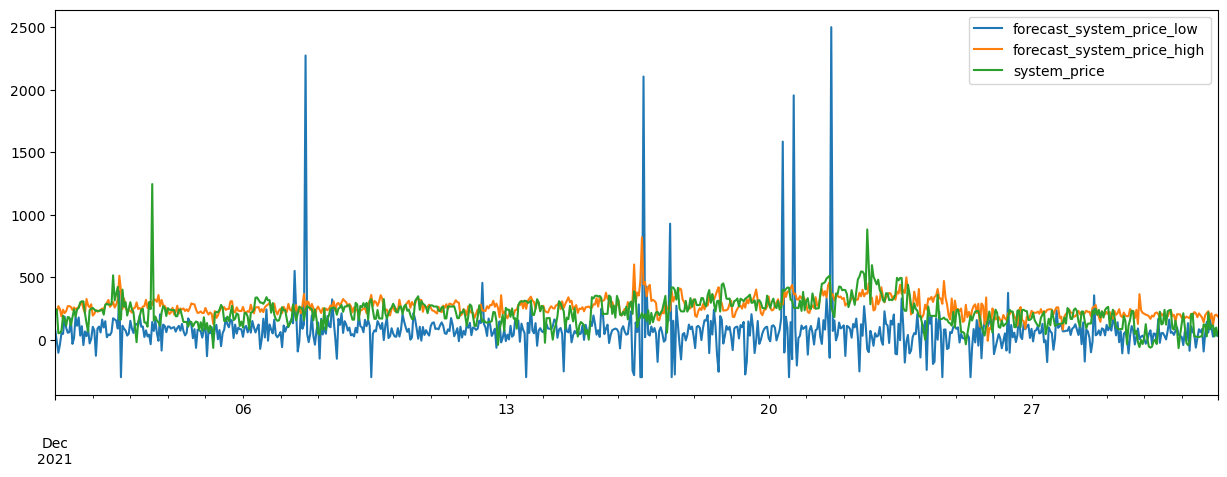

In [23]:
df_system_prices_train.loc['2021-12'].plot(figsize=(15, 5));

<AxesSubplot:>

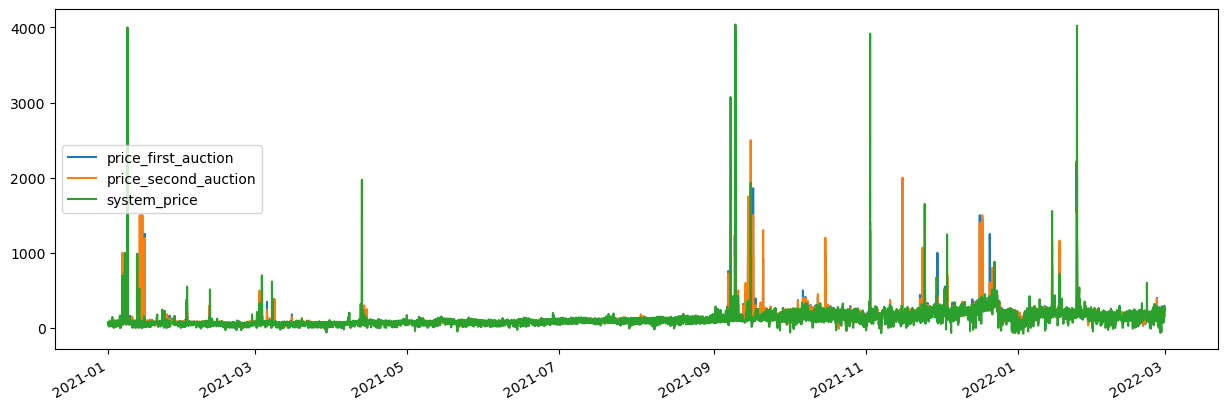

In [24]:
pd.concat([df_auction_data_train, df_system_prices_train], axis=1)[['price_first_auction', 'price_second_auction', 'system_price']].plot(figsize=(15, 5))

## Time features

To further explore the data some time features will be added

In [25]:
def create_time_features(df):
    """
    Create time series features based on time series index
    """
    df = df.copy()
    df['hour'] = df.index.hour
    df['dayofweek'] = df.index.dayofweek # Monday=0, Sunday=6
    df['quarter'] = df.index.quarter
    df['month'] = df.index.month
    df['year'] = df.index.year
    #df['dayofyear'] = df.index.dayofyear
    return df

In [26]:
df_first_auction_data_time_train = create_time_features(df_auction_data_train[['price_first_auction']])
df_second_auction_data_time_train = create_time_features(df_auction_data_train[['price_second_auction']])
df_system_prices_time_train = create_time_features(df_system_prices_train[['system_price']])
df_first_auction_data_time_train

price_first_auction  hour  dayofweek  quarter  month  \
2021-01-01 00:00:00                 68.0     0          4        1      1   
2021-01-01 01:00:00                 62.7     1          4        1      1   
2021-01-01 02:00:00                 56.0     2          4        1      1   
2021-01-01 03:00:00                 50.1     3          4        1      1   
2021-01-01 04:00:00                 50.0     4          4        1      1   
...                                  ...   ...        ...      ...    ...   
2022-02-28 19:00:00                269.0    19          0        1      2   
2022-02-28 20:00:00                214.4    20          0        1      2   
2022-02-28 21:00:00                191.2    21          0        1      2   
2022-02-28 22:00:00                168.8    22          0        1      2   
2022-02-28 23:00:00                192.7    23          0        1      2   

                     year  
2021-01-01 00:00:00  2021  
2021-01-01 01:00:00  2021  
2021-01-01 02:00:00  2021  
2021-01-01 03:00:00  2021  
2021-01-01 04:00:00  2021  
...                   ...  
2022-02-28 19:00:00  2022  
2022-02-28 20:00:00  2022  
2022-02-28 21:00:00  2022  
2022-02-28 22:00:00  2022  
2022-02-28 23:00:00  2022  

[10175 rows x 6 columns]

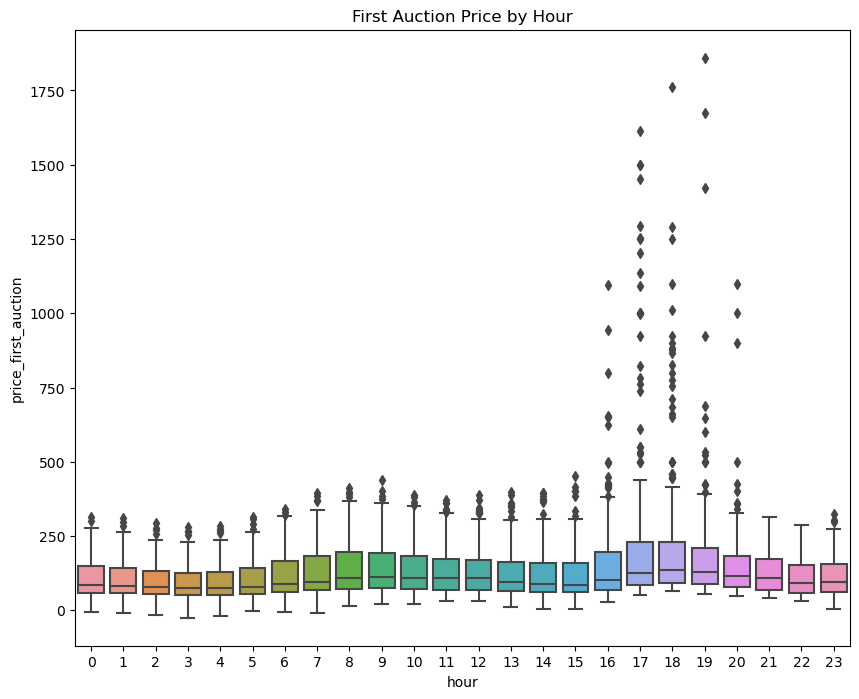

In [27]:
fig, ax = plt.subplots(figsize=(10, 8))
sns.boxplot(data=df_first_auction_data_time_train, x='hour', y='price_first_auction')
ax.set_title('First Auction Price by Hour')
plt.show()

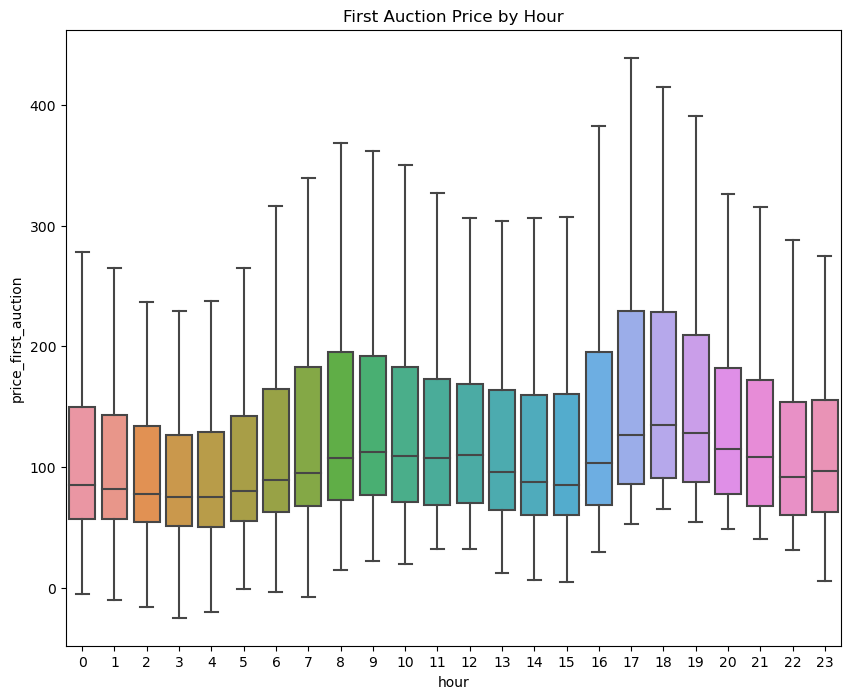

In [28]:
fig, ax = plt.subplots(figsize=(10, 8))
sns.boxplot(data=df_first_auction_data_time_train, x='hour', y='price_first_auction', showfliers=False)
ax.set_title('First Auction Price by Hour')
plt.show()

First Auction Price by hour shows that big Outliers tend to happen in the evening from 4pm - 8pm, with slightly higher average prices in the morning and evening. Second Auction Price also displayed this property as well

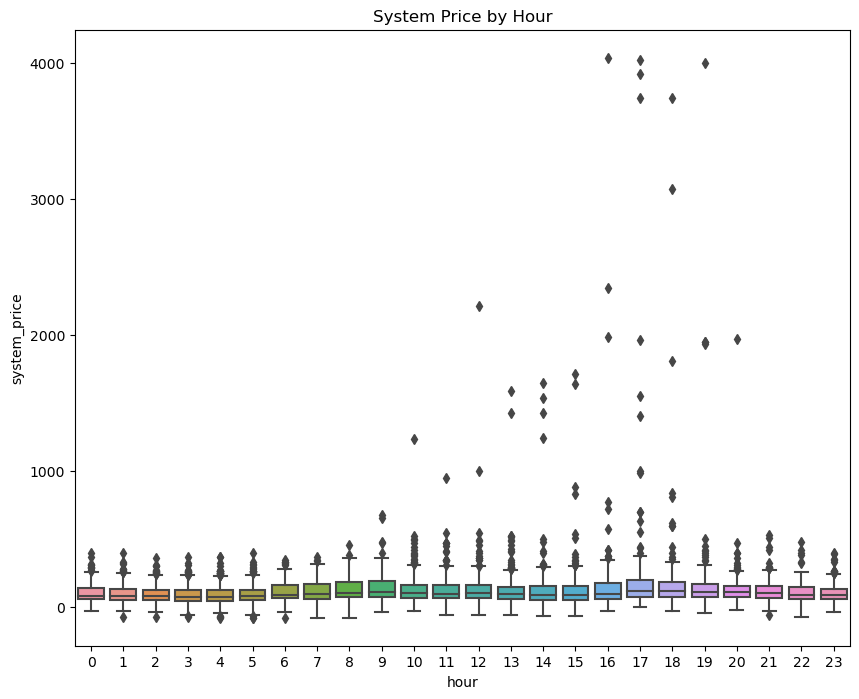

In [29]:
fig, ax = plt.subplots(figsize=(10, 8))
sns.boxplot(data=df_system_prices_time_train, x='hour', y='system_price')
ax.set_title('System Price by Hour')
plt.show()

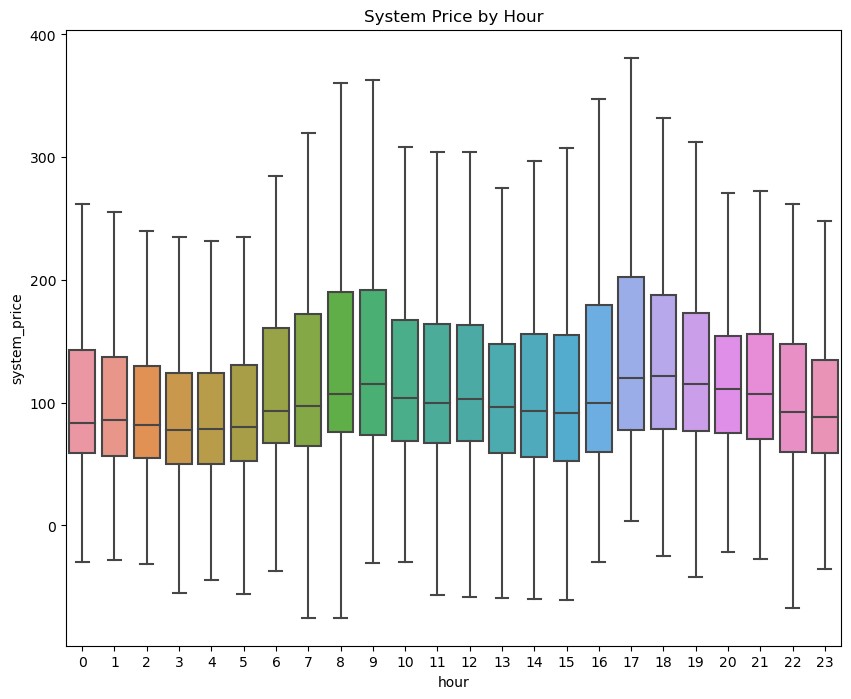

In [30]:
fig, ax = plt.subplots(figsize=(10, 8))
sns.boxplot(data=df_system_prices_time_train, x='hour', y='system_price', showfliers=False)
ax.set_title('System Price by Hour')
plt.show()

System Price big Outliers were more scattered from 9am to 20pm but showed similar average prices in the morning and evening as the First/Second Auction prices

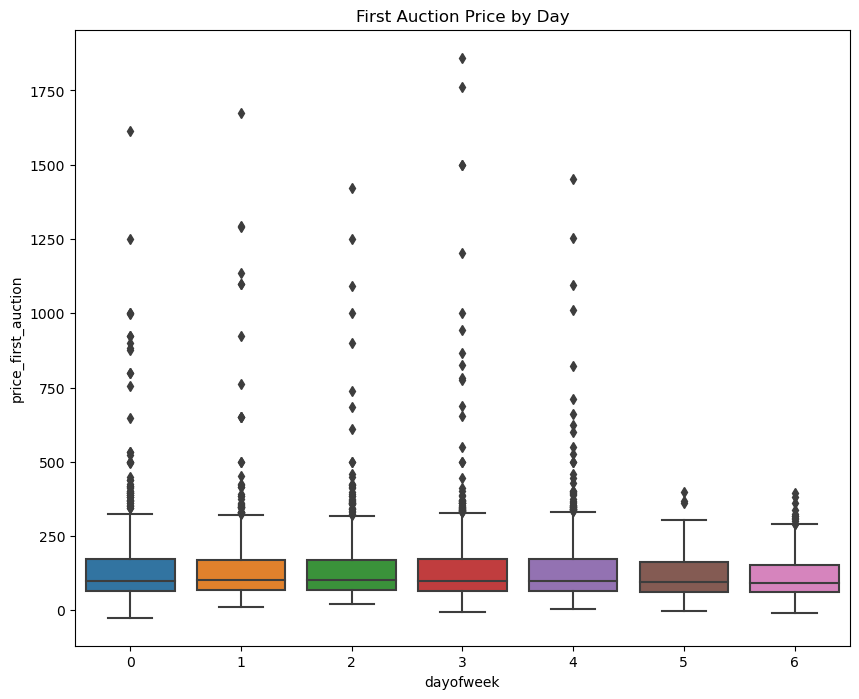

In [31]:
fig, ax = plt.subplots(figsize=(10, 8))
sns.boxplot(data=df_first_auction_data_time_train, x='dayofweek', y='price_first_auction')
ax.set_title('First Auction Price by Day')
plt.show()

Big Outliers tend to appear on a weekday for First (and also Second) Auction Prices

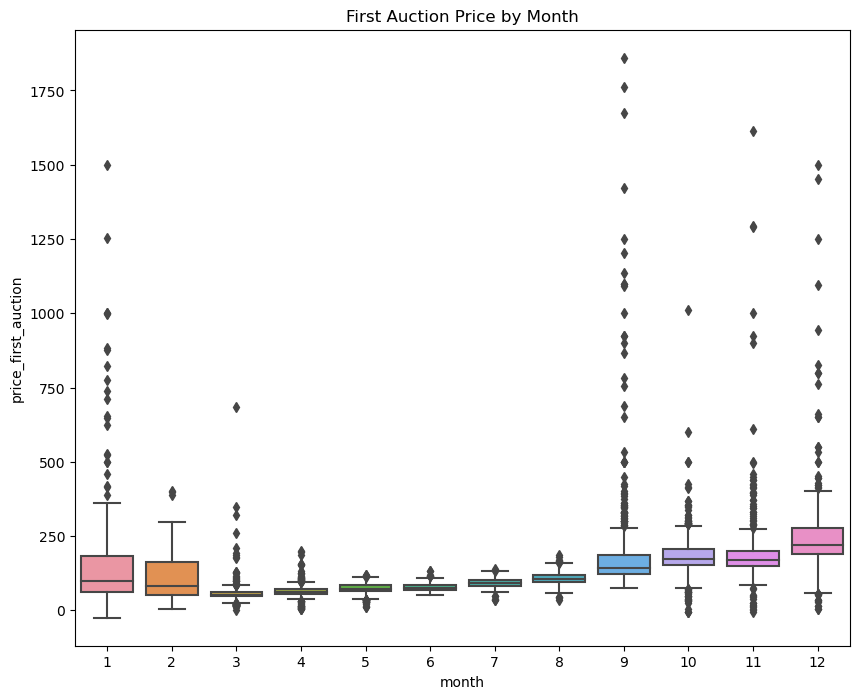

In [32]:
fig, ax = plt.subplots(figsize=(10, 8))
sns.boxplot(data=df_first_auction_data_time_train, x='month', y='price_first_auction')
ax.set_title('First Auction Price by Month')
plt.show()

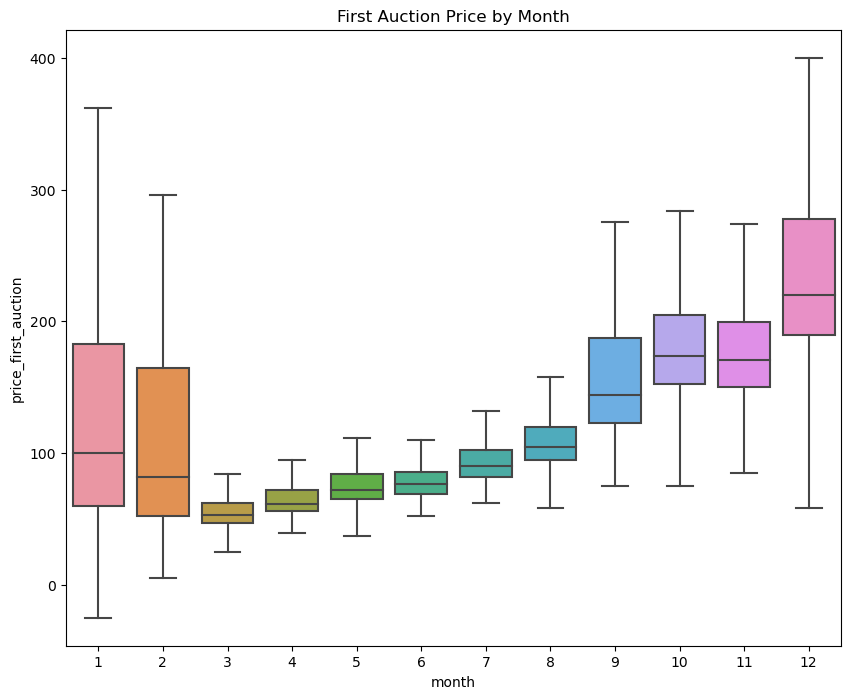

In [33]:
fig, ax = plt.subplots(figsize=(10, 8))
sns.boxplot(data=df_first_auction_data_time_train, x='month', y='price_first_auction', showfliers=False)
ax.set_title('First Auction Price by Month')
plt.show()

For First Auction Prices big Outliers tended to appear in September - January, with larger Inter Quartile ranges and average prices from September to February. Second Auction Prices also displayed this property

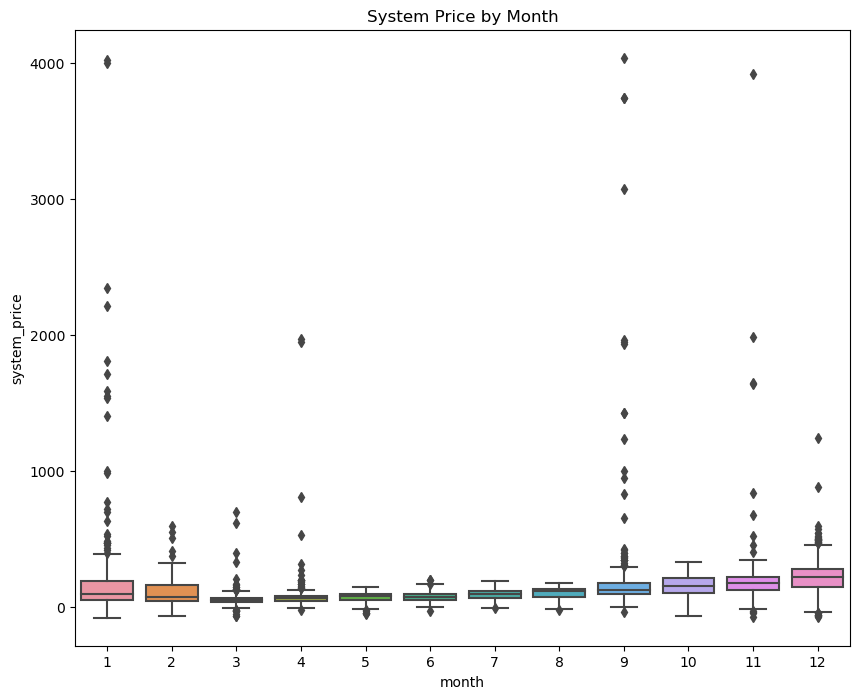

In [34]:
fig, ax = plt.subplots(figsize=(10, 8))
sns.boxplot(data=df_system_prices_time_train, x='month', y='system_price')
ax.set_title('System Price by Month')
plt.show()

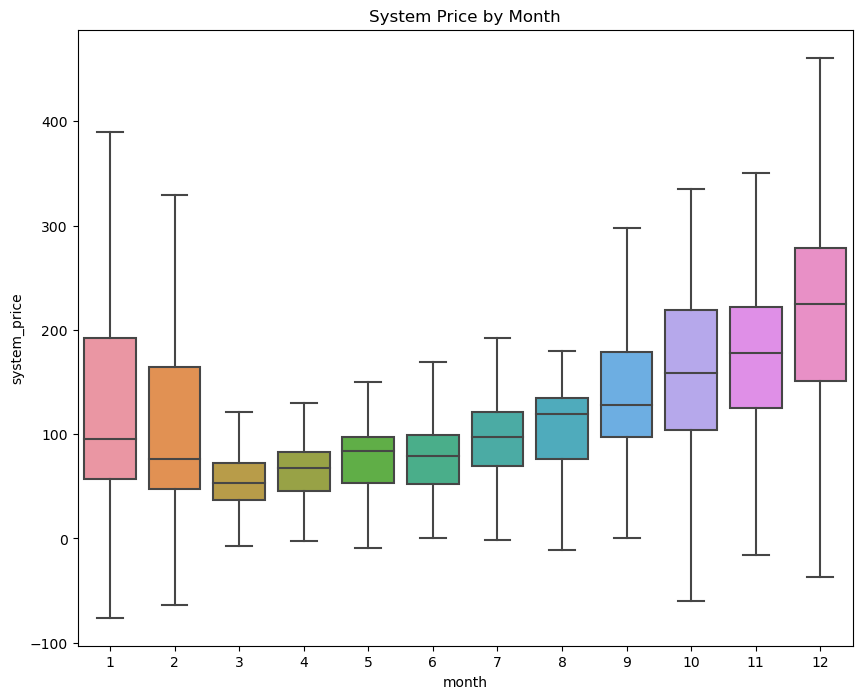

In [35]:
fig, ax = plt.subplots(figsize=(10, 8))
sns.boxplot(data=df_system_prices_time_train, x='month', y='system_price', showfliers=False)
ax.set_title('System Price by Month')
plt.show()

For System Prices big Outliers tended to appear in January, September and November, but showed larger Inter Quartile ranges and average prices from September to February like First/Second Auction prices.

## Exploring the Price deltas

Some exploration of the price deltas between the First and Second Auctions as well as the System Price

In [36]:
df_second_first_auction_delta = create_time_features(pd.DataFrame(df_second_auction_data_time_train['price_second_auction'] - df_first_auction_data_time_train['price_first_auction'], columns=['delta']))
df_second_first_auction_delta['delta'].describe()

count    10175.000000
mean        -0.172990
std         26.265379
min       -646.020000
25%         -3.850000
50%         -0.010000
75%          3.800000
max       1077.810000
Name: delta, dtype: float64

<AxesSubplot:>

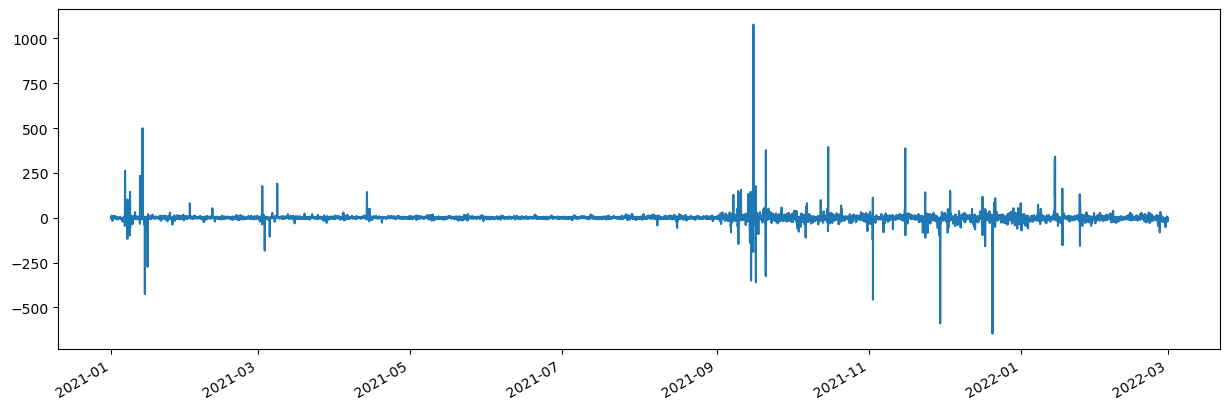

In [37]:
df_second_first_auction_delta['delta'].loc[:].plot(figsize=(15, 5))

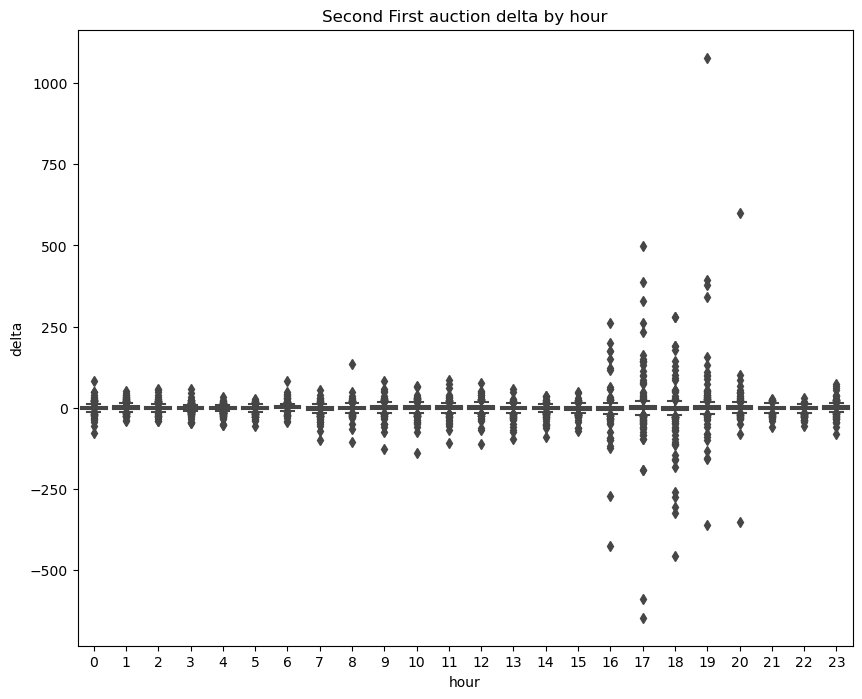

In [38]:
fig, ax = plt.subplots(figsize=(10, 8))
sns.boxplot(data=df_second_first_auction_delta, x='hour', y='delta', showfliers=True)
ax.set_title('Second First auction delta by hour')
plt.show()

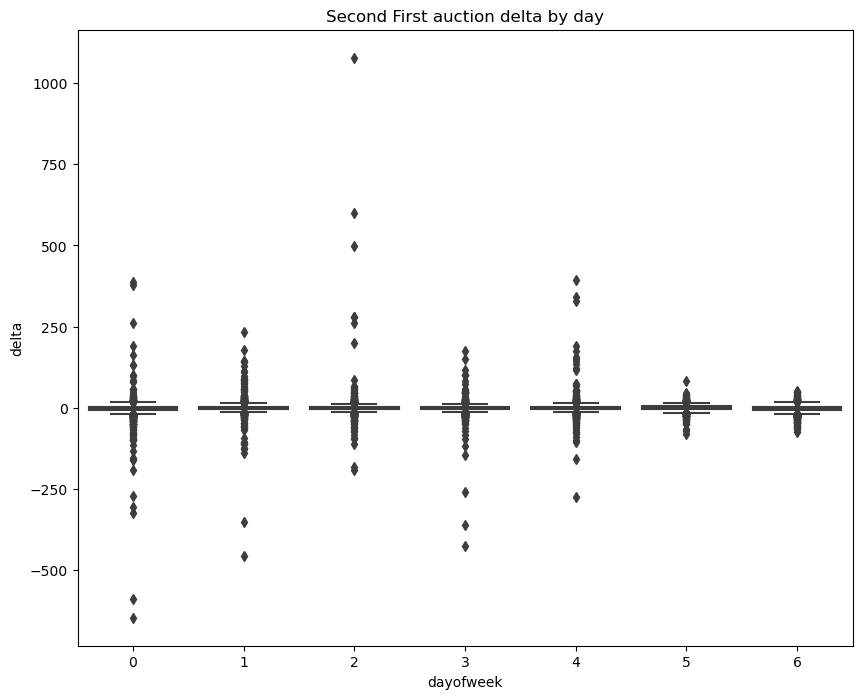

In [39]:
fig, ax = plt.subplots(figsize=(10, 8))
sns.boxplot(data=df_second_first_auction_delta, x='dayofweek', y='delta', showfliers=True)
ax.set_title('Second First auction delta by day')
plt.show()

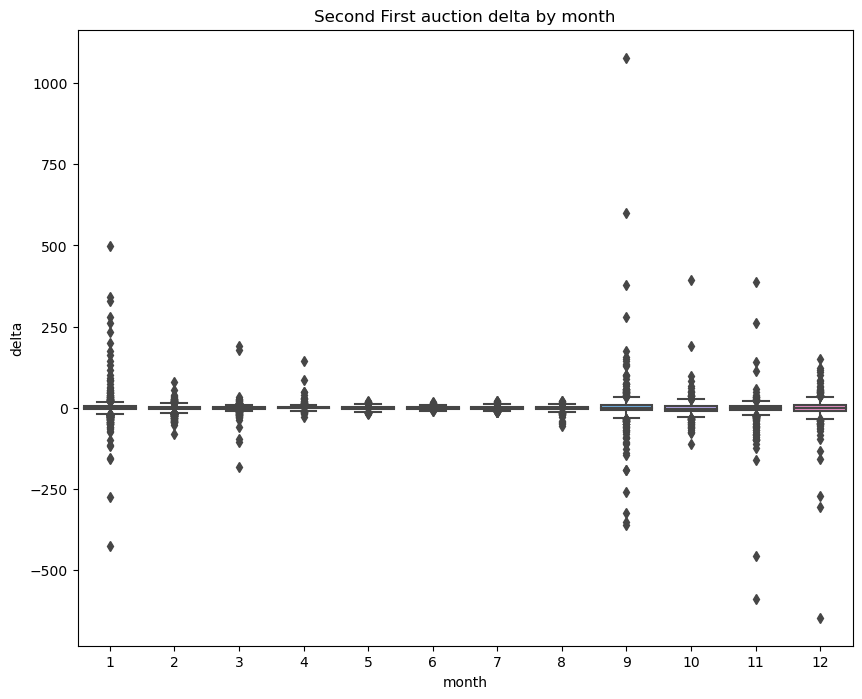

In [40]:
fig, ax = plt.subplots(figsize=(10, 8))
sns.boxplot(data=df_second_first_auction_delta, x='month', y='delta', showfliers=True)
ax.set_title('Second First auction delta by month')
plt.show()

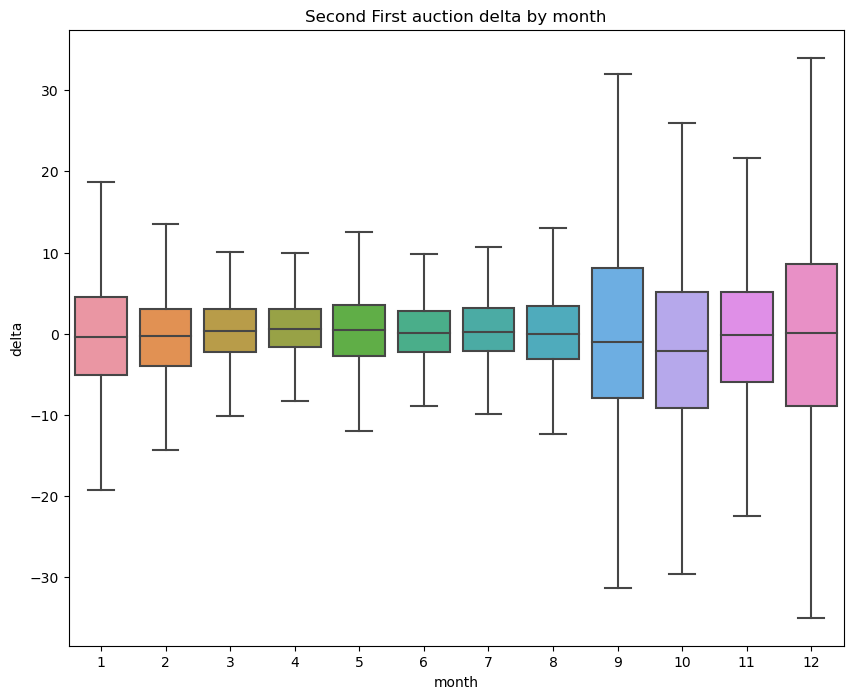

In [109]:
fig, ax = plt.subplots(figsize=(10, 8))
sns.boxplot(data=df_second_first_auction_delta, x='month', y='delta', showfliers=False)
ax.set_title('Second First auction delta by month')
plt.show()

The First and Second auction price deltas showed similar properties to the prices themselves with more larger outliers and greater Interquartile ranges where prices were more volatile (i.e. in the evenings, weekdays and in the Autumn-Winter months)

In [41]:
df_system_price_first_auction_delta = create_time_features(pd.DataFrame(df_system_prices_time_train['system_price'] - df_first_auction_data_time_train['price_first_auction'], columns=['delta']))
df_system_price_first_auction_delta['delta'].describe()

count    10139.000000
mean        -3.383153
std        134.132865
min      -1753.350000
25%        -30.335000
50%          1.600000
75%         25.000000
max       3911.000000
Name: delta, dtype: float64

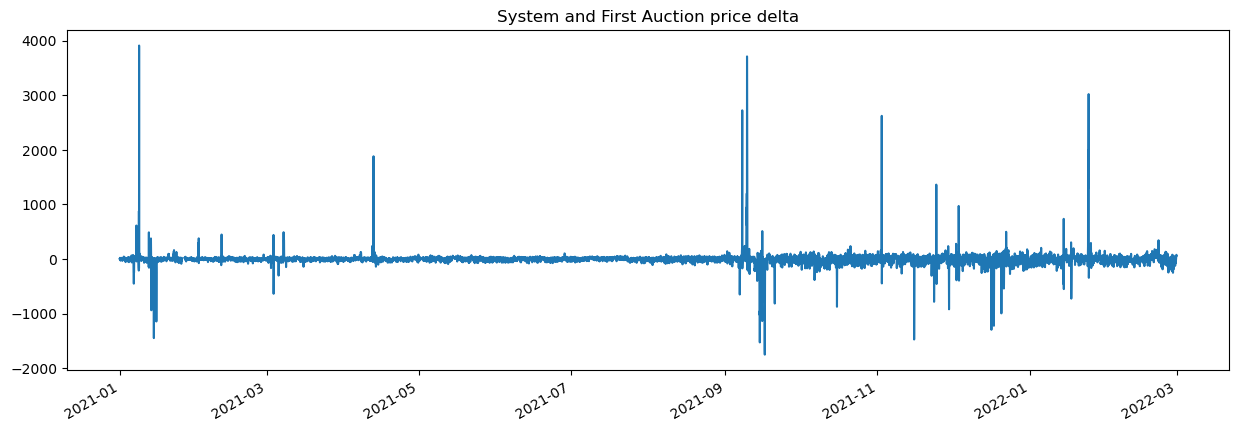

In [42]:
df_system_price_first_auction_delta['delta'].plot(figsize=(15, 5), title='System and First Auction price delta');

In [43]:
df_system_price_second_auction_delta = create_time_features(pd.DataFrame(df_system_prices_time_train['system_price'] - df_second_auction_data_time_train['price_second_auction'], columns=['delta']))
df_system_price_second_auction_delta['delta'].describe()

count    10139.000000
mean        -3.206457
std        133.445769
min      -1863.300000
25%        -29.955000
50%          1.370000
75%         24.785000
max       3909.270000
Name: delta, dtype: float64

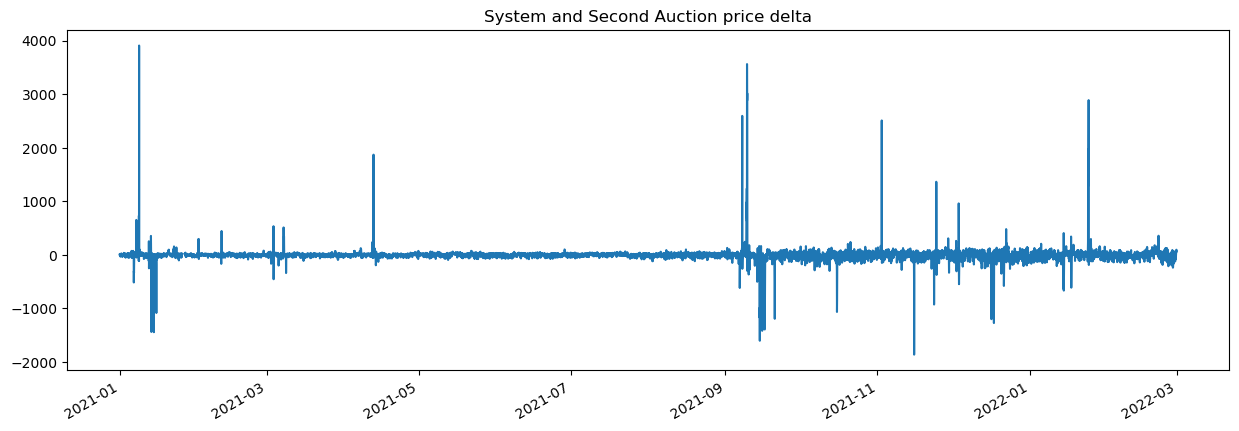

In [44]:
df_system_price_second_auction_delta['delta'].plot(figsize=(15, 5), title='System and Second Auction price delta');

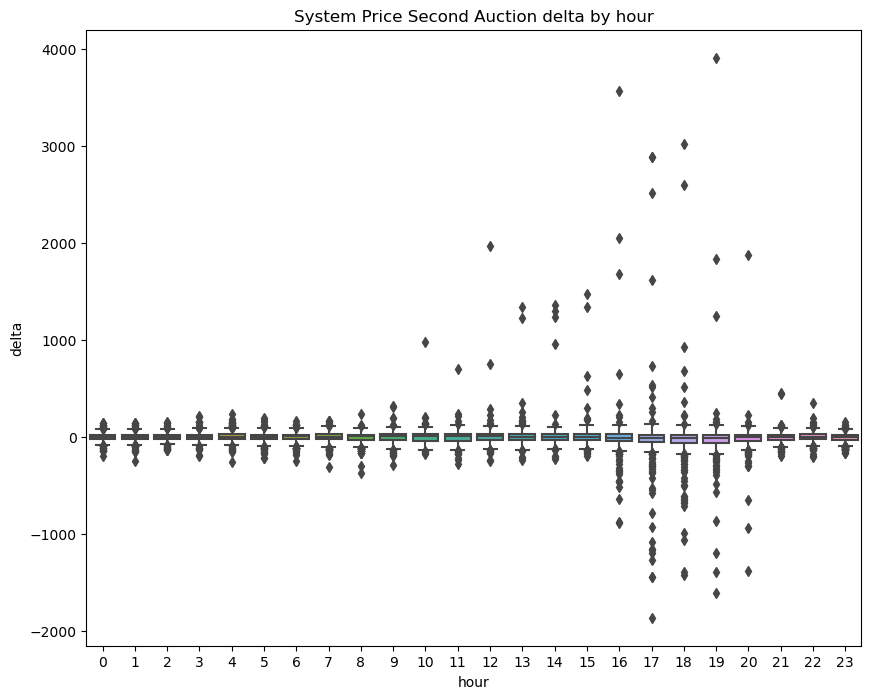

In [45]:
fig, ax = plt.subplots(figsize=(10, 8))
sns.boxplot(data=df_system_price_second_auction_delta, x='hour', y='delta', showfliers=True)
ax.set_title('System Price Second Auction delta by hour')
plt.show()

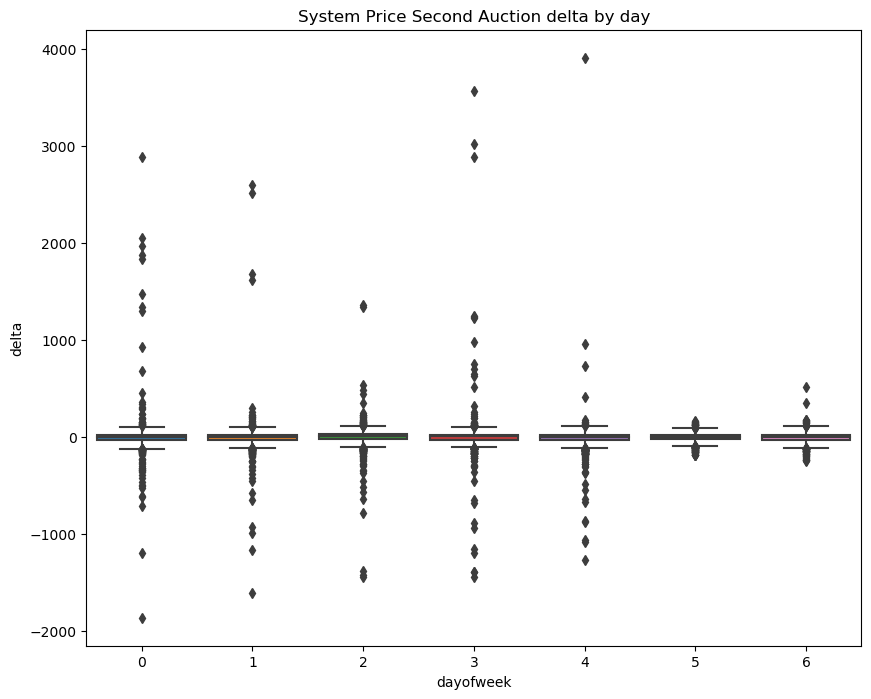

In [46]:
fig, ax = plt.subplots(figsize=(10, 8))
sns.boxplot(data=df_system_price_second_auction_delta, x='dayofweek', y='delta', showfliers=True)
ax.set_title('System Price Second Auction delta by day')
plt.show()

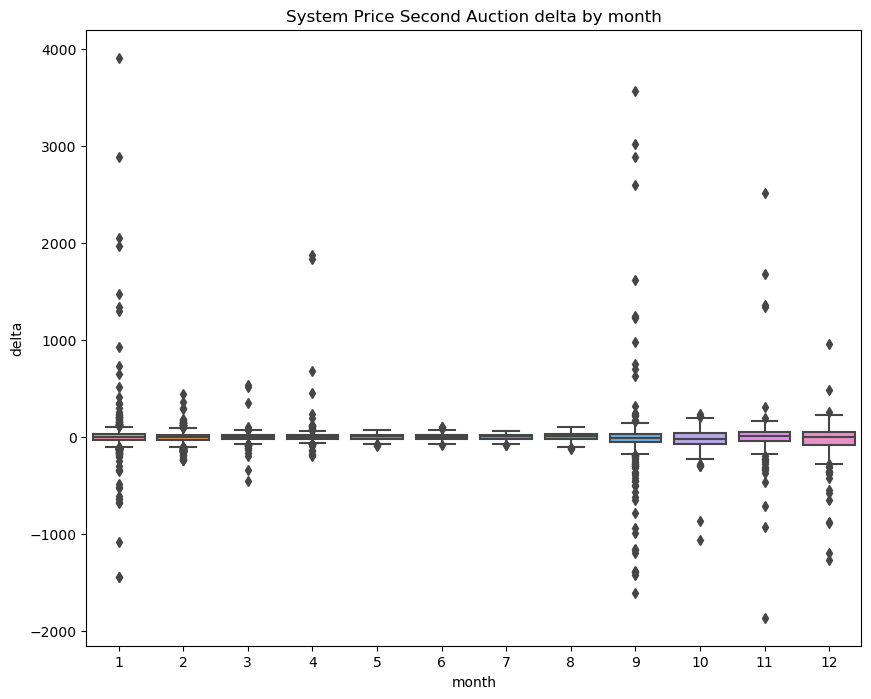

In [47]:
fig, ax = plt.subplots(figsize=(10, 8))
sns.boxplot(data=df_system_price_second_auction_delta, x='month', y='delta', showfliers=True)
ax.set_title('System Price Second Auction delta by month')
plt.show()

Again the System-Auction price deltas also show similar properties to the prices themselves

## Create Forecast Input time features for modelling

In [48]:
df_forecast_inputs_time_train = create_time_features(df_forecast_inputs_train)
df_forecast_inputs_time_train.head()

demand_plus_system_margin   demand  \
2021-01-01 00:00:00                   56513.64  30182.0   
2021-01-01 01:00:00                   56506.94  29269.0   
2021-01-01 02:00:00                   56502.20  27245.0   
2021-01-01 03:00:00                   56487.24  25545.5   
2021-01-01 04:00:00                   56373.63  24180.0   

                     within_day_availability    margin  within_day_margin  \
2021-01-01 00:00:00                 40389.06 -26331.64          -15268.70   
2021-01-01 01:00:00                 40389.06 -27237.94          -16191.00   
2021-01-01 02:00:00                 40389.06 -29257.20          -18226.26   
2021-01-01 03:00:00                 40389.06 -30941.74          -19935.30   
2021-01-01 04:00:00                 40389.06 -32193.63          -21212.69   

                     long_term_wind  long_term_solar  \
2021-01-01 00:00:00        -3674.64              0.0   
2021-01-01 01:00:00        -3667.94              0.0   
2021-01-01 02:00:00        -3663.20              0.0   
2021-01-01 03:00:00        -3648.24              0.0   
2021-01-01 04:00:00        -3534.63              0.0   

                     long_term_wind_over_demand  long_term_wind_over_margin  \
2021-01-01 00:00:00                         -12                         -14   
2021-01-01 01:00:00                         -13                         -14   
2021-01-01 02:00:00                         -14                         -13   
2021-01-01 03:00:00                         -15                         -12   
2021-01-01 04:00:00                         -15                         -11   

                     long_term_solar_over_demand  ...  stack_price  \
2021-01-01 00:00:00                          0.0  ...        67.79   
2021-01-01 01:00:00                          0.0  ...        67.79   
2021-01-01 02:00:00                          0.0  ...        67.73   
2021-01-01 03:00:00                          0.0  ...        67.61   
2021-01-01 04:00:00                          0.0  ...        66.48   

                     within_day_potential_stack_price  \
2021-01-01 00:00:00                             68.88   
2021-01-01 01:00:00                             68.45   
2021-01-01 02:00:00                             67.79   
2021-01-01 03:00:00                             67.73   
2021-01-01 04:00:00                             67.67   

                     previous_day_ahead_price  \
2021-01-01 00:00:00                     65.02   
2021-01-01 01:00:00                     62.00   
2021-01-01 02:00:00                     54.16   
2021-01-01 03:00:00                     51.94   
2021-01-01 04:00:00                     49.17   

                     previous_continuous_half_hour_vwap  inertia_forecast  \
2021-01-01 00:00:00                               59.69            214.67   
2021-01-01 01:00:00                               51.86            205.47   
2021-01-01 02:00:00                               46.29            191.12   
2021-01-01 03:00:00                               54.22            176.23   
2021-01-01 04:00:00                               57.26            163.59   

                     hour  dayofweek  quarter  month  year  
2021-01-01 00:00:00     0          4        1      1  2021  
2021-01-01 01:00:00     1          4        1      1  2021  
2021-01-01 02:00:00     2          4        1      1  2021  
2021-01-01 03:00:00     3          4        1      1  2021  
2021-01-01 04:00:00     4          4        1      1  2021  

[5 rows x 23 columns]

In [49]:
df_forecast_inputs_time_test = create_time_features(df_forecast_inputs_test)
df_forecast_inputs_time_test.head()

demand_plus_system_margin   demand  \
2022-03-01 00:00:00                   52262.56  27101.0   
2022-03-01 01:00:00                   51885.03  26314.0   
2022-03-01 02:00:00                   51599.91  25508.0   
2022-03-01 03:00:00                   51358.41  24790.0   
2022-03-01 04:00:00                   51134.11  24587.5   

                     within_day_availability    margin  within_day_margin  \
2022-03-01 00:00:00                 32952.87 -25161.56          -11942.43   
2022-03-01 01:00:00                 32952.87 -25571.03          -12305.90   
2022-03-01 02:00:00                 32952.87 -26091.91          -12817.28   
2022-03-01 03:00:00                 32952.87 -26568.41          -13299.78   
2022-03-01 04:00:00                 32952.87 -26546.61          -13274.98   

                     long_term_wind  long_term_solar  \
2022-03-01 00:00:00        -4699.56              0.0   
2022-03-01 01:00:00        -4322.03              0.0   
2022-03-01 02:00:00        -4036.91              0.0   
2022-03-01 03:00:00        -3795.41              0.0   
2022-03-01 04:00:00        -3571.11              0.0   

                     long_term_wind_over_demand  long_term_wind_over_margin  \
2022-03-01 00:00:00                         -18                         -19   
2022-03-01 01:00:00                         -17                         -17   
2022-03-01 02:00:00                         -16                         -16   
2022-03-01 03:00:00                         -15                         -15   
2022-03-01 04:00:00                         -15                         -14   

                     long_term_solar_over_demand  ...  stack_price  \
2022-03-01 00:00:00                          0.0  ...       199.01   
2022-03-01 01:00:00                          0.0  ...       198.18   
2022-03-01 02:00:00                          0.0  ...       205.10   
2022-03-01 03:00:00                          0.0  ...       201.25   
2022-03-01 04:00:00                          0.0  ...       206.10   

                     within_day_potential_stack_price  \
2022-03-01 00:00:00                             205.9   
2022-03-01 01:00:00                             205.4   
2022-03-01 02:00:00                             206.1   
2022-03-01 03:00:00                             206.1   
2022-03-01 04:00:00                             206.5   

                     previous_day_ahead_price  \
2022-03-01 00:00:00                     179.6   
2022-03-01 01:00:00                     176.0   
2022-03-01 02:00:00                     160.0   
2022-03-01 03:00:00                     163.3   
2022-03-01 04:00:00                     175.0   

                     previous_continuous_half_hour_vwap  inertia_forecast  \
2022-03-01 00:00:00                              131.63            204.28   
2022-03-01 01:00:00                              133.90            199.69   
2022-03-01 02:00:00                              101.93            217.32   
2022-03-01 03:00:00                              110.82            210.18   
2022-03-01 04:00:00                              140.93            228.65   

                     hour  dayofweek  quarter  month  year  
2022-03-01 00:00:00     0          1        1      3  2022  
2022-03-01 01:00:00     1          1        1      3  2022  
2022-03-01 02:00:00     2          1        1      3  2022  
2022-03-01 03:00:00     3          1        1      3  2022  
2022-03-01 04:00:00     4          1        1      3  2022  

[5 rows x 23 columns]

In [50]:
FEATURES = ['demand_plus_system_margin', 'demand', 'within_day_availability', 'margin', 'within_day_margin', 'long_term_wind', 'long_term_solar', 'long_term_wind_over_demand', 'long_term_wind_over_margin', 'long_term_solar_over_demand', \
            'long_term_solar_over_margin', 'margin_over_demand', 'snsp_forecast', 'stack_price', 'within_day_potential_stack_price', 'previous_day_ahead_price', 'previous_continuous_half_hour_vwap', 'inertia_forecast', \
            'hour', 'dayofweek', 'quarter', 'month', 'year']
TARGET = 'price_second_auction'

In [51]:
X_train = df_forecast_inputs_time_train[FEATURES]
y_train = df_auction_data_train[TARGET]

X_test = df_forecast_inputs_time_test[FEATURES]
y_test = df_auction_data_test[TARGET]

In [52]:
tss = TimeSeriesSplit(n_splits=12, test_size=24*30) # each fold is 30 days in the Cross Validation Split

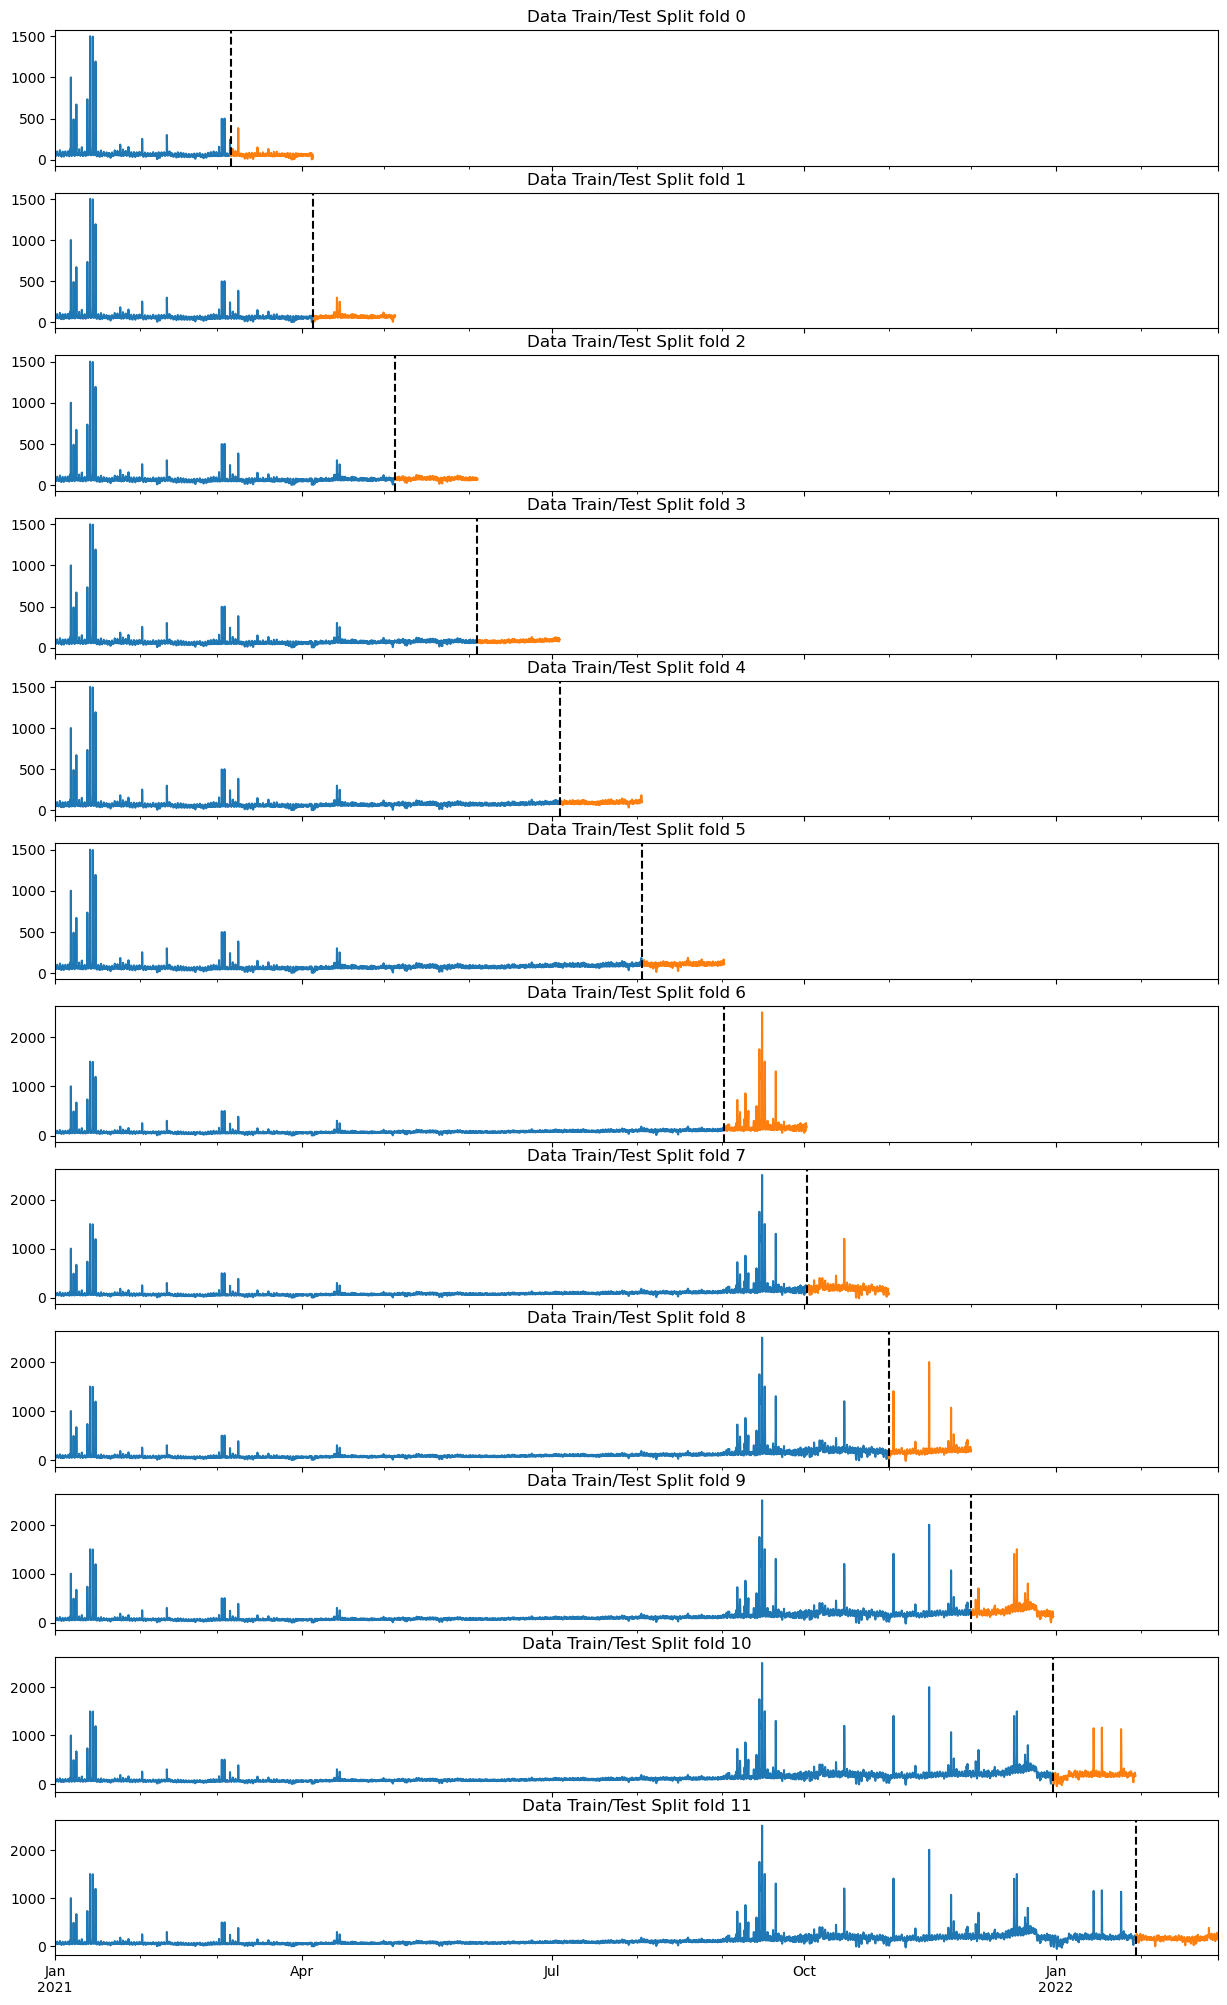

In [53]:
fig, axs = plt.subplots(12, 1, figsize=(15, 25), sharex=True)

fold = 0
for train_i, val_i in tss.split(y_train):
    train = y_train.iloc[train_i]
    test = y_train.iloc[val_i]

    train.plot(ax=axs[fold], label='Training Set', title=f'Data Train/Test Split fold {fold}')
    test.plot(ax=axs[fold], label='Test Set')
    axs[fold].axvline(test.index.min(), color='black', ls='--')

    fold += 1
plt.show()

# Feature Engineering

In most markets the prices are generally correlated to the previous time iterations. Because of this a `previous_day_ahead_second_price` (like the `previous_day_ahead_first_price`) feature was created, as well as previous hour features for the first and second auctions (`previous_hour_first_price` and `previous_hour_second_price` respectively)

In [54]:
# Add 'previous_day_ahead_second_price', 'previous_hour_first_price' and 'previous_hour_second_price' features
def create_historic_price_features(df):
    for i in df.index:
        i_prev_day = i - pd.DateOffset(days=1)
        try:
            df.loc[i, 'previous_day_ahead_second_price'] = float(df_auction_data.loc[i_prev_day]['price_second_auction'])
        except:
            try: # for missing indexes try adding the value the hour before
                df.loc[i, 'previous_day_ahead_second_price'] = float(df_auction_data.loc[i_prev_day - pd.DateOffset(hours=1)]['price_second_auction'])
            except: # for the first day assign NaN value
                df.loc[i, 'previous_day_ahead_second_price'] = float('nan')

        i_prev_hour = i - pd.DateOffset(hours=1)
        try:
            df.loc[i, 'previous_hour_first_price'] = float(df_auction_data.loc[i_prev_hour]['price_first_auction'])
            df.loc[i, 'previous_hour_second_price'] = float(df_auction_data.loc[i_prev_hour]['price_second_auction'])
        except:
            try: # for missing indexes try adding the value the hour before
                df.loc[i, 'previous_hour_first_price'] = float(df_auction_data.loc[i_prev_hour - pd.DateOffset(hours=1)]['price_first_auction'])
                df.loc[i, 'previous_hour_second_price'] = float(df_auction_data.loc[i_prev_hour - pd.DateOffset(hours=1)]['price_second_auction'])
            except: # for the first hour assign NaN value
                df.loc[i, 'previous_hour_first_price'] = float('nan')
                df.loc[i, 'previous_hour_second_price'] = float('nan')
    df = df[~df['previous_day_ahead_second_price'].isna() & ~df['previous_hour_first_price'].isna() & ~df['previous_hour_second_price'].isna()] # remove data without these historic features (i.e. first day of train set)

    return df

# Modelling for a price forecast for the Second Auction

In [55]:
X_train = create_historic_price_features(X_train)
X_test = create_historic_price_features(X_test)

y_train = y_train.loc[X_train.index] # adjust for removed entries from feature engineering
y_test = y_test.loc[X_test.index]

In [56]:
params = {
    'max_depth': [1, 2, 3, 6, 10],
    'learning_rate': [0.01, 0.05, 0.1],
    'n_estimators': [100, 200, 500, 1000]
}

xgbr = xgb.XGBRegressor(random_state=42)

cv = tss.split(X_train)

clf = GridSearchCV(
    estimator=xgbr, 
    param_grid=params,
    scoring='neg_root_mean_squared_error', 
    verbose=3,
    cv=cv
    
)
clf.fit(X_train, y_train)

Fitting 12 folds for each of 60 candidates, totalling 720 fits
[CV 1/12] END learning_rate=0.01, max_depth=1, n_estimators=100;, score=-25.759 total time=   0.3s
[CV 2/12] END learning_rate=0.01, max_depth=1, n_estimators=100;, score=-37.355 total time=   0.5s
[CV 3/12] END learning_rate=0.01, max_depth=1, n_estimators=100;, score=-38.796 total time=   0.5s
[CV 4/12] END learning_rate=0.01, max_depth=1, n_estimators=100;, score=-41.837 total time=   0.4s
[CV 5/12] END learning_rate=0.01, max_depth=1, n_estimators=100;, score=-54.817 total time=   0.4s
[CV 6/12] END learning_rate=0.01, max_depth=1, n_estimators=100;, score=-64.166 total time=   0.4s
[CV 7/12] END learning_rate=0.01, max_depth=1, n_estimators=100;, score=-207.208 total time=   0.6s
[CV 8/12] END learning_rate=0.01, max_depth=1, n_estimators=100;, score=-116.784 total time=   0.4s
[CV 9/12] END learning_rate=0.01, max_depth=1, n_estimators=100;, score=-132.806 total time=   0.5s
[CV 10/12] END learning_rate=0.01, max_dept

GridSearchCV(cv=<generator object TimeSeriesSplit.split at 0x150589d90>,
             estimator=XGBRegressor(base_score=None, booster=None,
                                    callbacks=None, colsample_bylevel=None,
                                    colsample_bynode=None,
                                    colsample_bytree=None,
                                    early_stopping_rounds=None,
                                    enable_categorical=False, eval_metric=None,
                                    feature_types=None, gamma=None, gpu_id=None,
                                    grow_policy=None, importance_type=None...
                                    max_cat_to_onehot=None, max_delta_step=None,
                                    max_depth=None, max_leaves=None,
                                    min_child_weight=None, missing=nan,
                                    monotone_constraints=None, n_estimators=100,
                                    n_jobs=None, num_parallel_tree=None,
                                    predictor=None, random_state=42, ...),
             param_grid={'learning_rate': [0.01, 0.05, 0.1],
                         'max_depth': [1, 2, 3, 6, 10],
                         'n_estimators': [100, 200, 500, 1000]},
             scoring='neg_root_mean_squared_error', verbose=3)

In [57]:
xgbr_best = clf.best_estimator_
print(clf.best_params_)

{'learning_rate': 0.1, 'max_depth': 1, 'n_estimators': 200}


In [58]:
pd.DataFrame(clf.cv_results_).sort_values('rank_test_score').head(15)

mean_fit_time  std_fit_time  mean_score_time  std_score_time  \
41       0.228080      0.052152         0.001420        0.000132   
22       0.711159      0.175826         0.002329        0.000624   
40       0.119851      0.026496         0.001289        0.000145   
21       0.293416      0.083548         0.001618        0.000363   
3        1.800631      0.406764         0.003600        0.003536   
6        1.381348      0.381404         0.003341        0.001759   
24       0.211381      0.045504         0.001660        0.000353   
42       0.577700      0.133032         0.002049        0.000416   
23       1.449983      0.430458         0.002879        0.000460   
43       1.137494      0.331622         0.002673        0.000621   
52       0.518069      0.140491         0.001899        0.000355   
53       1.131715      0.291584         0.002525        0.000402   
54       3.100836      1.308707         0.005261        0.003561   
55       5.638059      1.385809         0.005631        0.001811   
7        2.843860      0.779358         0.003417        0.001233   

   param_learning_rate param_max_depth param_n_estimators  \
41                 0.1               1                200   
22                0.05               1                500   
40                 0.1               1                100   
21                0.05               1                200   
3                 0.01               1               1000   
6                 0.01               2                500   
24                0.05               2                100   
42                 0.1               1                500   
23                0.05               1               1000   
43                 0.1               1               1000   
52                 0.1               6                100   
53                 0.1               6                200   
54                 0.1               6                500   
55                 0.1               6               1000   
7                 0.01               2               1000   

                                               params  split0_test_score  \
41  {'learning_rate': 0.1, 'max_depth': 1, 'n_esti...         -15.340621   
22  {'learning_rate': 0.05, 'max_depth': 1, 'n_est...         -15.132543   
40  {'learning_rate': 0.1, 'max_depth': 1, 'n_esti...         -16.858279   
21  {'learning_rate': 0.05, 'max_depth': 1, 'n_est...         -16.983869   
3   {'learning_rate': 0.01, 'max_depth': 1, 'n_est...         -17.089194   
6   {'learning_rate': 0.01, 'max_depth': 2, 'n_est...         -14.769366   
24  {'learning_rate': 0.05, 'max_depth': 2, 'n_est...         -14.815463   
42  {'learning_rate': 0.1, 'max_depth': 1, 'n_esti...         -14.101527   
23  {'learning_rate': 0.05, 'max_depth': 1, 'n_est...         -14.214758   
43  {'learning_rate': 0.1, 'max_depth': 1, 'n_esti...         -13.466072   
52  {'learning_rate': 0.1, 'max_depth': 6, 'n_esti...         -12.220149   
53  {'learning_rate': 0.1, 'max_depth': 6, 'n_esti...         -12.291370   
54  {'learning_rate': 0.1, 'max_depth': 6, 'n_esti...         -12.316918   
55  {'learning_rate': 0.1, 'max_depth': 6, 'n_esti...         -12.318459   
7   {'learning_rate': 0.01, 'max_depth': 2, 'n_est...         -13.331721   

    split1_test_score  ...  split5_test_score  split6_test_score  \
41         -23.152726  ...         -14.243721        -142.450797   
22         -24.595223  ...         -12.252968        -143.771942   
40         -20.418684  ...         -17.416238        -146.152284   
21         -20.079812  ...         -15.758071        -147.000644   
3          -19.981728  ...         -16.709976        -147.000358   
6          -17.074371  ...         -15.007718        -156.997925   
24         -17.084686  ...         -14.764973        -157.885000   
42         -30.217579  ...         -11.370778        -145.929816   
23         -30.373511  ...         -11.100794        -146.409738   
43         -33.412614  ...         -10.53

Check the Root Mean Squared error for both train and test sets. As a reference also check the Root Mean Squared error for the given First Price Forecasts

In [59]:
score = mean_squared_error(y_train, xgbr_best.predict(X_train), squared=False)
print(f'RMSE Score on Train set: {score:0.2f}')

score = mean_squared_error(y_test, xgbr_best.predict(X_test), squared=False)
print(f'RMSE Score on Test set: {score:0.2f}')
print('---')

df_auction_data_train_with_forecast = df_auction_data_train[df_auction_data_train['price_forecast_first_auction'].notna()]
score = mean_squared_error(df_auction_data_train_with_forecast['price_first_auction'], df_auction_data_train_with_forecast['price_forecast_first_auction'], squared=False)
print(f'RMSE Score on given First Price Forecast Train set: {score:0.2f}')

score = mean_squared_error(df_auction_data_test['price_first_auction'], df_auction_data_test['price_forecast_first_auction'], squared=False)
print(f'RMSE Score on given First Price Forecast Test set: {score:0.2f}')

RMSE Score on Train set: 40.14
RMSE Score on Test set: 30.38
---
RMSE Score on given First Price Forecast Train set: 59.84
RMSE Score on given First Price Forecast Test set: 43.77


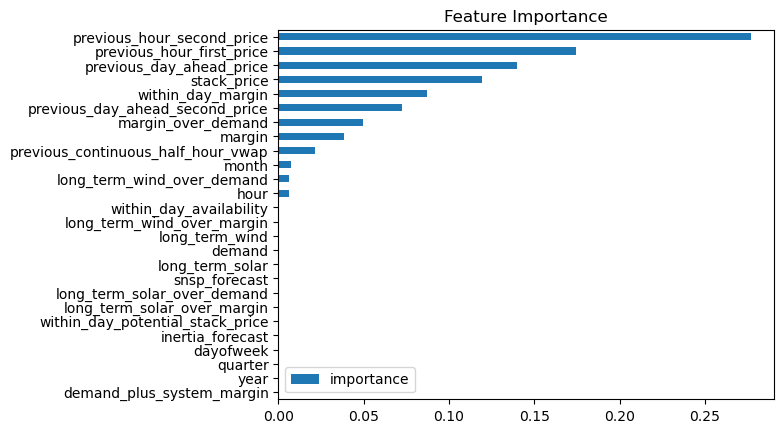

In [60]:
pd.DataFrame(data=xgbr_best.feature_importances_, index=xgbr_best.feature_names_in_, columns=['importance']).sort_values('importance').plot(kind='barh', title='Feature Importance')
plt.show()

The historic price features are shown as the most important in determining the forecast price in this model

In [61]:
df_auction_data_train = df_auction_data_train.loc[X_train.index] # adjust for removed entries from feature engineering
df_auction_data_train['price_forecast_second_auction'] = xgbr_best.predict(X_train)
df_auction_data_train

price_first_auction  price_second_auction  \
2021-01-02 00:00:00                 64.0                 63.91   
2021-01-02 01:00:00                 58.0                 66.12   
2021-01-02 02:00:00                 50.0                 59.28   
2021-01-02 03:00:00                 50.0                 54.96   
2021-01-02 04:00:00                 45.5                 49.65   
...                                  ...                   ...   
2022-02-28 19:00:00                269.0                264.54   
2022-02-28 20:00:00                214.4                217.25   
2022-02-28 21:00:00                191.2                195.39   
2022-02-28 22:00:00                168.8                148.80   
2022-02-28 23:00:00                192.7                190.00   

                     traded_volume_first_auction  \
2021-01-02 00:00:00                       3260.2   
2021-01-02 01:00:00                       3265.2   
2021-01-02 02:00:00                       3327.1   
2021-01-02 03:00:00                       3668.6   
2021-01-02 04:00:00                       3900.3   
...                                          ...   
2022-02-28 19:00:00                       6046.2   
2022-02-28 20:00:00                       5628.9   
2022-02-28 21:00:00                       5685.2   
2022-02-28 22:00:00                       5565.1   
2022-02-28 23:00:00                       3669.1   

                     traded_volume_second_auction  \
2021-01-02 00:00:00                        3763.0   
2021-01-02 01:00:00                        3898.3   
2021-01-02 02:00:00                        3408.2   
2021-01-02 03:00:00                        3388.5   
2021-01-02 04:00:00                        3925.1   
...                                           ...   
2022-02-28 19:00:00                       13289.5   
2022-02-28 20:00:00                       12196.3   
2022-02-28 21:00:00                       11186.4   
2022-02-28 22:00:00                       11440.8   
2022-02-28 23:00:00                        9059.3   

                     price_forecast_first_auction  \
2021-01-02 00:00:00                         61.32   
2021-01-02 01:00:00                         61.41   
2021-01-02 02:00:00                         56.98   
2021-01-02 03:00:00                         56.04   
2021-01-02 04:00:00                         50.45   
...                                           ...   
2022-02-28 19:00:00                        235.99   
2022-02-28 20:00:00                        214.67   
2022-02-28 21:00:00                        206.65   
2022-02-28 22:00:00                        185.69   
2022-02-28 23:00:00                        201.02   

                     price_forecast_second_auction  
2021-01-02 00:00:00                      62.174038  
2021-01-02 01:00:00                      64.573357  
2021-01-02 02:00:00                      62.301605  
2021-01-02 03:00:00                      58.717190  
2021-01-02 04:00:00                      58.717190  
...                                            ...  
2022-02-28 19:00:00                     258.587494  
2022-02-28 20:00:00                     240.572510  
2022-02-28 21:00:00                     201.107376  
2022-02-28 22:00:00                     182.885391  
2022-02-28 23:00:00                     154.994919  

[10151 rows x 6 columns]

## Plotting some graphs to compare the predictions with the actual data

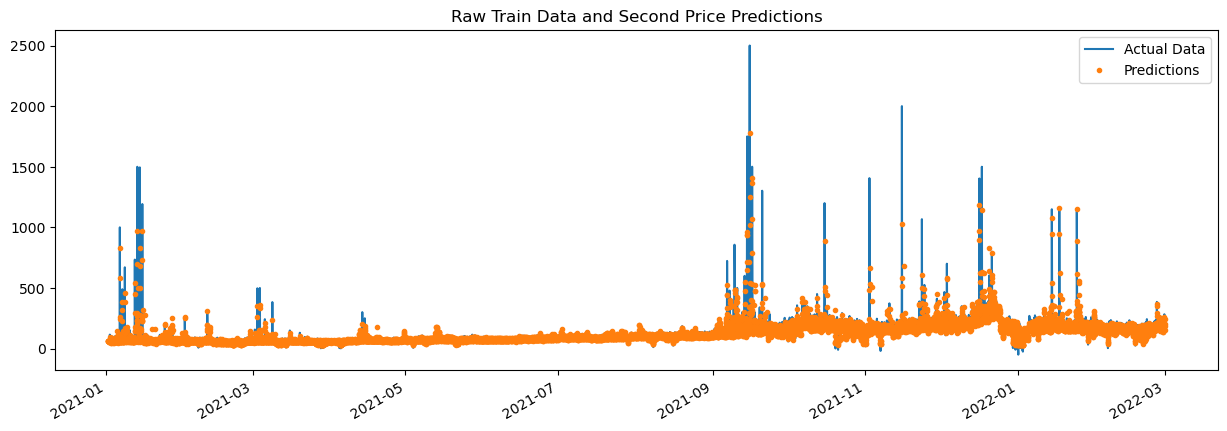

In [62]:
ax = df_auction_data_train[TARGET].plot(figsize=(15, 5))
df_auction_data_train['price_forecast_second_auction'].plot(ax=ax, style='.')
plt.legend(['Actual Data', 'Predictions'])
ax.set_title('Raw Train Data and Second Price Predictions')
plt.show()

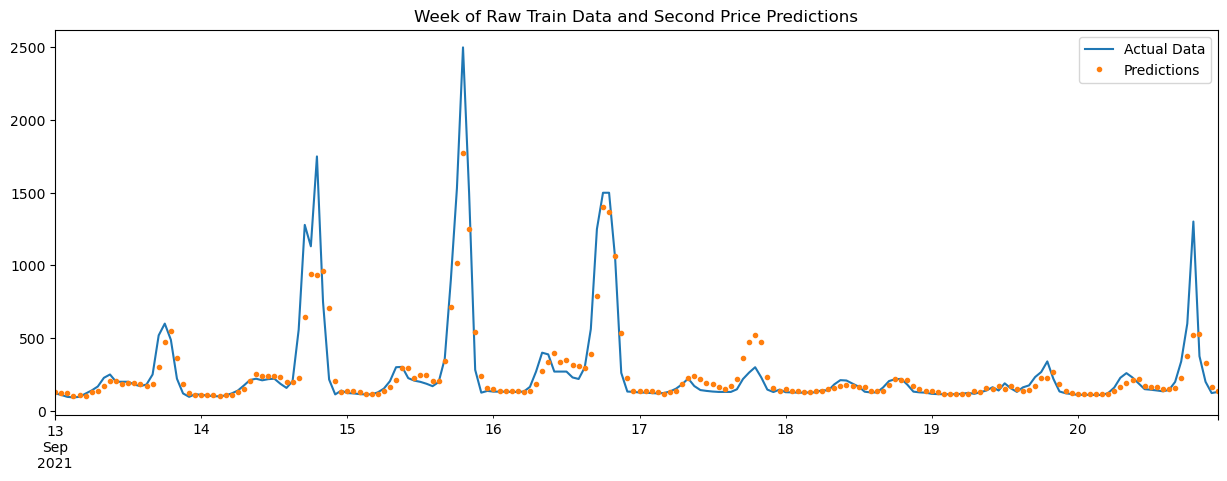

In [63]:
ax = df_auction_data_train.loc['2021-09-13':'2021-09-20'][TARGET].plot(figsize=(15, 5))
df_auction_data_train.loc['2021-09-13':'2021-09-20']['price_forecast_second_auction'].plot(ax=ax, style='.')
plt.legend(['Actual Data', 'Predictions'])
ax.set_title('Week of Raw Train Data and Second Price Predictions')
plt.show()

### For comparison plot the graph for the given train First Price Forecasts

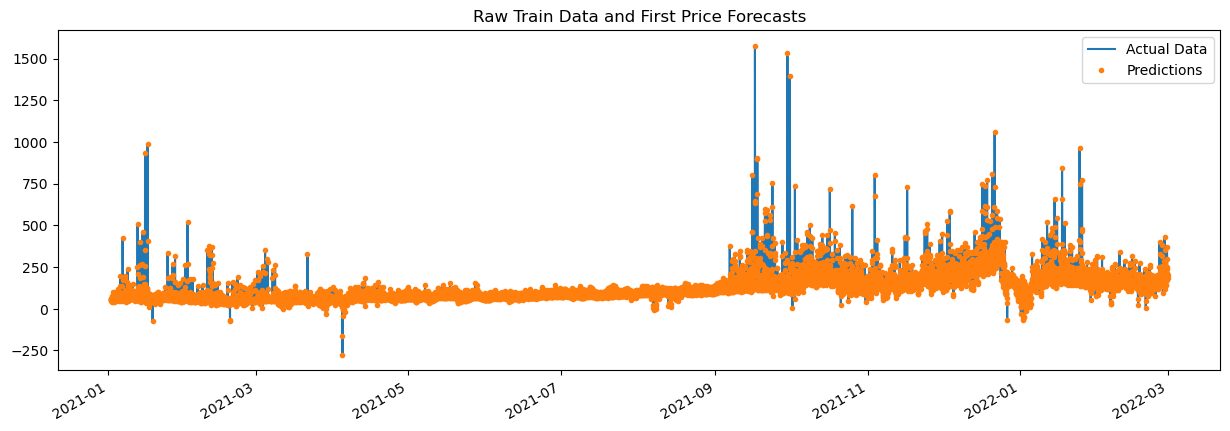

In [64]:
ax = df_auction_data_train['price_forecast_first_auction'].plot(figsize=(15, 5))
df_auction_data_train['price_forecast_first_auction'].plot(ax=ax, style='.')
plt.legend(['Actual Data', 'Predictions'])
ax.set_title('Raw Train Data and First Price Forecasts')
plt.show()

We see the given First Price Forecasts do model the peaks better

In [65]:
df_auction_data_test['price_forecast_second_auction'] = xgbr_best.predict(X_test)
df_auction_data_test

/var/folders/c8/y_c7_b4s2wq1r7z20jclk7g40000gn/T/ipykernel_66343/2911879945.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_auction_data_test['price_forecast_second_auction'] = xgbr_best.predict(X_test)


price_first_auction  price_second_auction  \
2022-03-01 00:00:00                202.8                208.52   
2022-03-01 01:00:00                202.8                209.48   
2022-03-01 02:00:00                200.4                204.83   
2022-03-01 03:00:00                197.5                195.90   
2022-03-01 04:00:00                202.3                194.31   
...                                  ...                   ...   
2022-09-12 19:00:00                465.6                437.60   
2022-09-12 20:00:00                418.0                391.45   
2022-09-12 21:00:00                358.7                342.29   
2022-09-12 22:00:00                300.8                275.73   
2022-09-12 23:00:00                265.9                257.24   

                     traded_volume_first_auction  \
2022-03-01 00:00:00                       3586.6   
2022-03-01 01:00:00                       3405.1   
2022-03-01 02:00:00                       3259.1   
2022-03-01 03:00:00                       3201.6   
2022-03-01 04:00:00                       3404.4   
...                                          ...   
2022-09-12 19:00:00                       5809.2   
2022-09-12 20:00:00                       5480.5   
2022-09-12 21:00:00                       4750.4   
2022-09-12 22:00:00                       4994.7   
2022-09-12 23:00:00                       4509.4   

                     traded_volume_second_auction  \
2022-03-01 00:00:00                        9068.0   
2022-03-01 01:00:00                        8862.9   
2022-03-01 02:00:00                        8784.4   
2022-03-01 03:00:00                        8704.1   
2022-03-01 04:00:00                        8995.4   
...                                           ...   
2022-09-12 19:00:00                       14484.4   
2022-09-12 20:00:00                       14037.4   
2022-09-12 21:00:00                       12785.3   
2022-09-12 22:00:00                       11982.3   
2022-09-12 23:00:00                       12773.6   

                     price_forecast_first_auction  \
2022-03-01 00:00:00                        195.56   
2022-03-01 01:00:00                        191.89   
2022-03-01 02:00:00                        183.95   
2022-03-01 03:00:00                        175.54   
2022-03-01 04:00:00                        177.83   
...                                           ...   
2022-09-12 19:00:00                        513.48   
2022-09-12 20:00:00                        439.66   
2022-09-12 21:00:00                        378.48   
2022-09-12 22:00:00                        298.65   
2022-09-12 23:00:00                        316.70   

                     price_forecast_second_auction  
2022-03-01 00:00:00                     185.313705  
2022-03-01 01:00:00                     185.313705  
2022-03-01 02:00:00                     183.292374  
2022-03-01 03:00:00                     183.292374  
2022-03-01 04:00:00                     185.313705  
...                                            ...  
2022-09-12 19:00:00                     435.435638  
2022-09-12 20:00:00                     435.435638  
2022-09-12 21:00:00                     385.091217  
2022-09-12 22:00:00                     326.954865  
2022-09-12 23:00:00                     269.562195  

[4703 rows x 6 columns]

### Also plot for the test data set

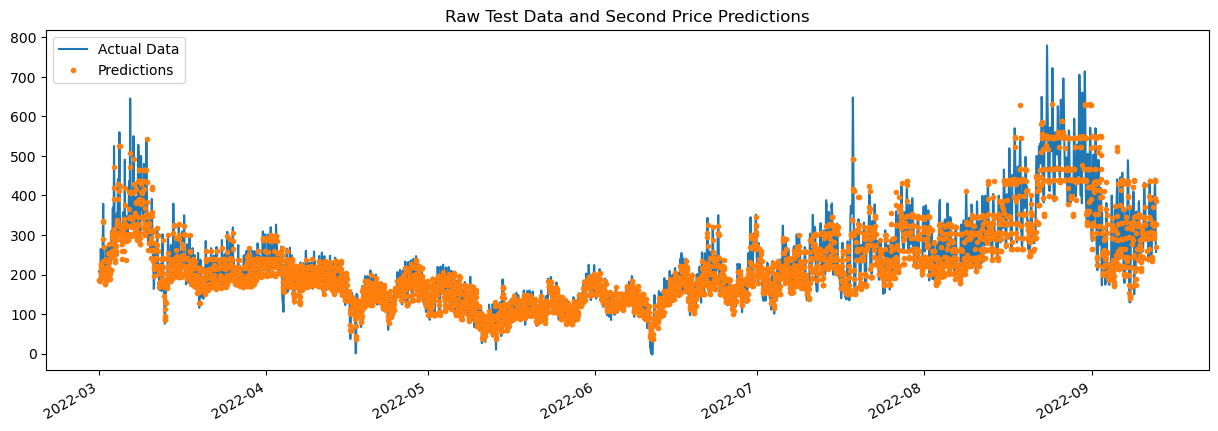

In [66]:
ax = df_auction_data_test[TARGET].plot(figsize=(15, 5))
df_auction_data_test['price_forecast_second_auction'].plot(ax=ax, style='.')
plt.legend(['Actual Data', 'Predictions'])
ax.set_title('Raw Test Data and Second Price Predictions')
plt.show()

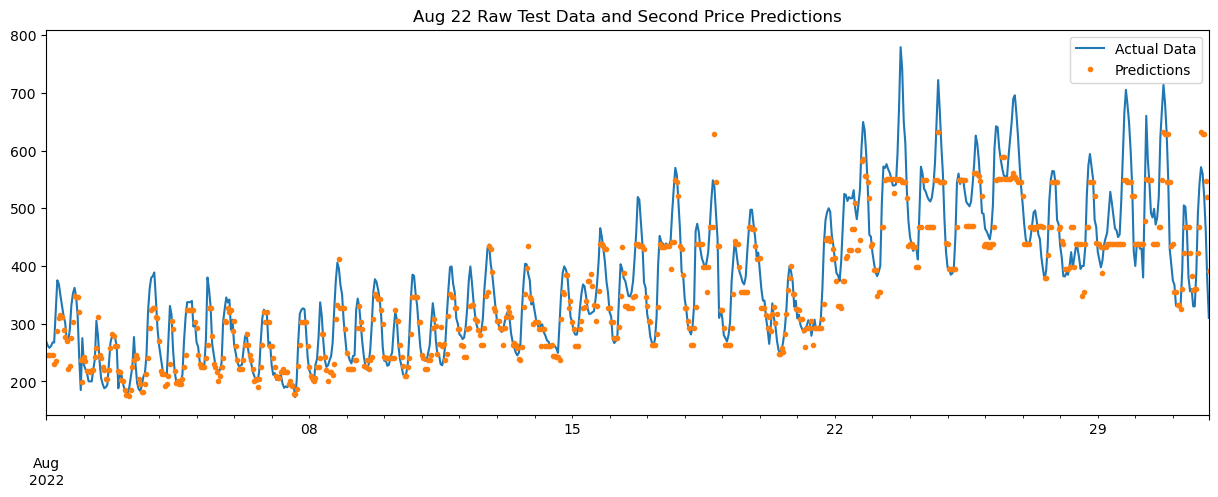

In [67]:
ax = df_auction_data_test.loc['2022-08'][TARGET].plot(figsize=(15, 5))
df_auction_data_test.loc['2022-08']['price_forecast_second_auction'].plot(ax=ax, style='.')
plt.legend(['Actual Data', 'Predictions'])
ax.set_title('Aug 22 Raw Test Data and Second Price Predictions')
plt.show()

### Again for comparison plot the graph for the given test First Price Forecasts

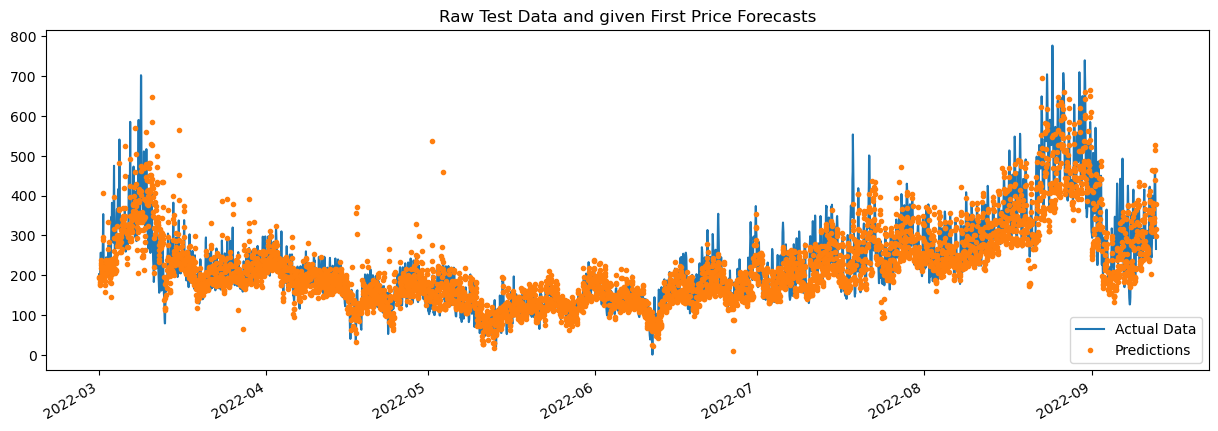

In [68]:
ax = df_auction_data_test[['price_first_auction']].plot(figsize=(15, 5))
df_auction_data_test['price_forecast_first_auction'].plot(ax=ax, style='.')
plt.legend(['Actual Data', 'Predictions'])
ax.set_title('Raw Test Data and given First Price Forecasts')
plt.show()

In [69]:
df_auction_data_test['error'] = np.abs(df_auction_data_test[TARGET] - df_auction_data_test['price_forecast_second_auction'])
df_auction_data_test['date'] = df_auction_data_test.index.date

/var/folders/c8/y_c7_b4s2wq1r7z20jclk7g40000gn/T/ipykernel_66343/1507516494.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_auction_data_test['error'] = np.abs(df_auction_data_test[TARGET] - df_auction_data_test['price_forecast_second_auction'])
/var/folders/c8/y_c7_b4s2wq1r7z20jclk7g40000gn/T/ipykernel_66343/1507516494.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_auction_data_test['date'] = df_auction_data_test.index.date


As expected the days with largest error were when the price volatility was highest

In [70]:
print('Days with largest error')
df_auction_data_test.groupby('date')['error'].mean().sort_values(ascending=False).head(10)

Days with largest error


date
2022-09-02    70.379095
2022-08-22    60.958339
2022-07-18    60.017777
2022-08-29    57.532863
2022-08-26    56.123509
2022-08-30    55.376727
2022-08-31    50.987993
2022-08-23    50.958880
2022-09-01    47.214837
2022-09-05    43.399671
Name: error, dtype: float64

In [71]:
print('Days with smallest error')
df_auction_data_test.groupby('date')['error'].mean().sort_values(ascending=True).head(10)

Days with smallest error


date
2022-05-25    8.160638
2022-06-06    8.179722
2022-06-01    8.201355
2022-04-22    8.237904
2022-04-21    8.240398
2022-04-14    8.512737
2022-05-29    8.796271
2022-06-08    8.859543
2022-04-29    9.008227
2022-05-28    9.039860
Name: error, dtype: float64

### Adding new 'forecast_system_price_mid' feature as average of high and low for train and test

In [73]:
df_system_prices_train['forecast_system_price_mid'] = [((high - low) / 2) + low if high >= low else ((low - high) / 2) + high for high, low in zip(df_system_prices_train['forecast_system_price_high'], df_system_prices_train['forecast_system_price_low'])]
df_system_prices_train

/var/folders/c8/y_c7_b4s2wq1r7z20jclk7g40000gn/T/ipykernel_66343/3430827995.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_system_prices_train['forecast_system_price_mid'] = [((high - low) / 2) + low if high >= low else ((low - high) / 2) + high for high, low in zip(df_system_prices_train['forecast_system_price_high'], df_system_prices_train['forecast_system_price_low'])]


forecast_system_price_low  forecast_system_price_high  \
2021-01-01 00:00:00                      48.33                       44.89   
2021-01-01 01:00:00                      54.35                       53.26   
2021-01-01 02:00:00                      32.66                       65.86   
2021-01-01 03:00:00                      41.55                       63.43   
2021-01-01 04:00:00                      26.62                       66.91   
...                                        ...                         ...   
2022-02-28 19:00:00                      64.15                      195.22   
2022-02-28 20:00:00                      63.39                      245.17   
2022-02-28 21:00:00                      60.42                      222.10   
2022-02-28 22:00:00                     126.38                      203.38   
2022-02-28 23:00:00                      86.63                      240.28   

                     system_price  forecast_system_price_mid  
2021-01-01 00:00:00         73.15                     46.610  
2021-01-01 01:00:00         71.95                     53.805  
2021-01-01 02:00:00         54.56                     49.260  
2021-01-01 03:00:00         70.73                     52.490  
2021-01-01 04:00:00         54.98                     46.765  
...                           ...                        ...  
2022-02-28 19:00:00        277.50                    129.685  
2022-02-28 20:00:00        264.18                    154.280  
2022-02-28 21:00:00        252.24                    141.260  
2022-02-28 22:00:00        245.00                    164.880  
2022-02-28 23:00:00        253.00                    163.455  

[10175 rows x 4 columns]

In [74]:
df_system_prices_test['forecast_system_price_mid'] = [((high - low) / 2) + low if high >= low else ((low - high) / 2) + high for high, low in zip(df_system_prices_test['forecast_system_price_high'], df_system_prices_test['forecast_system_price_low'])]
df_system_prices_test

/var/folders/c8/y_c7_b4s2wq1r7z20jclk7g40000gn/T/ipykernel_66343/604032180.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_system_prices_test['forecast_system_price_mid'] = [((high - low) / 2) + low if high >= low else ((low - high) / 2) + high for high, low in zip(df_system_prices_test['forecast_system_price_high'], df_system_prices_test['forecast_system_price_low'])]


forecast_system_price_low  forecast_system_price_high  \
2022-03-01 00:00:00                      77.10                      251.28   
2022-03-01 01:00:00                     -52.19                      215.16   
2022-03-01 02:00:00                      -6.46                      203.08   
2022-03-01 03:00:00                      80.09                      231.47   
2022-03-01 04:00:00                      74.02                      209.69   
...                                        ...                         ...   
2022-09-12 19:00:00                    1285.80                      444.26   
2022-09-12 20:00:00                    -234.22                      390.59   
2022-09-12 21:00:00                      37.57                      324.03   
2022-09-12 22:00:00                     401.78                      234.41   
2022-09-12 23:00:00                     368.66                      287.97   

                     system_price  forecast_system_price_mid  
2022-03-01 00:00:00        204.05                    164.190  
2022-03-01 01:00:00        237.00                     81.485  
2022-03-01 02:00:00        245.00                     98.310  
2022-03-01 03:00:00        229.00                    155.780  
2022-03-01 04:00:00        245.00                    141.855  
...                           ...                        ...  
2022-09-12 19:00:00           NaN                    865.030  
2022-09-12 20:00:00           NaN                     78.185  
2022-09-12 21:00:00           NaN                    180.800  
2022-09-12 22:00:00           NaN                    318.095  
2022-09-12 23:00:00           NaN                    328.315  

[4703 rows x 4 columns]

### Concatenating auction and system prices into one data frame

In [75]:
df_price_data_train = pd.concat([df_auction_data_train, df_system_prices_train], axis=1, join='inner') # inner join for removed entries from feature engineering
df_price_data_train.head()

price_first_auction  price_second_auction  \
2021-01-02 00:00:00                 64.0                 63.91   
2021-01-02 01:00:00                 58.0                 66.12   
2021-01-02 02:00:00                 50.0                 59.28   
2021-01-02 03:00:00                 50.0                 54.96   
2021-01-02 04:00:00                 45.5                 49.65   

                     traded_volume_first_auction  \
2021-01-02 00:00:00                       3260.2   
2021-01-02 01:00:00                       3265.2   
2021-01-02 02:00:00                       3327.1   
2021-01-02 03:00:00                       3668.6   
2021-01-02 04:00:00                       3900.3   

                     traded_volume_second_auction  \
2021-01-02 00:00:00                        3763.0   
2021-01-02 01:00:00                        3898.3   
2021-01-02 02:00:00                        3408.2   
2021-01-02 03:00:00                        3388.5   
2021-01-02 04:00:00                        3925.1   

                     price_forecast_first_auction  \
2021-01-02 00:00:00                         61.32   
2021-01-02 01:00:00                         61.41   
2021-01-02 02:00:00                         56.98   
2021-01-02 03:00:00                         56.04   
2021-01-02 04:00:00                         50.45   

                     price_forecast_second_auction  forecast_system_price_low  \
2021-01-02 00:00:00                      62.174038                      33.04   
2021-01-02 01:00:00                      64.573357                      35.56   
2021-01-02 02:00:00                      62.301605                      36.02   
2021-01-02 03:00:00                      58.717190                      45.82   
2021-01-02 04:00:00                      58.717190                      25.77   

                     forecast_system_price_high  system_price  \
2021-01-02 00:00:00                       75.27         53.66   
2021-01-02 01:00:00                       65.74         68.00   
2021-01-02 02:00:00                       70.35         19.39   
2021-01-02 03:00:00                       64.78         65.98   
2021-01-02 04:00:00                       69.81         65.98   

                     forecast_system_price_mid  
2021-01-02 00:00:00                     54.155  
2021-01-02 01:00:00                     50.650  
2021-01-02 02:00:00                     53.185  
2021-01-02 03:00:00                     55.300  
2021-01-02 04:00:00                     47.790

# Trading strategy

For the training set we will try the following trading strategies:

- A naive strategy where we calculate the average delta between the First and Second prices and buy/sell based on this at each time step
- A naive strategy where we calculate the average delta between the First and System prices and buy/sell based on this at each time step
- A strategy where we check the delta between the First and Second forecast is greater than 10 (the open and closing trading costs) and try to buy/sell when the delta is greater than this. Trades only go through if we can open a position with our First Price forecast. If we can't close the position with our Second Price forecast, we use the System price to close the position.
- A strategy where we check the delta between the First and System price mid forecast is greater than 10 (the open and closing trading costs) and try to buy/sell when the delta is greater than this. Trades only go through if we can open a position with our First Price forecast.
- A strategy where we check the delta between the First and System price mid forecast is greater than 10 (the open and closing trading costs) and try to buy/sell when the delta is greater than this. Trades only go through if we can open a position with our First Price forecast. If the position is open we try and close the position for any profit (including the 10 GBP/MW trading costs) during the Second Auction. If the position is still open after the Second Auction we close the position with the System price.
- A strategy where we check the delta between the Second and System price mid forecast is greater than 10 (the open and closing trading costs) and try to buy/sell when the delta is greater than this. Trades only go through if we can open a position with our Second Price forecast.
- A strategy where we check the delta between the First and Second price forecast and the First and System price mid forecast are BOTH greater than 10 (the open and closing trading costs) and have the same direction. We try and buy/sell and trades only go through if we can open a position with our First Price Forecast. If the position is open we try and close the position for any profit (including the 10 GBP/MW trading costs) during the Second Auction. If the position is still open after the Second Auction we close the position with the System price.

### For now we will ignore trade volume and assume we will be making our trades for 1 MWh

### A naive strategy where we calculate the average delta between the First and Second prices and buy/sell based on this at each time step

Average delta is negative so we sell when opening the position to buy back later at a lower price assuming our bids are always taken

In [186]:
pd.DataFrame(df_price_data_train['price_second_auction'] - df_price_data_train['price_first_auction']).describe()

0
count  10151.000000
mean      -0.173399
std       26.294834
min     -646.020000
25%       -3.850000
50%       -0.010000
75%        3.800000
max     1077.810000

In [165]:
def calculate_naive_first_second_pnl(df_auction_data, df_system_prices):
        df_price_data = pd.concat([df_auction_data, df_system_prices], axis=1, join='inner') # inner join for removed entries from feature engineering
        total_return = 0
        number_of_trades = 0
        for i, row in df_price_data.iterrows():
                number_of_trades += 1
                total_return += row['price_first_auction'] - row['price_second_auction'] - 10
                df_price_data.loc[i, 'naive_first_second_return'] = total_return
        print('Number of trades: ', number_of_trades)
        return df_price_data

In [198]:
df_naive_first_second_pnl = calculate_naive_first_second_pnl(df_auction_data_train, df_system_prices_train)
volatility = df_naive_first_second_pnl['naive_first_second_return'].pct_change().dropna().std()*np.sqrt(365)
print('Volatility (Standard Deviation) of returns annualised: ', volatility)
strategy_preformances = pd.DataFrame.from_dict({'naive_first_second': (df_naive_first_second_pnl.iloc[-1]['naive_first_second_return'], df_naive_first_second_pnl.iloc[-1]['naive_first_second_return'], 0, volatility)}, orient='index', columns=['Total Return', 'Auction Return', 'System Price Return', 'Volatility'])
df_naive_first_second_pnl.tail()

Number of trades:  10151
Volatility (Standard Deviation) of returns annualised:  0.3930196350849236


price_first_auction  price_second_auction  \
2022-02-28 19:00:00                269.0                264.54   
2022-02-28 20:00:00                214.4                217.25   
2022-02-28 21:00:00                191.2                195.39   
2022-02-28 22:00:00                168.8                148.80   
2022-02-28 23:00:00                192.7                190.00   

                     traded_volume_first_auction  \
2022-02-28 19:00:00                       6046.2   
2022-02-28 20:00:00                       5628.9   
2022-02-28 21:00:00                       5685.2   
2022-02-28 22:00:00                       5565.1   
2022-02-28 23:00:00                       3669.1   

                     traded_volume_second_auction  \
2022-02-28 19:00:00                       13289.5   
2022-02-28 20:00:00                       12196.3   
2022-02-28 21:00:00                       11186.4   
2022-02-28 22:00:00                       11440.8   
2022-02-28 23:00:00                        9059.3   

                     price_forecast_first_auction  \
2022-02-28 19:00:00                        235.99   
2022-02-28 20:00:00                        214.67   
2022-02-28 21:00:00                        206.65   
2022-02-28 22:00:00                        185.69   
2022-02-28 23:00:00                        201.02   

                     price_forecast_second_auction  \
2022-02-28 19:00:00                     258.587494   
2022-02-28 20:00:00                     240.572510   
2022-02-28 21:00:00                     201.107376   
2022-02-28 22:00:00                     182.885391   
2022-02-28 23:00:00                     154.994919   

                     traded_volume_forecast_first_auction  \
2022-02-28 19:00:00                                5252.0   
2022-02-28 20:00:00                                5579.1   
2022-02-28 21:00:00                                5295.9   
2022-02-28 22:00:00                                5362.1   
2022-02-28 23:00:00                                3863.9   

                     forecast_system_price_low  forecast_system_price_high  \
2022-02-28 19:00:00                      64.15                      195.22   
2022-02-28 20:00:00                      63.39                      245.17   
2022-02-28 21:00:00                      60.42                      222.10   
2022-02-28 22:00:00                     126.38                      203.38   
2022-02-28 23:00:00                      86.63                      240.28   

                     system_price  forecast_system_price_mid  \
2022-02-28 19:00:00        277.50                    129.685   
2022-02-28 20:00:00        264.18                    154.280   
2022-02-28 21:00:00        252.24                    141.260   
2022-02-28 22:00:00        245.00                    164.880   
2022-02-28 23:00:00        253.00                    163.455   

                     naive_first_second_return  
2022-02-28 19:00:00                  -99725.49  
2022-02-28 20:00:00                  -99738.34  
2022-02-28 21:00:00                  -99752.53  
2022-02-28 22:00:00                  -99742.53  
2022-02-28 23:00:00                  -99749.83

### A naive strategy where we calculate the average delta between the First and System prices and buy/sell based on this at each time step

Average delta is negative so we sell when opening the position to buy back later at a lower price assuming our bids are always taken

In [78]:
pd.DataFrame(df_price_data_train['system_price'] - df_price_data_train['price_first_auction']).describe()

0
count  10115.000000
mean      -3.395873
std      134.289946
min    -1753.350000
25%      -30.395000
50%        1.590000
75%       25.000000
max     3911.000000

In [170]:
def calculate_naive_first_system_pnl(df_auction_data, df_system_prices):
    df_price_data = pd.concat([df_auction_data, df_system_prices], axis=1, join='inner') # inner join for removed entries from feature engineering
    total_return = 0
    number_of_trades = 0
    for i, row in df_price_data.iterrows():
            number_of_trades += 1
            if not math.isnan(row['system_price']):
                if row['price_first_auction'] - 10 > row['price_second_auction']:
                    total_return += row['price_first_auction'] - row['price_second_auction'] - 10
                else:
                    total_return += row['price_first_auction'] - row['system_price'] - 10
            df_price_data.loc[i, 'naive_first_system_return'] = total_return
    print('Number of trades: ', number_of_trades)
    return df_price_data

In [199]:
df_naive_first_system_pnl = calculate_naive_first_system_pnl(df_auction_data_train, df_system_prices_train)
volatility = df_naive_first_system_pnl['naive_first_system_return'].pct_change().dropna().std()*np.sqrt(365)
print('Volatility (Standard Deviation) of returns annualised: ', volatility)
strategy_preformances.loc['naive_first_system'] = (df_naive_first_system_pnl.iloc[-1]['naive_first_system_return'], 0, df_naive_first_system_pnl.iloc[-1]['naive_first_system_return'], volatility)
df_naive_first_system_pnl.tail()

Number of trades:  10151
Volatility (Standard Deviation) of returns annualised:  12.313650586222172


price_first_auction  price_second_auction  \
2022-02-28 19:00:00                269.0                264.54   
2022-02-28 20:00:00                214.4                217.25   
2022-02-28 21:00:00                191.2                195.39   
2022-02-28 22:00:00                168.8                148.80   
2022-02-28 23:00:00                192.7                190.00   

                     traded_volume_first_auction  \
2022-02-28 19:00:00                       6046.2   
2022-02-28 20:00:00                       5628.9   
2022-02-28 21:00:00                       5685.2   
2022-02-28 22:00:00                       5565.1   
2022-02-28 23:00:00                       3669.1   

                     traded_volume_second_auction  \
2022-02-28 19:00:00                       13289.5   
2022-02-28 20:00:00                       12196.3   
2022-02-28 21:00:00                       11186.4   
2022-02-28 22:00:00                       11440.8   
2022-02-28 23:00:00                        9059.3   

                     price_forecast_first_auction  \
2022-02-28 19:00:00                        235.99   
2022-02-28 20:00:00                        214.67   
2022-02-28 21:00:00                        206.65   
2022-02-28 22:00:00                        185.69   
2022-02-28 23:00:00                        201.02   

                     price_forecast_second_auction  \
2022-02-28 19:00:00                     258.587494   
2022-02-28 20:00:00                     240.572510   
2022-02-28 21:00:00                     201.107376   
2022-02-28 22:00:00                     182.885391   
2022-02-28 23:00:00                     154.994919   

                     traded_volume_forecast_first_auction  \
2022-02-28 19:00:00                                5252.0   
2022-02-28 20:00:00                                5579.1   
2022-02-28 21:00:00                                5295.9   
2022-02-28 22:00:00                                5362.1   
2022-02-28 23:00:00                                3863.9   

                     forecast_system_price_low  forecast_system_price_high  \
2022-02-28 19:00:00                      64.15                      195.22   
2022-02-28 20:00:00                      63.39                      245.17   
2022-02-28 21:00:00                      60.42                      222.10   
2022-02-28 22:00:00                     126.38                      203.38   
2022-02-28 23:00:00                      86.63                      240.28   

                     system_price  forecast_system_price_mid  \
2022-02-28 19:00:00        277.50                    129.685   
2022-02-28 20:00:00        264.18                    154.280   
2022-02-28 21:00:00        252.24                    141.260   
2022-02-28 22:00:00        245.00                    164.880   
2022-02-28 23:00:00        253.00                    163.455   

                     naive_first_system_return  
2022-02-28 19:00:00                  -80383.01  
2022-02-28 20:00:00                  -80442.79  
2022-02-28 21:00:00                  -80513.83  
2022-02-28 22:00:00                  -80503.83  
2022-02-28 23:00:00                  -80574.13

### A strategy where we check the delta between the First and Second forecast is greater than 10 (the open and closing trading costs) and try to buy/sell when the delta is greater than this
- Trades only go through if we can open a position with our First Price forecast
- If we can't close the position with our Second Price forecast, we use the System price to close the position if it is not NaN, otherwise no trade

In [174]:
def calculate_first_second_forecast_pnl(df_auction_data, df_system_prices):
    df_price_data = pd.concat([df_auction_data, df_system_prices], axis=1, join='inner') # inner join for removed entries from feature engineering
    total_return = 0
    auction_return = 0
    system_price_return = 0
    number_of_trades = 0
    for i, row in df_price_data.iterrows():
        if (row['price_forecast_first_auction'] + 10 < row['price_forecast_second_auction']) & (row['price_forecast_first_auction'] >= row['price_first_auction']):
            if row['price_forecast_second_auction'] < row['price_second_auction']:
                number_of_trades += 1
                auction_return += row['price_second_auction'] - row['price_first_auction'] - 10
                total_return += row['price_second_auction'] - row['price_first_auction'] - 10
            elif not math.isnan(row['system_price']):
                number_of_trades += 1
                system_price_return += row['system_price'] - row['price_first_auction'] - 10
                total_return += row['system_price'] - row['price_first_auction'] - 10
        elif (row['price_forecast_first_auction'] - 10 > row['price_forecast_second_auction']) & (row['price_forecast_first_auction'] <= row['price_first_auction']):
            if row['price_forecast_second_auction'] > row['price_second_auction']:
                number_of_trades += 1
                auction_return += row['price_first_auction'] - row['price_second_auction'] - 10
                total_return += row['price_first_auction'] - row['price_second_auction'] - 10
            elif not math.isnan(row['system_price']):
                number_of_trades += 1
                system_price_return += row['price_first_auction'] - row['system_price'] - 10
                total_return += row['price_first_auction'] - row['system_price'] - 10

        df_price_data.loc[i, 'first_second_forecast_auction_return'] = '{:,.2f}'.format(auction_return)
        df_price_data.loc[i, 'first_second_forecast_system_price_return'] = '{:,.2f}'.format(system_price_return)
        df_price_data.loc[i, 'first_second_forecast_raw_return'] = total_return
        df_price_data.loc[i, 'first_second_forecast_return'] = '{:,.2f}'.format(total_return)

    print('Number of trades: ', number_of_trades)
    return df_price_data

In [202]:
df_first_second_forecast_pnl = calculate_first_second_forecast_pnl(df_auction_data_train, df_system_prices_train)
volatility = df_first_second_forecast_pnl['first_second_forecast_raw_return'].pct_change().dropna().std()*np.sqrt(365)
print('Volatility (Standard Deviation) of returns annualised: ', volatility)
strategy_preformances.loc['first_second'] = (df_first_second_forecast_pnl.iloc[-1]['first_second_forecast_return'], df_first_second_forecast_pnl.iloc[-1]['first_second_forecast_auction_return'], df_first_second_forecast_pnl.iloc[-1]['first_second_forecast_system_price_return'], volatility)
df_first_second_forecast_pnl.tail()

Number of trades:  688
Volatility (Standard Deviation) of returns annualised:  12.616069541783986


price_first_auction  price_second_auction  \
2022-02-28 19:00:00                269.0                264.54   
2022-02-28 20:00:00                214.4                217.25   
2022-02-28 21:00:00                191.2                195.39   
2022-02-28 22:00:00                168.8                148.80   
2022-02-28 23:00:00                192.7                190.00   

                     traded_volume_first_auction  \
2022-02-28 19:00:00                       6046.2   
2022-02-28 20:00:00                       5628.9   
2022-02-28 21:00:00                       5685.2   
2022-02-28 22:00:00                       5565.1   
2022-02-28 23:00:00                       3669.1   

                     traded_volume_second_auction  \
2022-02-28 19:00:00                       13289.5   
2022-02-28 20:00:00                       12196.3   
2022-02-28 21:00:00                       11186.4   
2022-02-28 22:00:00                       11440.8   
2022-02-28 23:00:00                        9059.3   

                     price_forecast_first_auction  \
2022-02-28 19:00:00                        235.99   
2022-02-28 20:00:00                        214.67   
2022-02-28 21:00:00                        206.65   
2022-02-28 22:00:00                        185.69   
2022-02-28 23:00:00                        201.02   

                     price_forecast_second_auction  \
2022-02-28 19:00:00                     258.587494   
2022-02-28 20:00:00                     240.572510   
2022-02-28 21:00:00                     201.107376   
2022-02-28 22:00:00                     182.885391   
2022-02-28 23:00:00                     154.994919   

                     traded_volume_forecast_first_auction  \
2022-02-28 19:00:00                                5252.0   
2022-02-28 20:00:00                                5579.1   
2022-02-28 21:00:00                                5295.9   
2022-02-28 22:00:00                                5362.1   
2022-02-28 23:00:00                                3863.9   

                     forecast_system_price_low  forecast_system_price_high  \
2022-02-28 19:00:00                      64.15                      195.22   
2022-02-28 20:00:00                      63.39                      245.17   
2022-02-28 21:00:00                      60.42                      222.10   
2022-02-28 22:00:00                     126.38                      203.38   
2022-02-28 23:00:00                      86.63                      240.28   

                     system_price  forecast_system_price_mid  \
2022-02-28 19:00:00        277.50                    129.685   
2022-02-28 20:00:00        264.18                    154.280   
2022-02-28 21:00:00        252.24                    141.260   
2022-02-28 22:00:00        245.00                    164.880   
2022-02-28 23:00:00        253.00                    163.455   

                    first_second_forecast_auction_return  \
2022-02-28 19:00:00                             1,889.97   
2022-02-28 20:00:00                             1,889.97   
2022-02-28 21:00:00                             1,889.97   
2022-02-28 22:00:00                             1,889.97   
2022-02-28 23:00:00                             1,889.97   

                    first_second_forecast_system_price_return  \
2022-02-28 19:00:00                                  9,077.40   
2022-02-28 20:00:00                                  9,117.18   
2022-02-28 21:00:00                                  9,117.18   
2022-02-28 22:00:00                                  9,117.18   
2022-02-28 23:00:00                                  9,117.18   

                     first_second_forecast_raw_return  \
2022-02-28 19:00:00                          10967.37   
2022-02-28 20:00:00                          11007.15   
2022-02-28 21:00:00                          11007.15   
2022-02-28 22:00:00                          11007.15   
2022-02-28 23:00:00                          11007.15   

                    first_second

### A strategy where we check the delta between the First and System price mid forecast is greater than 10 (the open and closing trading costs) and try to buy/sell when the delta is greater than this
- Trades only go through if we can open a position with our First Price forecast

In [183]:
def calculate_first_system_forecast_pnl(df_auction_data, df_system_prices):
    df_price_data = pd.concat([df_auction_data, df_system_prices], axis=1, join='inner') # inner join for removed entries from feature engineering
    total_return = 0
    number_of_trades = 0
    for i, row in df_price_data.iterrows():
        if not math.isnan(row['system_price']):
            if (row['price_forecast_first_auction'] + 10 < row['forecast_system_price_mid']) & (row['price_forecast_first_auction'] >= row['price_first_auction']):
                number_of_trades += 1
                total_return += row['system_price'] - row['price_first_auction'] - 10
            elif (row['price_forecast_first_auction'] - 10 > row['forecast_system_price_mid']) & (row['price_forecast_first_auction'] <= row['price_first_auction']):
                number_of_trades += 1
                total_return += row['price_first_auction'] - row['system_price'] - 10

        df_price_data.loc[i, 'first_system_forecast_raw_return'] = total_return
        df_price_data.loc[i, 'first_system_forecast_return'] = '{:,.2f}'.format(total_return)

    print('Number of trades: ', number_of_trades)
    return df_price_data

In [203]:
df_first_system_forecast_pnl = calculate_first_system_forecast_pnl(df_auction_data_train, df_system_prices_train)
volatility = df_first_system_forecast_pnl['first_system_forecast_raw_return'].pct_change().dropna().std()*np.sqrt(365)
print('Volatility (Standard Deviation) of returns annualised: ', volatility)
strategy_preformances.loc['first_system'] = (df_first_system_forecast_pnl.iloc[-1]['first_system_forecast_return'], 0, df_first_system_forecast_pnl.iloc[-1]['first_system_forecast_return'], volatility)
df_first_system_forecast_pnl.tail()

Number of trades:  2593
Volatility (Standard Deviation) of returns annualised:  12.12401594119407


price_first_auction  price_second_auction  \
2022-02-28 19:00:00                269.0                264.54   
2022-02-28 20:00:00                214.4                217.25   
2022-02-28 21:00:00                191.2                195.39   
2022-02-28 22:00:00                168.8                148.80   
2022-02-28 23:00:00                192.7                190.00   

                     traded_volume_first_auction  \
2022-02-28 19:00:00                       6046.2   
2022-02-28 20:00:00                       5628.9   
2022-02-28 21:00:00                       5685.2   
2022-02-28 22:00:00                       5565.1   
2022-02-28 23:00:00                       3669.1   

                     traded_volume_second_auction  \
2022-02-28 19:00:00                       13289.5   
2022-02-28 20:00:00                       12196.3   
2022-02-28 21:00:00                       11186.4   
2022-02-28 22:00:00                       11440.8   
2022-02-28 23:00:00                        9059.3   

                     price_forecast_first_auction  \
2022-02-28 19:00:00                        235.99   
2022-02-28 20:00:00                        214.67   
2022-02-28 21:00:00                        206.65   
2022-02-28 22:00:00                        185.69   
2022-02-28 23:00:00                        201.02   

                     price_forecast_second_auction  \
2022-02-28 19:00:00                     258.587494   
2022-02-28 20:00:00                     240.572510   
2022-02-28 21:00:00                     201.107376   
2022-02-28 22:00:00                     182.885391   
2022-02-28 23:00:00                     154.994919   

                     traded_volume_forecast_first_auction  \
2022-02-28 19:00:00                                5252.0   
2022-02-28 20:00:00                                5579.1   
2022-02-28 21:00:00                                5295.9   
2022-02-28 22:00:00                                5362.1   
2022-02-28 23:00:00                                3863.9   

                     forecast_system_price_low  forecast_system_price_high  \
2022-02-28 19:00:00                      64.15                      195.22   
2022-02-28 20:00:00                      63.39                      245.17   
2022-02-28 21:00:00                      60.42                      222.10   
2022-02-28 22:00:00                     126.38                      203.38   
2022-02-28 23:00:00                      86.63                      240.28   

                     system_price  forecast_system_price_mid  \
2022-02-28 19:00:00        277.50                    129.685   
2022-02-28 20:00:00        264.18                    154.280   
2022-02-28 21:00:00        252.24                    141.260   
2022-02-28 22:00:00        245.00                    164.880   
2022-02-28 23:00:00        253.00                    163.455   

                     first_system_forecast_raw_return  \
2022-02-28 19:00:00                          17071.83   
2022-02-28 20:00:00                          17071.83   
2022-02-28 21:00:00                          17071.83   
2022-02-28 22:00:00                          17071.83   
2022-02-28 23:00:00                          17071.83   

                    first_system_forecast_return  
2022-02-28 19:00:00                    17,071.83  
2022-02-28 20:00:00                    17,071.83  
2022-02-28 21:00:00                    17,071.83  
2022-02-28 22:00:00                    17,071.83  
2022-02-28 23:00:00                    17,071.83

### A strategy where we check the delta between the First and System price mid forecast is greater than 10 (the open and closing trading costs) and try to buy/sell when the delta is greater than this
- Trades only go through if we can open a position with our First Price forecast
- If the position is open we try and close the position for any profit (including the 10 GBP/MW trading costs) during the Second Auction
- If the position is still open after the Second Auction we close the position with the System price

In [208]:
def calculate_first_system_forecast_try_second_pnl(df_auction_data, df_system_prices):
    df_price_data = pd.concat([df_auction_data, df_system_prices], axis=1, join='inner') # inner join for removed entries from feature engineering
    total_return = 0
    auction_return = 0
    system_price_return = 0
    number_of_trades = 0
    for i, row in df_price_data.iterrows():
        if not math.isnan(row['system_price']): # only look to trade if System Price is available this hour
            if (row['price_forecast_first_auction'] + 10 < row['forecast_system_price_mid']) & (row['price_forecast_first_auction'] >= row['price_first_auction']):
                number_of_trades += 1
                if row['price_first_auction'] + 10 < row['price_second_auction']:
                    total_return += row['price_second_auction'] - row['price_first_auction'] - 10
                    auction_return += row['price_second_auction'] - row['price_first_auction'] - 10
                else:
                    total_return += row['forecast_system_price_mid'] - row['price_first_auction'] - 10
                    system_price_return += row['forecast_system_price_mid'] - row['price_first_auction'] - 10
            elif (row['price_forecast_first_auction'] - 10 > row['system_price']) & (row['price_forecast_first_auction'] <= row['price_first_auction']):
                number_of_trades += 1
                if row['price_first_auction'] - 10 > row['price_second_auction']:
                    total_return += row['price_first_auction'] - row['price_second_auction'] - 10
                    auction_return+= row['price_first_auction'] - row['price_second_auction'] - 10
                else:
                    total_return += row['price_first_auction'] - row['system_price'] - 10
                    system_price_return += row['price_first_auction'] - row['system_price'] - 10

        df_price_data.loc[i, 'first_system_forecast_try_second_auction_return'] = '{:,.2f}'.format(auction_return)
        df_price_data.loc[i, 'first_system_forecast_try_second_system_price_return'] = '{:,.2f}'.format(system_price_return)
        df_price_data.loc[i, 'first_system_forecast_try_second_raw_return'] = total_return
        df_price_data.loc[i, 'first_system_forecast_try_second_return'] = '{:,.2f}'.format(total_return)

    print('Number of trades: ', number_of_trades)
    return df_price_data

In [221]:
df_first_system_forecast_try_second_pnl = calculate_first_system_forecast_try_second_pnl(df_auction_data_train, df_system_prices_train)
volatility = df_first_system_forecast_try_second_pnl['first_system_forecast_try_second_raw_return'].pct_change().dropna().std()*np.sqrt(365)
print('Volatility (Standard Deviation) of returns annualised: ', volatility)
strategy_preformances.loc['first_system_try_second'] = (df_first_system_forecast_try_second_pnl.iloc[-1]['first_system_forecast_try_second_return'], df_first_system_forecast_try_second_pnl.iloc[-1]['first_system_forecast_try_second_auction_return'], df_first_system_forecast_try_second_pnl.iloc[-1]['first_system_forecast_try_second_system_price_return'], volatility)
df_first_system_forecast_try_second_pnl.tail()

Number of trades:  2281
Volatility (Standard Deviation) of returns annualised:  0.4336128717324534


price_first_auction  price_second_auction  \
2022-02-28 19:00:00                269.0                264.54   
2022-02-28 20:00:00                214.4                217.25   
2022-02-28 21:00:00                191.2                195.39   
2022-02-28 22:00:00                168.8                148.80   
2022-02-28 23:00:00                192.7                190.00   

                     traded_volume_first_auction  \
2022-02-28 19:00:00                       6046.2   
2022-02-28 20:00:00                       5628.9   
2022-02-28 21:00:00                       5685.2   
2022-02-28 22:00:00                       5565.1   
2022-02-28 23:00:00                       3669.1   

                     traded_volume_second_auction  \
2022-02-28 19:00:00                       13289.5   
2022-02-28 20:00:00                       12196.3   
2022-02-28 21:00:00                       11186.4   
2022-02-28 22:00:00                       11440.8   
2022-02-28 23:00:00                        9059.3   

                     price_forecast_first_auction  \
2022-02-28 19:00:00                        235.99   
2022-02-28 20:00:00                        214.67   
2022-02-28 21:00:00                        206.65   
2022-02-28 22:00:00                        185.69   
2022-02-28 23:00:00                        201.02   

                     price_forecast_second_auction  \
2022-02-28 19:00:00                     258.587494   
2022-02-28 20:00:00                     240.572510   
2022-02-28 21:00:00                     201.107376   
2022-02-28 22:00:00                     182.885391   
2022-02-28 23:00:00                     154.994919   

                     traded_volume_forecast_first_auction  \
2022-02-28 19:00:00                                5252.0   
2022-02-28 20:00:00                                5579.1   
2022-02-28 21:00:00                                5295.9   
2022-02-28 22:00:00                                5362.1   
2022-02-28 23:00:00                                3863.9   

                     forecast_system_price_low  forecast_system_price_high  \
2022-02-28 19:00:00                      64.15                      195.22   
2022-02-28 20:00:00                      63.39                      245.17   
2022-02-28 21:00:00                      60.42                      222.10   
2022-02-28 22:00:00                     126.38                      203.38   
2022-02-28 23:00:00                      86.63                      240.28   

                     system_price  forecast_system_price_mid  \
2022-02-28 19:00:00        277.50                    129.685   
2022-02-28 20:00:00        264.18                    154.280   
2022-02-28 21:00:00        252.24                    141.260   
2022-02-28 22:00:00        245.00                    164.880   
2022-02-28 23:00:00        253.00                    163.455   

                    first_system_forecast_try_second_auction_return  \
2022-02-28 19:00:00                                       10,505.03   
2022-02-28 20:00:00                                       10,505.03   
2022-02-28 21:00:00                                       10,505.03   
2022-02-28 22:00:00                                       10,505.03   
2022-02-28 23:00:00                                       10,505.03   

                    first_system_forecast_try_second_system_price_return  \
2022-02-28 19:00:00                                         120,189.97     
2022-02-28 20:00:00                                         120,189.97     
2022-02-28 21:00:00                                         120,189.97     
2022-02-28 22:00:00                                         120,189.97     
2022-02-28 23:00:00                                         120,189.97     

                     first_system_forecast_try_second_raw_return  \
2022-02-28 19:00:00                                     130695.0   
2022-02-28 20:00:00                                     130695.0   
2022-02-28 21:00:00                    

### A strategy where we check the delta between the Second and System price mid forecast is greater than 10 (the open and closing trading costs) and try to buy/sell when the delta is greater than this
- Trades only go through if we can open a position with our Second Price forecast

In [212]:
def calculate_second_system_forecast_pnl(df_auction_data, df_system_prices):
    df_price_data = pd.concat([df_auction_data, df_system_prices], axis=1, join='inner') # inner join for removed entries from feature engineering
    total_return = 0
    number_of_trades = 0
    for i, row in df_price_data.iterrows():
        if not math.isnan(row['system_price']): # only look to trade if System Price is available this hour
            if (row['price_forecast_second_auction'] + 10 < row['forecast_system_price_mid']) & (row['price_forecast_second_auction'] >= row['price_second_auction']):
                number_of_trades += 1
                total_return += row['system_price'] - row['price_second_auction'] - 10
            elif (row['price_forecast_second_auction'] - 10 > row['forecast_system_price_mid']) & (row['price_forecast_second_auction'] <= row['price_second_auction']):
                number_of_trades += 1
                total_return += row['price_second_auction'] - row['system_price'] - 10
        
        df_price_data.loc[i, 'second_system_forecast_raw_return'] = total_return
        df_price_data.loc[i, 'second_system_forecast_return'] = '{:,.2f}'.format(total_return)
    
    print('Number of trades: ', number_of_trades)
    return df_price_data

In [213]:
df_second_system_forecast_pnl = calculate_second_system_forecast_pnl(df_auction_data_train, df_system_prices_train)
volatility = df_second_system_forecast_pnl['second_system_forecast_raw_return'].pct_change().dropna().std()*np.sqrt(365)
print('Volatility (Standard Deviation) of returns annualised: ', volatility)
strategy_preformances.loc['second_system'] = (df_second_system_forecast_pnl.iloc[-1]['second_system_forecast_return'], 0, df_second_system_forecast_pnl.iloc[-1]['second_system_forecast_return'], volatility)
df_second_system_forecast_pnl.tail()

Number of trades:  2816
Volatility (Standard Deviation) of returns annualised:  10.24421335710741


price_first_auction  price_second_auction  \
2022-02-28 19:00:00                269.0                264.54   
2022-02-28 20:00:00                214.4                217.25   
2022-02-28 21:00:00                191.2                195.39   
2022-02-28 22:00:00                168.8                148.80   
2022-02-28 23:00:00                192.7                190.00   

                     traded_volume_first_auction  \
2022-02-28 19:00:00                       6046.2   
2022-02-28 20:00:00                       5628.9   
2022-02-28 21:00:00                       5685.2   
2022-02-28 22:00:00                       5565.1   
2022-02-28 23:00:00                       3669.1   

                     traded_volume_second_auction  \
2022-02-28 19:00:00                       13289.5   
2022-02-28 20:00:00                       12196.3   
2022-02-28 21:00:00                       11186.4   
2022-02-28 22:00:00                       11440.8   
2022-02-28 23:00:00                        9059.3   

                     price_forecast_first_auction  \
2022-02-28 19:00:00                        235.99   
2022-02-28 20:00:00                        214.67   
2022-02-28 21:00:00                        206.65   
2022-02-28 22:00:00                        185.69   
2022-02-28 23:00:00                        201.02   

                     price_forecast_second_auction  \
2022-02-28 19:00:00                     258.587494   
2022-02-28 20:00:00                     240.572510   
2022-02-28 21:00:00                     201.107376   
2022-02-28 22:00:00                     182.885391   
2022-02-28 23:00:00                     154.994919   

                     traded_volume_forecast_first_auction  \
2022-02-28 19:00:00                                5252.0   
2022-02-28 20:00:00                                5579.1   
2022-02-28 21:00:00                                5295.9   
2022-02-28 22:00:00                                5362.1   
2022-02-28 23:00:00                                3863.9   

                     forecast_system_price_low  forecast_system_price_high  \
2022-02-28 19:00:00                      64.15                      195.22   
2022-02-28 20:00:00                      63.39                      245.17   
2022-02-28 21:00:00                      60.42                      222.10   
2022-02-28 22:00:00                     126.38                      203.38   
2022-02-28 23:00:00                      86.63                      240.28   

                     system_price  forecast_system_price_mid  \
2022-02-28 19:00:00        277.50                    129.685   
2022-02-28 20:00:00        264.18                    154.280   
2022-02-28 21:00:00        252.24                    141.260   
2022-02-28 22:00:00        245.00                    164.880   
2022-02-28 23:00:00        253.00                    163.455   

                     second_system_forecast_raw_return  \
2022-02-28 19:00:00                           12657.87   
2022-02-28 20:00:00                           12657.87   
2022-02-28 21:00:00                           12657.87   
2022-02-28 22:00:00                           12657.87   
2022-02-28 23:00:00                           12657.87   

                    second_system_forecast_return  
2022-02-28 19:00:00                     12,657.87  
2022-02-28 20:00:00                     12,657.87  
2022-02-28 21:00:00                     12,657.87  
2022-02-28 22:00:00                     12,657.87  
2022-02-28 23:00:00                     12,657.87

### A strategy where we check the delta between the First and Second price forecast and the First and System price mid forecast are BOTH greater than 10 (the open and closing trading costs) and have the same direction
- Trades only go through if we can open a position with our First Price Forecast
- If the position is open we try and close the position for any profit (including the 10 GBP/MW trading costs) during the Second Auction
- If the position is still open after the Second Auction we close the position with the System price.

In [218]:
def calculate_all_forecasts_pnl(df_auction_data, df_system_prices):
    df_price_data = pd.concat([df_auction_data, df_system_prices], axis=1, join='inner') # inner join for removed entries from feature engineering
    total_return = 0
    auction_return = 0
    system_price_return = 0
    number_of_trades = 0
    for i, row in df_price_data.iterrows():
        if not math.isnan(row['system_price']): # only look to trade if System Price is avaiable this hour
            if (row['price_forecast_first_auction'] + 10 < row['price_forecast_second_auction']) & (row['price_forecast_first_auction'] + 10 < row['forecast_system_price_mid']) & (row['price_forecast_first_auction'] >= row['price_first_auction']):
                number_of_trades += 1
                if row['price_first_auction'] + 10 < row['price_second_auction']:
                    auction_return += row['price_second_auction'] - row['price_first_auction'] - 10
                    total_return += row['price_second_auction'] - row['price_first_auction'] - 10
                else:
                    system_price_return += row['system_price'] - row['price_first_auction'] - 10
                    total_return += row['system_price'] - row['price_first_auction'] - 10
            elif (row['price_forecast_first_auction'] - 10 > row['price_forecast_second_auction']) & (row['price_forecast_first_auction'] - 10 > row['forecast_system_price_mid']) & (row['price_forecast_first_auction'] <= row['price_first_auction']):
                number_of_trades += 1
                if row['price_first_auction'] - 10 > row['price_second_auction']:
                    auction_return += row['price_first_auction'] - row['price_second_auction'] - 10
                    total_return += row['price_first_auction'] - row['price_second_auction'] - 10
                else:
                    system_price_return += row['price_first_auction'] - row['system_price'] - 10
                    total_return += row['price_first_auction'] - row['system_price'] - 10

        df_price_data.loc[i, 'all_forecasts_auction_return'] = '{:,.2f}'.format(auction_return)
        df_price_data.loc[i, 'all_forecasts_system_price_return'] = '{:,.2f}'.format(system_price_return)
        df_price_data.loc[i, 'all_forecasts_raw_return'] = total_return
        df_price_data.loc[i, 'all_forecasts_return'] = '{:,.2f}'.format(total_return)

    print('Number of trades: ', number_of_trades)
    return df_price_data

In [223]:
df_all_forecasts_pnl = calculate_all_forecasts_pnl(df_auction_data_train, df_system_prices_train)
volatility = df_all_forecasts_pnl['all_forecasts_raw_return'].pct_change().dropna().std()*np.sqrt(365)
print('Volatility (Standard Deviation) of returns annualised: ', volatility)
strategy_preformances.loc['all_forecasts'] = (df_all_forecasts_pnl.iloc[-1]['all_forecasts_return'], df_all_forecasts_pnl.iloc[-1]['all_forecasts_auction_return'], df_all_forecasts_pnl.iloc[-1]['all_forecasts_system_price_return'], volatility)
df_all_forecasts_pnl.tail()

Number of trades:  368
Volatility (Standard Deviation) of returns annualised:  5.40486254742422


price_first_auction  price_second_auction  \
2022-02-28 19:00:00                269.0                264.54   
2022-02-28 20:00:00                214.4                217.25   
2022-02-28 21:00:00                191.2                195.39   
2022-02-28 22:00:00                168.8                148.80   
2022-02-28 23:00:00                192.7                190.00   

                     traded_volume_first_auction  \
2022-02-28 19:00:00                       6046.2   
2022-02-28 20:00:00                       5628.9   
2022-02-28 21:00:00                       5685.2   
2022-02-28 22:00:00                       5565.1   
2022-02-28 23:00:00                       3669.1   

                     traded_volume_second_auction  \
2022-02-28 19:00:00                       13289.5   
2022-02-28 20:00:00                       12196.3   
2022-02-28 21:00:00                       11186.4   
2022-02-28 22:00:00                       11440.8   
2022-02-28 23:00:00                        9059.3   

                     price_forecast_first_auction  \
2022-02-28 19:00:00                        235.99   
2022-02-28 20:00:00                        214.67   
2022-02-28 21:00:00                        206.65   
2022-02-28 22:00:00                        185.69   
2022-02-28 23:00:00                        201.02   

                     price_forecast_second_auction  \
2022-02-28 19:00:00                     258.587494   
2022-02-28 20:00:00                     240.572510   
2022-02-28 21:00:00                     201.107376   
2022-02-28 22:00:00                     182.885391   
2022-02-28 23:00:00                     154.994919   

                     traded_volume_forecast_first_auction  \
2022-02-28 19:00:00                                5252.0   
2022-02-28 20:00:00                                5579.1   
2022-02-28 21:00:00                                5295.9   
2022-02-28 22:00:00                                5362.1   
2022-02-28 23:00:00                                3863.9   

                     forecast_system_price_low  forecast_system_price_high  \
2022-02-28 19:00:00                      64.15                      195.22   
2022-02-28 20:00:00                      63.39                      245.17   
2022-02-28 21:00:00                      60.42                      222.10   
2022-02-28 22:00:00                     126.38                      203.38   
2022-02-28 23:00:00                      86.63                      240.28   

                     system_price  forecast_system_price_mid  \
2022-02-28 19:00:00        277.50                    129.685   
2022-02-28 20:00:00        264.18                    154.280   
2022-02-28 21:00:00        252.24                    141.260   
2022-02-28 22:00:00        245.00                    164.880   
2022-02-28 23:00:00        253.00                    163.455   

                    all_forecasts_auction_return  \
2022-02-28 19:00:00                     3,935.24   
2022-02-28 20:00:00                     3,935.24   
2022-02-28 21:00:00                     3,935.24   
2022-02-28 22:00:00                     3,935.24   
2022-02-28 23:00:00                     3,935.24   

                    all_forecasts_system_price_return  \
2022-02-28 19:00:00                         -1,211.91   
2022-02-28 20:00:00                         -1,211.91   
2022-02-28 21:00:00                         -1,211.91   
2022-02-28 22:00:00                         -1,211.91   
2022-02-28 23:00:00                         -1,211.91   

                     all_forecasts_raw_return all_forecasts_return  
2022-02-28 19:00:00                   2723.33             2,723.33  
2022-02-28 20:00:00                   2723.33             2,723.33  
2022-02-28 21:00:00                   2723.33             2,723.33  
2022-02-28 22:00:00                   2723.33             2,723.33  
2022-02-28 23:00:00                   2723.33             2,723.33

In [224]:
strategy_preformances

Total Return Auction Return System Price Return  \
naive_first_second         -99749.83      -99749.83                 0.0   
naive_first_system         -80574.13            0.0           -80574.13   
first_system               17,071.83              0           17,071.83   
first_second               11,007.15       1,889.97            9,117.18   
first_system_try_second   130,695.00      10,505.03          120,189.97   
second_system              12,657.87              0           12,657.87   
all_forecasts               2,723.33       3,935.24           -1,211.91   

                         Volatility  
naive_first_second         0.393020  
naive_first_system        12.313651  
first_system              12.124016  
first_second              12.616070  
first_system_try_second    0.433613  
second_system             10.244213  
all_forecasts              5.404863

From the strategies it seems the strategy where we check if the delta between the First Price and System Price forecasts are greater than 10 (the trading costs in and out) and then also try and close the trade for a profit with the second price was most successful with a total return of 130,695.00 GBP

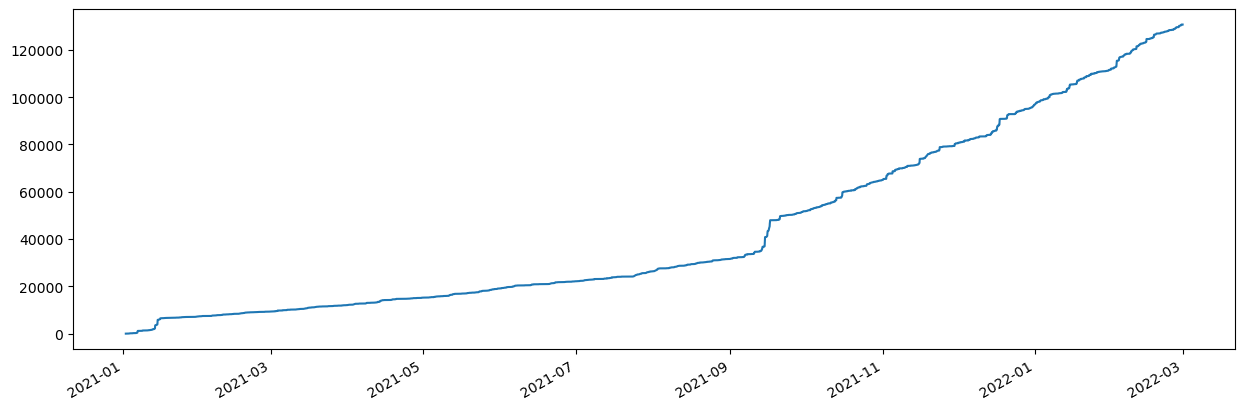

In [270]:
df_first_system_forecast_try_second_pnl['first_system_forecast_try_second_raw_return'].plot(figsize=(15, 5));

Let's check this for the test data

In [228]:
df_first_system_forecast_try_second_pnl_test = calculate_first_system_forecast_try_second_pnl(df_auction_data_test, df_system_prices_test)
volatility = df_first_system_forecast_try_second_pnl_test['first_system_forecast_try_second_raw_return'].pct_change().dropna().std()*np.sqrt(365)
print('Volatility (Standard Deviation) of returns annualised: ', volatility)
df_first_system_forecast_try_second_pnl_test.tail()

Number of trades:  1332
Volatility (Standard Deviation) of returns annualised:  2.855396013842384


price_first_auction  price_second_auction  \
2022-09-12 19:00:00                465.6                437.60   
2022-09-12 20:00:00                418.0                391.45   
2022-09-12 21:00:00                358.7                342.29   
2022-09-12 22:00:00                300.8                275.73   
2022-09-12 23:00:00                265.9                257.24   

                     traded_volume_first_auction  \
2022-09-12 19:00:00                       5809.2   
2022-09-12 20:00:00                       5480.5   
2022-09-12 21:00:00                       4750.4   
2022-09-12 22:00:00                       4994.7   
2022-09-12 23:00:00                       4509.4   

                     traded_volume_second_auction  \
2022-09-12 19:00:00                       14484.4   
2022-09-12 20:00:00                       14037.4   
2022-09-12 21:00:00                       12785.3   
2022-09-12 22:00:00                       11982.3   
2022-09-12 23:00:00                       12773.6   

                     price_forecast_first_auction  \
2022-09-12 19:00:00                        513.48   
2022-09-12 20:00:00                        439.66   
2022-09-12 21:00:00                        378.48   
2022-09-12 22:00:00                        298.65   
2022-09-12 23:00:00                        316.70   

                     price_forecast_second_auction      error        date  \
2022-09-12 19:00:00                     435.435638   2.164362  2022-09-12   
2022-09-12 20:00:00                     435.435638  43.985638  2022-09-12   
2022-09-12 21:00:00                     385.091217  42.801217  2022-09-12   
2022-09-12 22:00:00                     326.954865  51.224865  2022-09-12   
2022-09-12 23:00:00                     269.562195  12.322195  2022-09-12   

                     traded_volume_forecast_first_auction  \
2022-09-12 19:00:00                                5616.7   
2022-09-12 20:00:00                                5396.2   
2022-09-12 21:00:00                                4923.9   
2022-09-12 22:00:00                                4332.0   
2022-09-12 23:00:00                                4058.7   

                     forecast_system_price_low  forecast_system_price_high  \
2022-09-12 19:00:00                    1285.80                      444.26   
2022-09-12 20:00:00                    -234.22                      390.59   
2022-09-12 21:00:00                      37.57                      324.03   
2022-09-12 22:00:00                     401.78                      234.41   
2022-09-12 23:00:00                     368.66                      287.97   

                     system_price  forecast_system_price_mid  \
2022-09-12 19:00:00           NaN                    865.030   
2022-09-12 20:00:00           NaN                     78.185   
2022-09-12 21:00:00           NaN                    180.800   
2022-09-12 22:00:00           NaN                    318.095   
2022-09-12 23:00:00           NaN                    328.315   

                    first_system_forecast_try_second_auction_return  \
2022-09-12 19:00:00                                        5,190.96   
2022-09-12 20:00:00                                        5,190.96   
2022-09-12 21:00:00                                        5,190.96   
2022-09-12 22:00:00                                        5,190.96   
2022-09-12 23:00:00                                        5,190.96   

                    first_system_forecast_try_second_system_price_return  \
2022-09-12 19:00:00                                         108,924.41     
2022-09-12 20:00:00                                         108,924.41     
2022-09-12 21:00:00                                         108,924.41     
2022-09-12 22:00:00                                         108,924.41     
2022-09-12 23:00:00                                         108,924.41     

                     first_system_forecast_try_second_raw_return  \
2022-09-12 19:00:00                  

This strategy was also very profitable for the test data with a profit of 114,115.37 GBP

<AxesSubplot:>

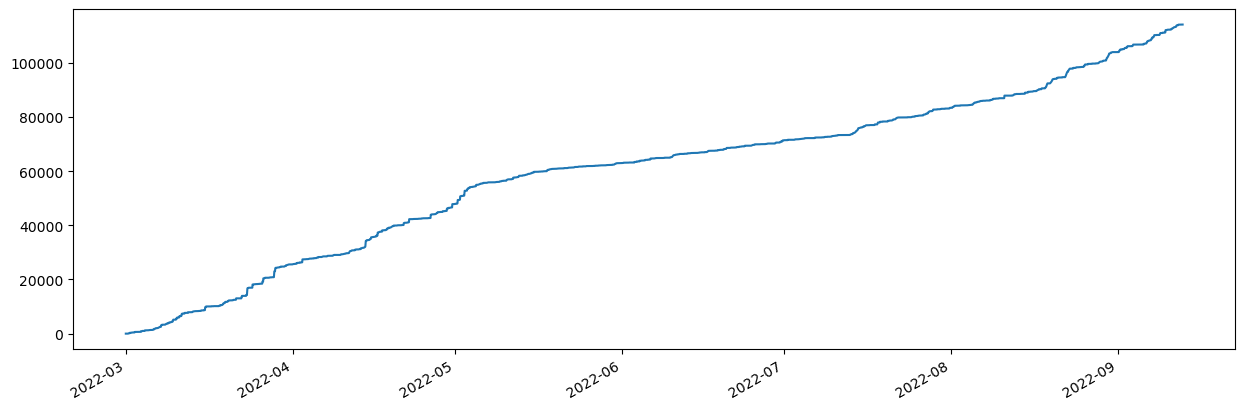

In [271]:
df_first_system_forecast_try_second_pnl_test['first_system_forecast_try_second_raw_return'].plot(figsize=(15, 5))

# Modelling for a volume forecast for the First Auction

In [91]:
TARGET_VOLUME = 'traded_volume_first_auction'

y_volume_train = df_auction_data_train[TARGET_VOLUME]
y_volume_test = df_auction_data_test[TARGET_VOLUME]

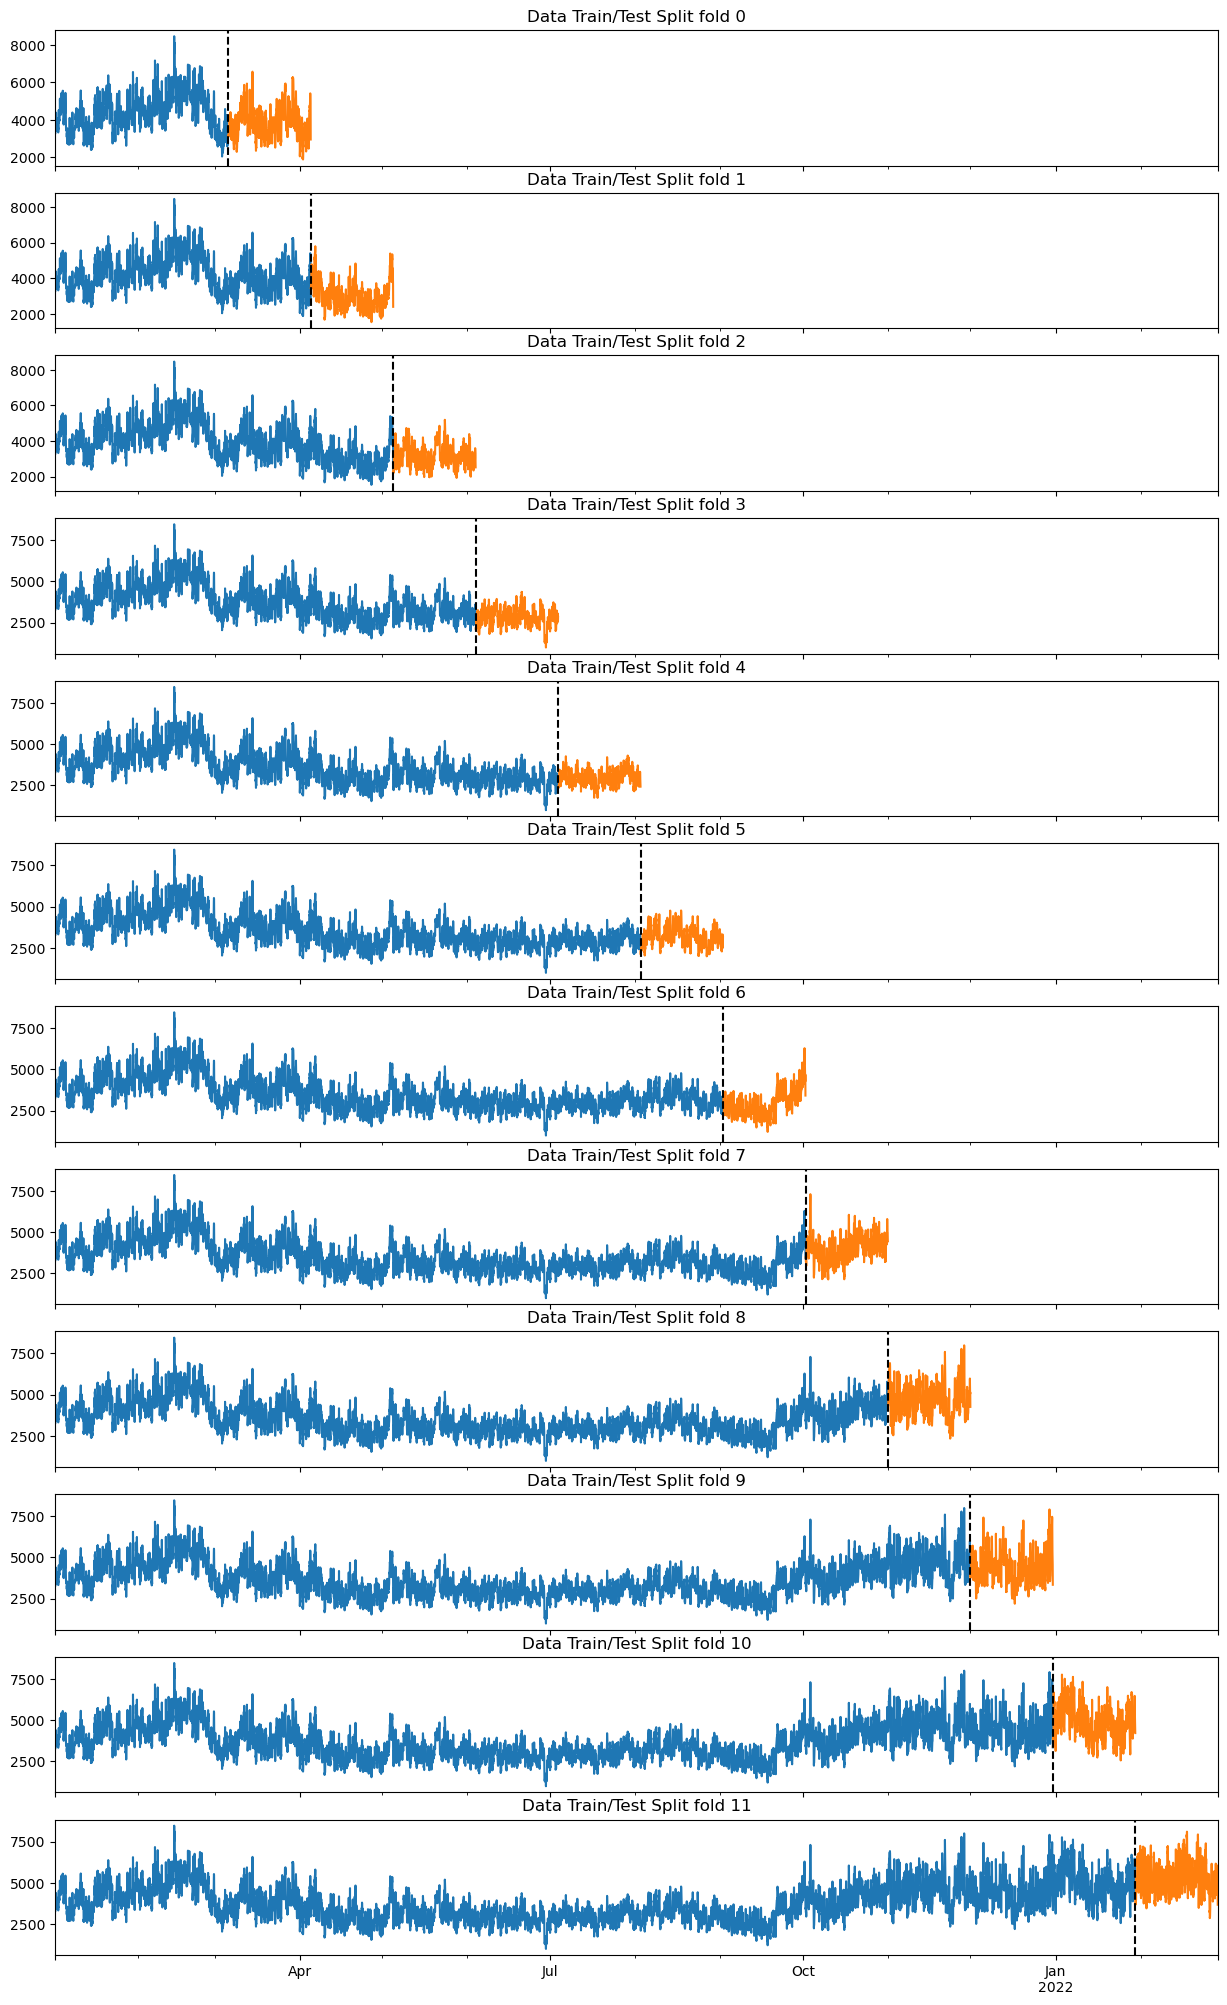

In [92]:
fig, axs = plt.subplots(12, 1, figsize=(15, 25), sharex=True)

fold = 0
for train_i, val_i in tss.split(y_volume_train):
    train = y_volume_train.iloc[train_i]
    test = y_volume_train.iloc[val_i]

    train.plot(ax=axs[fold], label='Training Set', title=f'Data Train/Test Split fold {fold}')
    test.plot(ax=axs[fold], label='Test Set')
    axs[fold].axvline(test.index.min(), color='black', ls='--')

    fold += 1
plt.show()

# Feature Engineering

As with price we will also add historic volume features for day and hour

In [93]:
# Add 'previous_day_ahead_volume' feature
def create_historic_volume_features(df):
    for i in df.index:
        i_prev_day = i - pd.DateOffset(days=1)
        try:
            df.loc[i, 'previous_day_ahead_volume'] = float(df_auction_data.loc[i_prev_day]['traded_volume_first_auction'])
        except: # for missing indexes try adding the value the hour before
            df.loc[i, 'previous_day_ahead_volume'] = float(df_auction_data.loc[i_prev_day - pd.DateOffset(hours=1)]['traded_volume_first_auction'])

        i_prev_hour = i - pd.DateOffset(hours=1)
        try:
            df.loc[i, 'previous_hour_volume'] = float(df_auction_data.loc[i_prev_hour]['traded_volume_first_auction'])
        except: # for missing indexes try adding the value the hour before
            df.loc[i, 'previous_hour_volume'] = float(df_auction_data.loc[i_prev_hour - pd.DateOffset(hours=1)]['traded_volume_first_auction'])
    return df

In [94]:
X_volume_train = create_historic_volume_features(X_train)
X_volme_test = create_historic_volume_features(X_test)

y_volume_train = y_volume_train.loc[X_volume_train.index] # adjust for removed entries from feature engineering
y_volume_test = y_volume_test.loc[X_volme_test.index]

In [95]:
params = {
    'max_depth': [1, 2, 3, 6, 10],
    'learning_rate': [0.01, 0.05, 0.1],
    'n_estimators': [100, 200, 500, 1000]
}

xgbr = xgb.XGBRegressor(random_state=42)

cv = tss.split(X_train)

clf_volume = GridSearchCV(
    estimator=xgbr, 
    param_grid=params,
    scoring='neg_root_mean_squared_error', 
    verbose=3,
    cv=cv
    
)
clf_volume.fit(X_train, y_volume_train)

Fitting 12 folds for each of 60 candidates, totalling 720 fits
[CV 1/12] END learning_rate=0.01, max_depth=1, n_estimators=100;, score=-1433.454 total time=   0.1s
[CV 2/12] END learning_rate=0.01, max_depth=1, n_estimators=100;, score=-952.579 total time=   0.1s
[CV 3/12] END learning_rate=0.01, max_depth=1, n_estimators=100;, score=-1114.127 total time=   0.1s
[CV 4/12] END learning_rate=0.01, max_depth=1, n_estimators=100;, score=-927.758 total time=   0.1s
[CV 5/12] END learning_rate=0.01, max_depth=1, n_estimators=100;, score=-1077.661 total time=   0.1s
[CV 6/12] END learning_rate=0.01, max_depth=1, n_estimators=100;, score=-1218.188 total time=   0.1s
[CV 7/12] END learning_rate=0.01, max_depth=1, n_estimators=100;, score=-1047.529 total time=   0.1s
[CV 8/12] END learning_rate=0.01, max_depth=1, n_estimators=100;, score=-1593.309 total time=   0.2s
[CV 9/12] END learning_rate=0.01, max_depth=1, n_estimators=100;, score=-2054.867 total time=   0.2s
[CV 10/12] END learning_rate=0

GridSearchCV(cv=<generator object TimeSeriesSplit.split at 0x1554a2c00>,
             estimator=XGBRegressor(base_score=None, booster=None,
                                    callbacks=None, colsample_bylevel=None,
                                    colsample_bynode=None,
                                    colsample_bytree=None,
                                    early_stopping_rounds=None,
                                    enable_categorical=False, eval_metric=None,
                                    feature_types=None, gamma=None, gpu_id=None,
                                    grow_policy=None, importance_type=None...
                                    max_cat_to_onehot=None, max_delta_step=None,
                                    max_depth=None, max_leaves=None,
                                    min_child_weight=None, missing=nan,
                                    monotone_constraints=None, n_estimators=100,
                                    n_jobs=None, num_parallel_tree=None,
                                    predictor=None, random_state=42, ...),
             param_grid={'learning_rate': [0.01, 0.05, 0.1],
                         'max_depth': [1, 2, 3, 6, 10],
                         'n_estimators': [100, 200, 500, 1000]},
             scoring='neg_root_mean_squared_error', verbose=3)

In [96]:
xgbr_volume_best = clf_volume.best_estimator_
print(clf_volume.best_params_)

{'learning_rate': 0.05, 'max_depth': 6, 'n_estimators': 200}


In [97]:
pd.DataFrame(clf_volume.cv_results_).sort_values('rank_test_score').head(15)

mean_fit_time  std_fit_time  mean_score_time  std_score_time  \
33       1.099877      0.266529         0.002314        0.000304   
15       5.576857      1.392611         0.006094        0.001194   
34       2.828463      0.672966         0.004642        0.001125   
30       1.222818      0.319525         0.002851        0.000783   
29       0.497599      0.131946         0.001879        0.000383   
11       2.469843      0.651433         0.004000        0.001845   
52       0.554067      0.130525         0.001813        0.000268   
35       5.585500      1.352428         0.005974        0.003299   
31       2.515479      0.518666         0.003591        0.000696   
32       0.640690      0.119138         0.001945        0.000577   
49       0.652304      0.229021         0.002019        0.000475   
14       2.914268      0.728782         0.004014        0.001108   
48       0.294953      0.084068         0.001911        0.000519   
26       0.985306      0.202404         0.002270        0.000250   
53       1.163533      0.302061         0.002759        0.000576   

   param_learning_rate param_max_depth param_n_estimators  \
33                0.05               6                200   
15                0.01               6               1000   
34                0.05               6                500   
30                0.05               3                500   
29                0.05               3                200   
11                0.01               3               1000   
52                 0.1               6                100   
35                0.05               6               1000   
31                0.05               3               1000   
32                0.05               6                100   
49                 0.1               3                200   
14                0.01               6                500   
48                 0.1               3                100   
26                0.05               2                500   
53                 0.1               6                200   

                                               params  split0_test_score  \
33  {'learning_rate': 0.05, 'max_depth': 6, 'n_est...        -390.941678   
15  {'learning_rate': 0.01, 'max_depth': 6, 'n_est...        -391.444271   
34  {'learning_rate': 0.05, 'max_depth': 6, 'n_est...        -391.725171   
30  {'learning_rate': 0.05, 'max_depth': 3, 'n_est...        -407.736897   
29  {'learning_rate': 0.05, 'max_depth': 3, 'n_est...        -400.952583   
11  {'learning_rate': 0.01, 'max_depth': 3, 'n_est...        -399.603864   
52  {'learning_rate': 0.1, 'max_depth': 6, 'n_esti...        -415.136818   
35  {'learning_rate': 0.05, 'max_depth': 6, 'n_est...        -395.009680   
31  {'learning_rate': 0.05, 'max_depth': 3, 'n_est...        -421.044076   
32  {'learning_rate': 0.05, 'max_depth': 6, 'n_est...        -393.786058   
49  {'learning_rate': 0.1, 'max_depth': 3, 'n_esti...        -424.477051   
14  {'learning_rate': 0.01, 'max_depth': 6, 'n_est...        -395.776829   
48  {'learning_rate': 0.1, 'max_depth': 3, 'n_esti...        -416.525869   
26  {'learning_rate': 0.05, 'max_depth': 2, 'n_est...        -385.218525   
53  {'learning_rate': 0.1, 'max_depth': 6, 'n_esti...        -413.952995   

    split1_test_score  ...  split5_test_score  split6_test_score  \
33        -350.338515  ...        -236.331333        -317.751040   
15        -366.030624  ...        -239.935310        -311.671728   
34        -353.733816  ...        -241.494740        -315.356009   
30        -378.389384  ...        -252.534271        -316.687432   
29        -365.821884  ...        -238.529914        -314.642608   
11        -373.492961  ...        -237.805045        -314.355258   
52        -363.566429  ...        -242.782505        -311.415946   
35        -355.365628  ...        -245.031621        -320.228387   
31        -373.632427  ...        -253.376344        -324.390218   
32        -347.251329  ...        -240.00

In [98]:
score = mean_squared_error(y_volume_train, xgbr_volume_best.predict(X_train), squared=False)
print(f'RMSE Score on Train set: {score:0.2f}')

score = mean_squared_error(y_volume_test, xgbr_volume_best.predict(X_test), squared=False)
print(f'RMSE Score on Test set: {score:0.2f}')

RMSE Score on Train set: 225.52
RMSE Score on Test set: 388.45


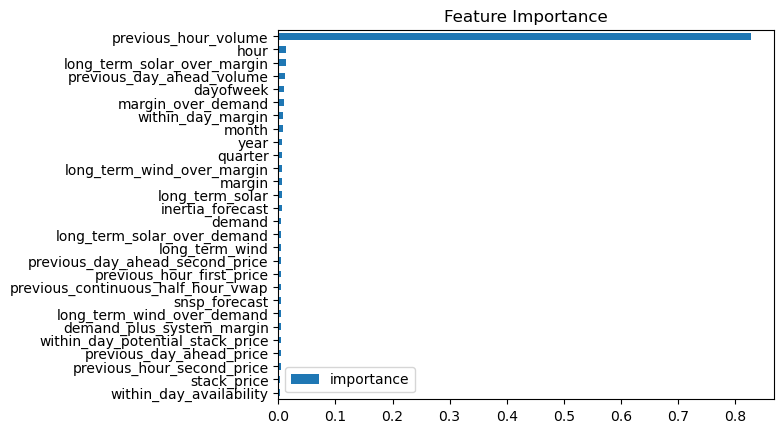

In [99]:
pd.DataFrame(data=xgbr_volume_best.feature_importances_, index=xgbr_volume_best.feature_names_in_, columns=['importance']).sort_values('importance').plot(kind='barh', title='Feature Importance')
plt.show()

By far the most important feature is the added `previous_hour_volume` feature

In [100]:
df_auction_data_train['traded_volume_forecast_first_auction'] = [float('{:.1f}'.format(x)) for x in xgbr_volume_best.predict(X_train)]
df_auction_data_train.head()

price_first_auction  price_second_auction  \
2021-01-02 00:00:00                 64.0                 63.91   
2021-01-02 01:00:00                 58.0                 66.12   
2021-01-02 02:00:00                 50.0                 59.28   
2021-01-02 03:00:00                 50.0                 54.96   
2021-01-02 04:00:00                 45.5                 49.65   

                     traded_volume_first_auction  \
2021-01-02 00:00:00                       3260.2   
2021-01-02 01:00:00                       3265.2   
2021-01-02 02:00:00                       3327.1   
2021-01-02 03:00:00                       3668.6   
2021-01-02 04:00:00                       3900.3   

                     traded_volume_second_auction  \
2021-01-02 00:00:00                        3763.0   
2021-01-02 01:00:00                        3898.3   
2021-01-02 02:00:00                        3408.2   
2021-01-02 03:00:00                        3388.5   
2021-01-02 04:00:00                        3925.1   

                     price_forecast_first_auction  \
2021-01-02 00:00:00                         61.32   
2021-01-02 01:00:00                         61.41   
2021-01-02 02:00:00                         56.98   
2021-01-02 03:00:00                         56.04   
2021-01-02 04:00:00                         50.45   

                     price_forecast_second_auction  \
2021-01-02 00:00:00                      62.174038   
2021-01-02 01:00:00                      64.573357   
2021-01-02 02:00:00                      62.301605   
2021-01-02 03:00:00                      58.717190   
2021-01-02 04:00:00                      58.717190   

                     traded_volume_forecast_first_auction  
2021-01-02 00:00:00                                3125.4  
2021-01-02 01:00:00                                3211.4  
2021-01-02 02:00:00                                3274.4  
2021-01-02 03:00:00                                3320.1  
2021-01-02 04:00:00                                3564.7

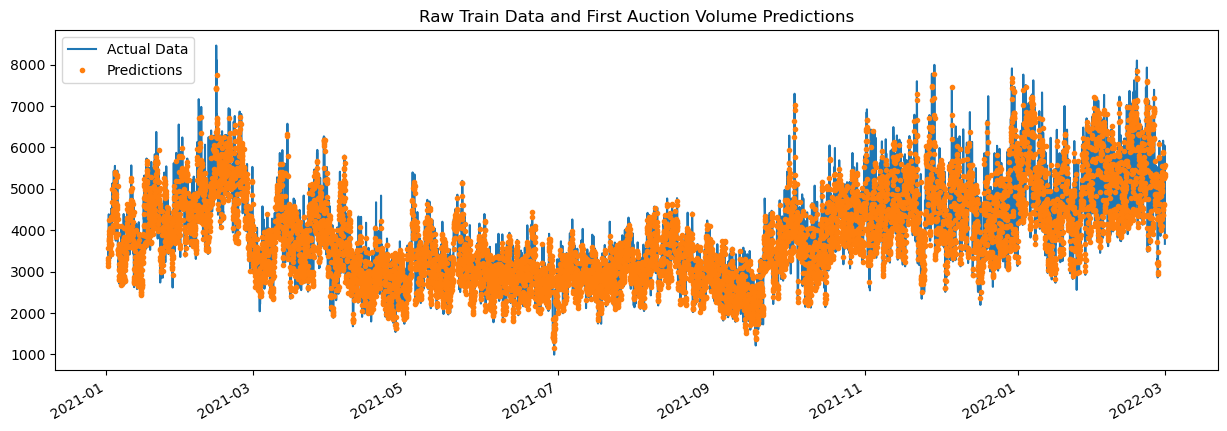

In [101]:
ax = df_auction_data_train[TARGET_VOLUME].plot(figsize=(15, 5))
df_auction_data_train['traded_volume_forecast_first_auction'].plot(ax=ax, style='.')
plt.legend(['Actual Data', 'Predictions'])
ax.set_title('Raw Train Data and First Auction Volume Predictions')
plt.show()

In [266]:
df_auction_data_test['traded_volume_forecast_first_auction'] = [float('{:.1f}'.format(x)) for x in xgbr_volume_best.predict(X_test)] # As per requirements round to single decimal
df_auction_data_test.head()

/var/folders/c8/y_c7_b4s2wq1r7z20jclk7g40000gn/T/ipykernel_66343/1107710482.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_auction_data_test['traded_volume_forecast_first_auction'] = [float('{:.1f}'.format(x)) for x in xgbr_volume_best.predict(X_test)] # As per requirements round to single decimal


price_first_auction  price_second_auction  \
2022-03-01 00:00:00                202.8                208.52   
2022-03-01 01:00:00                202.8                209.48   
2022-03-01 02:00:00                200.4                204.83   
2022-03-01 03:00:00                197.5                195.90   
2022-03-01 04:00:00                202.3                194.31   

                     traded_volume_first_auction  \
2022-03-01 00:00:00                       3586.6   
2022-03-01 01:00:00                       3405.1   
2022-03-01 02:00:00                       3259.1   
2022-03-01 03:00:00                       3201.6   
2022-03-01 04:00:00                       3404.4   

                     traded_volume_second_auction  \
2022-03-01 00:00:00                        9068.0   
2022-03-01 01:00:00                        8862.9   
2022-03-01 02:00:00                        8784.4   
2022-03-01 03:00:00                        8704.1   
2022-03-01 04:00:00                        8995.4   

                     price_forecast_first_auction  \
2022-03-01 00:00:00                        195.56   
2022-03-01 01:00:00                        191.89   
2022-03-01 02:00:00                        183.95   
2022-03-01 03:00:00                        175.54   
2022-03-01 04:00:00                        177.83   

                     price_forecast_second_auction      error        date  \
2022-03-01 00:00:00                     185.313705  23.206295  2022-03-01   
2022-03-01 01:00:00                     185.313705  24.166295  2022-03-01   
2022-03-01 02:00:00                     183.292374  21.537626  2022-03-01   
2022-03-01 03:00:00                     183.292374  12.607626  2022-03-01   
2022-03-01 04:00:00                     185.313705   8.996295  2022-03-01   

                     traded_volume_forecast_first_auction  
2022-03-01 00:00:00                                3372.7  
2022-03-01 01:00:00                                3584.6  
2022-03-01 02:00:00                                3441.5  
2022-03-01 03:00:00                                3353.9  
2022-03-01 04:00:00                                3353.0

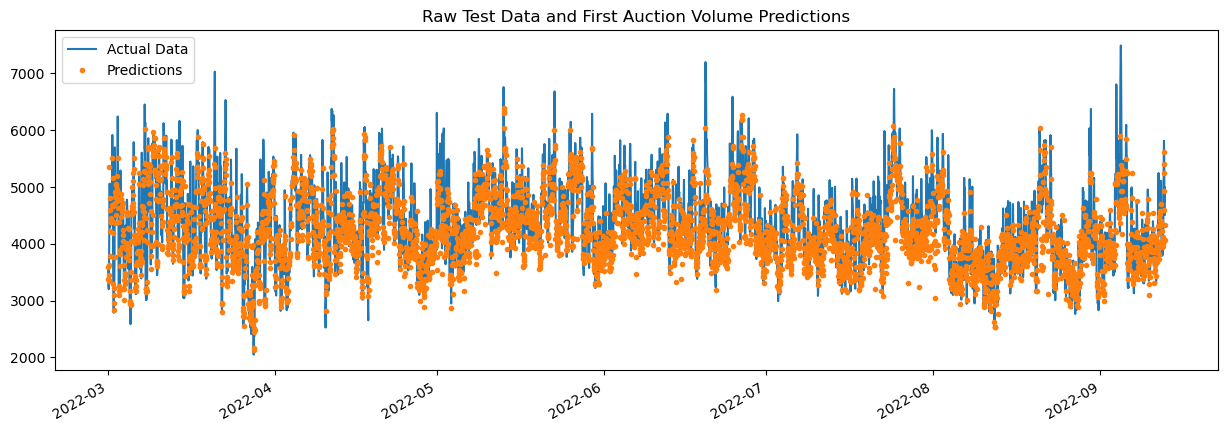

In [103]:
ax = df_auction_data_test[TARGET_VOLUME].plot(figsize=(15, 5))
df_auction_data_test['traded_volume_forecast_first_auction'].plot(ax=ax, style='.')
plt.legend(['Actual Data', 'Predictions'])
ax.set_title('Raw Test Data and First Auction Volume Predictions')
plt.show()

Amend the best strategy function to take an forecase volume percentages argument (default 100%)

In [261]:
def calculate_first_system_forecast_try_second_pnl_with_volume(df_auction_data, df_system_prices, forecast_volume_percent = 1):
    df_price_data = pd.concat([df_auction_data, df_system_prices], axis=1, join='inner') # inner join for removed entries from feature engineering
    total_return = 0
    auction_return = 0
    system_price_return = 0
    number_of_trades = 0
    for i, row in df_price_data.iterrows():
        if not math.isnan(row['system_price']): # only look to trade if System Price is available this hour
            executed_volume = min(row['traded_volume_forecast_first_auction'] * forecast_volume_percent, row['traded_volume_first_auction']) # trade lower of forecasted volume percentage or executed volume
            if (row['price_forecast_first_auction'] + 10 < row['forecast_system_price_mid']) & (row['price_forecast_first_auction'] >= row['price_first_auction']):
                number_of_trades += 1
                if row['price_first_auction'] + 10 < row['price_second_auction']:
                    total_return += (row['price_second_auction'] - row['price_first_auction'] - 10) * executed_volume
                    auction_return += (row['price_second_auction'] - row['price_first_auction'] - 10) * executed_volume
                else:
                    total_return += (row['forecast_system_price_mid'] - row['price_first_auction'] - 10) * executed_volume
                    system_price_return += (row['forecast_system_price_mid'] - row['price_first_auction'] - 10) * executed_volume
            elif (row['price_forecast_first_auction'] - 10 > row['system_price']) & (row['price_forecast_first_auction'] <= row['price_first_auction']):
                number_of_trades += 1
                if row['price_first_auction'] - 10 > row['price_second_auction']:
                    total_return += (row['price_first_auction'] - row['price_second_auction'] - 10) * executed_volume
                    auction_return+= (row['price_first_auction'] - row['price_second_auction'] - 10) * executed_volume
                else:
                    total_return += (row['price_first_auction'] - row['system_price'] - 10) * executed_volume
                    system_price_return += (row['price_first_auction'] - row['system_price'] - 10) * executed_volume

        df_price_data.loc[i, 'first_system_forecast_try_second_auction_return'] = '{:,.2f}'.format(auction_return)
        df_price_data.loc[i, 'first_system_forecast_try_second_system_price_return'] = '{:,.2f}'.format(system_price_return)
        df_price_data.loc[i, 'first_system_forecast_try_second_raw_return'] = total_return
        df_price_data.loc[i, 'first_system_forecast_try_second_return'] = '{:,.2f}'.format(total_return)

    print('Number of trades: ', number_of_trades)
    return df_price_data

### Using the best strategy above calculate profits using a percentage of forecasted volume (will use 0.1%)

In [264]:
calculate_first_system_forecast_try_second_pnl_with_volume(df_auction_data_train, df_system_prices_train, 0.001)[['first_system_forecast_try_second_return']]

Number of trades:  2281


first_system_forecast_try_second_return
2021-01-02 00:00:00                                    0.00
2021-01-02 01:00:00                                    0.00
2021-01-02 02:00:00                                    0.00
2021-01-02 03:00:00                                    0.00
2021-01-02 04:00:00                                    0.00
...                                                     ...
2022-02-28 19:00:00                              520,073.47
2022-02-28 20:00:00                              520,073.47
2022-02-28 21:00:00                              520,073.47
2022-02-28 22:00:00                              520,073.47
2022-02-28 23:00:00                              520,073.47

[10151 rows x 1 columns]

In [265]:
calculate_first_system_forecast_try_second_pnl_with_volume(df_auction_data_test, df_system_prices_test, 0.001)[['first_system_forecast_try_second_return']]

Number of trades:  1332


first_system_forecast_try_second_return
2022-03-01 00:00:00                                    0.00
2022-03-01 01:00:00                                    0.00
2022-03-01 02:00:00                                    0.00
2022-03-01 03:00:00                                    0.00
2022-03-01 04:00:00                                    0.00
...                                                     ...
2022-09-12 19:00:00                              483,907.41
2022-09-12 20:00:00                              483,907.41
2022-09-12 21:00:00                              483,907.41
2022-09-12 22:00:00                              483,907.41
2022-09-12 23:00:00                              483,907.41

[4703 rows x 1 columns]

From the training set we calculate a profit of 520,073.47 GBP and from the test set 483,907.41 GBP